In [11]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt

In [12]:
sga_ids = [9769, 11977, 12892, 14501, 16383, 19235, 19278, 25532, 30149, 31220, 32484, 36904, 37543, 46327, 58617, 73111, 88963, 91660, 90791, 106536, 
           114405, 114489, 122580, 126630, 125611, 128163, 128411, 130766, 149502, 153504, 175220, 176736, 184044, 186239, 189685, 188525, 190308, 
           192158, 196470, 199038, 202236, 205028, 209429, 212382, 218773, 235556, 254532, 272164, 272562, 276638, 288715, 289743, 291766, 300446, 
           302062, 305831, 309378, 319942, 330678, 349027, 349346, 363344, 373692, 378842, 384420, 389177, 393190, 395070, 398443, 398532, 416531, 
           431242, 430161, 432294, 450689, 450566, 455486, 457147, 458798, 462867, 466872, 467582, 471327, 469868, 471893, 473436, 477805, 481956, 
           485800, 493017, 507499, 526710, 544419, 544810, 544799, 544943, 548724, 548848, 550458, 564440, 569298, 568664, 570086, 582248, 591927, 
           607528, 608015, 629144, 630029, 630390, 635043, 638386, 641578, 643231, 643845, 644940, 647966, 649753, 649960, 651096, 654469, 659599, 
           663463, 671301, 671533, 694525, 696291, 696345, 706579, 720480, 722142, 726854, 728327, 729726, 729754, 736449, 742167, 743030, 744650, 
           752683, 757313, 757166, 758123, 759261, 759003, 766672, 783693, 793633, 804643, 805225, 819754, 820598, 823301, 824225, 826809, 827949, 
           833961, 833981, 843065, 843126, 845052, 887433, 901663, 901980, 908818, 908978, 911046, 914975, 914909, 916161, 920806, 923400, 925923, 
           925354, 928810, 928876, 932984, 947709, 953644, 957521, 957850, 967351, 968864, 971635, 975775, 972260, 977015, 976853, 979168, 978708, 
           989040, 989244, 1001302, 1003319, 1008726, 1014959, 1018187, 1021462, 1026141, 1031898, 1033651, 1033344, 1050173, 1065602, 1073430, 
           1086934, 1087039, 1087374, 1090772, 1091806, 1096564, 1098043, 1103477, 1111824, 1117018, 1124386, 1143335, 1146354, 1161160, 1167691, 
           1171841, 1179377, 1184894, 1184912, 1186034, 1187240, 1188032, 1188617, 1188926, 1193015, 1191665, 1194588, 1194958, 1199020, 1199539, 
           1201319, 1203786, 1204237, 1206707, 1218166, 1219319, 1254154, 1264056, 1264591, 1267967, 1271477, 1271549, 1272700, 1273605, 1278144, 
           1281619, 1282407, 1285273, 1286710, 1289613, 1293967, 1301768, 1304908, 1335916, 1338866, 1345100, 1348956, 1349555, 1354266, 1355575, 
           1361363, 1361399, 1365519, 1365549, 1367137, 1368018, 1368443, 1374964, 1379143, 1405053, 1429680, 1434487]

In [13]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/rotcurves/'

# load updated fuji table
tf_fuji = Table.read(data_dir + 'SV/desi_pv_tf_fuji_healpix_rotcurve_EOA_VI_velocity.fits') 
# load iron table
tf_iron = Table.read(data_dir + 'Y1/desi_pv_tf_iron_healpix_rotcurve_EOA_VI_velocity.fits')
#combine
tf_mastertable = vstack([tf_fuji,tf_iron])
#unique SGA IDs in rot curve galaxies
tf_galaxies = np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1])
tf_mastertable_dict = {}
for sga_id in np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1]):
    tf_mastertable_dict[sga_id] = np.where(tf_mastertable['SGA_ID'] == sga_id)[0]

# load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

In [14]:
tf_mastertable['ROTCURVE_CHI2']=np.nan
tf_mastertable['VMAX']=np.nan
tf_mastertable['VMAX_ERR']=np.nan
tf_mastertable['RTURN']=np.nan
tf_mastertable['RTURN_ERR']=np.nan
tf_mastertable['ALPHA']=np.nan
tf_mastertable['ALPHA_ERR']=np.nan
tf_mastertable['INCLINATION']=np.nan

In [15]:
def inclination_angle(axis_ratio):
    '''
    Calculate Inclination Angle
    Parameters
    ----------
    axis_ratio : float
        Axis ratio for galaxy.
        
    Returns
    -------
    Inclination angle in Radians
    '''
    cos_i2 = (axis_ratio ** 2 - 0.2 ** 2)/(1 - 0.2 ** 2)
    if cos_i2 < 0:
        cos_i2 = 0.001
    inclination = np.arccos(cos_i2 ** 0.5)
    return inclination

In [16]:
def v_rot(r, v_max, r_turn, alpha):
    '''
    Calculate Rotational Velocity at a target
    Parameters
    ----------
    r : float
        Target distance.
    v_max : float
        Maximum velocity.
    r_turn: float
        Velocity curve turning point.
    alpha : 
        Velocity curve angle.
    Returns
    -------
    Rotational velocity in km / s
    '''
    vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
    return vrot

In [17]:
def chi_2(params, v, v_err, r):
    '''
    Calculate Chi Squared 
    Parameters
    ----------
    params : list
        v_max, r_turn, alpha.
    v : float
        Absolute value of velocity.
    v_err : float
        Uncertainty for velocity.
    r : 
        Target distance.
    Returns
    -------
    Chi Squared value
    '''
    v_max, r_turn, alpha = params
    v_model = v_rot(r, v_max, r_turn, alpha)
    chi_sq = np.sum((v_model - v)**2/(v_err**2))
    return chi_sq

In [59]:
hess = np.load('/pscratch/sd/j/jjpim/hessians/114489_hessian.npy')
hess

array([[ 2.66017714e-01,             nan,  4.01155200e-01],
       [            nan,             nan,             nan],
       [ 4.01155200e-01,             nan, -2.84350438e+06]])

In [67]:
fit_params_err

array([nan, nan, nan])

In [60]:
hess_inv = np.linalg.inv(hess)
fit_params_err = np.sqrt(np.diag(np.abs(hess_inv)))

In [ ]:
fit_params_err = np.ones(3)*np.nan

/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


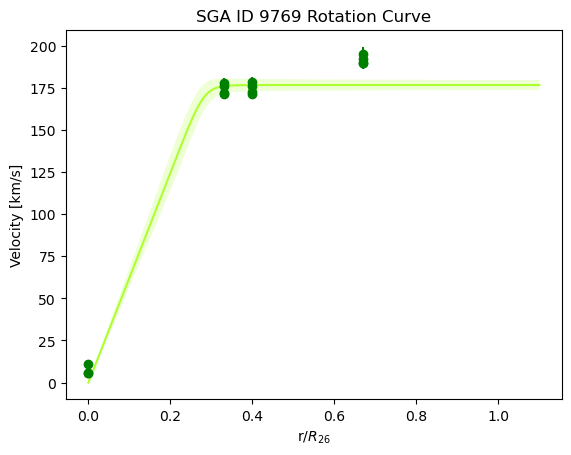

[0.70210924 0.02216248 5.60181603]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


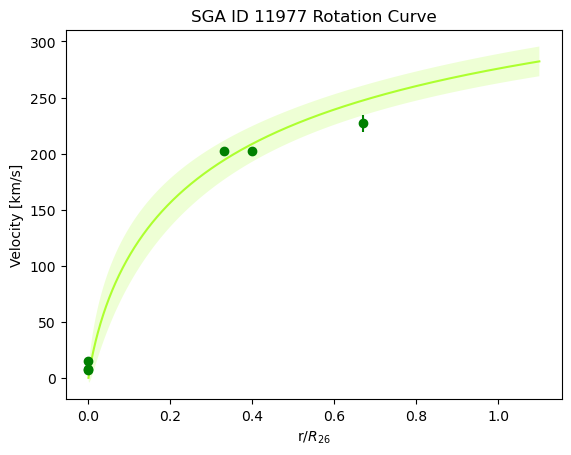

[3.04968843e+01 7.26415057e-02 2.06004209e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


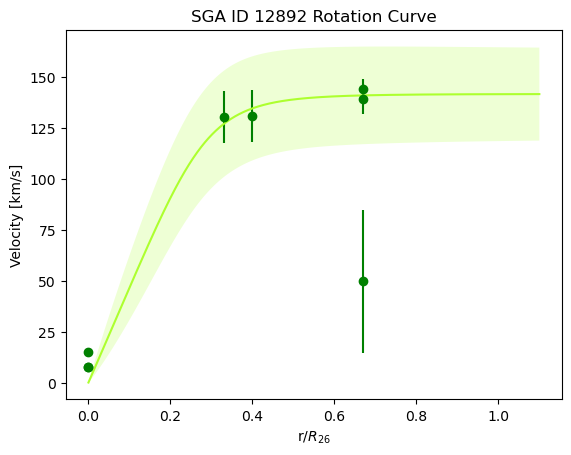

[5.5432212  0.15936477 6.62303724]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


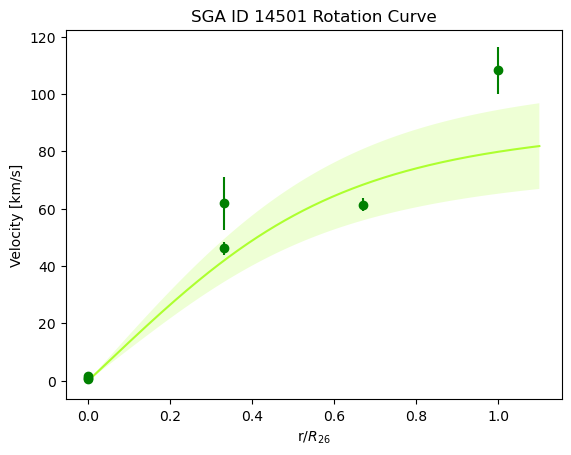

[10.2214454   0.09750513  0.38010649]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


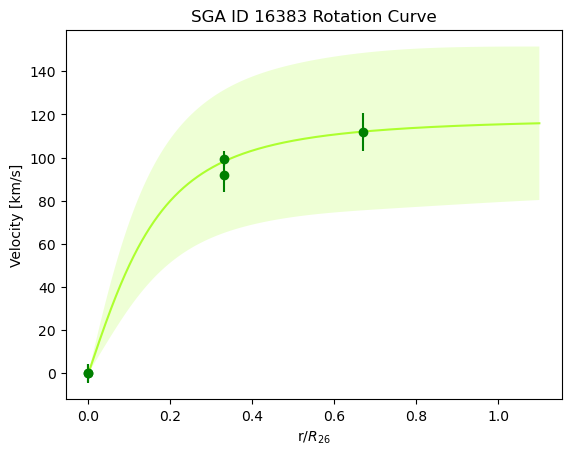

[27902.10003455   382.16936121  4507.09363365]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


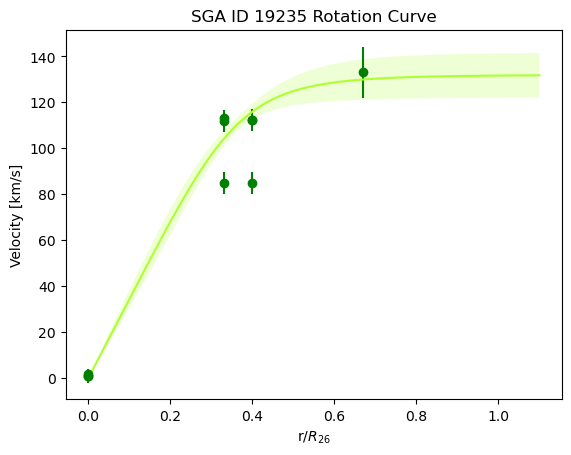

[9.76209309 0.06601771 1.0249691 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


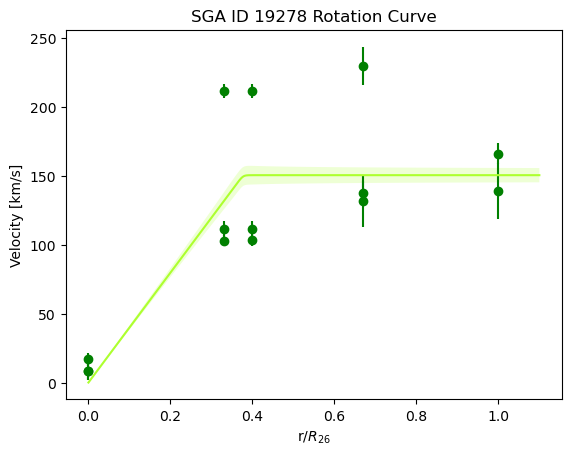

[2.46255194e+00 1.07702486e-02 1.66838333e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


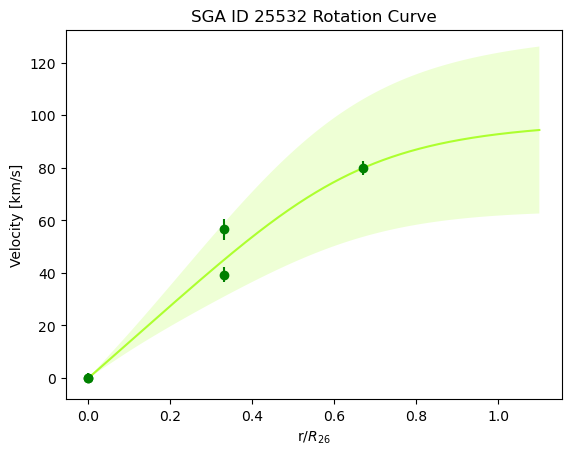

[626.07020478   4.16027202  72.7605999 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


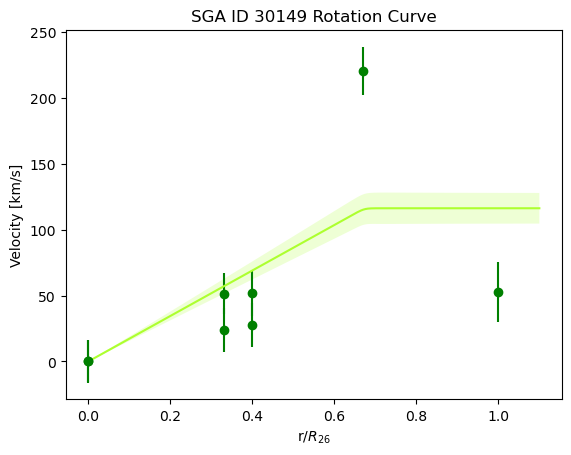

[1.07873093e+01 2.25470070e-02 1.40912409e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


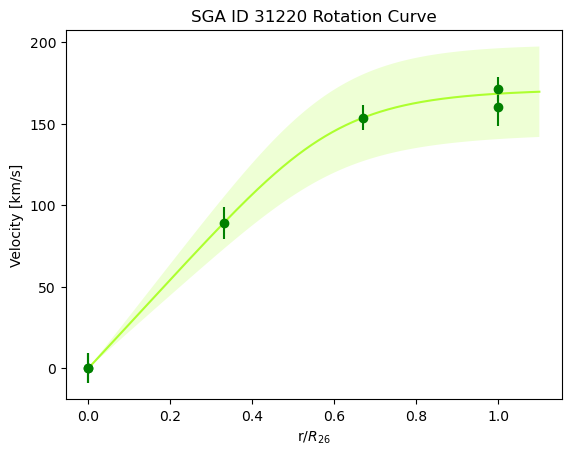

[12.2912136   0.07598999  4.00000519]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


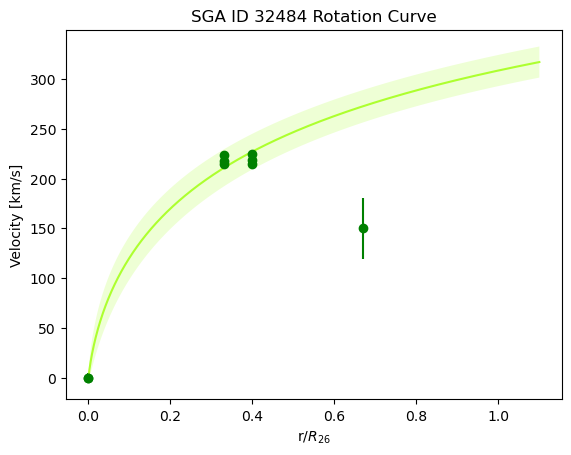

[3.84937840e+01 4.59597107e-02 6.24890176e-03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


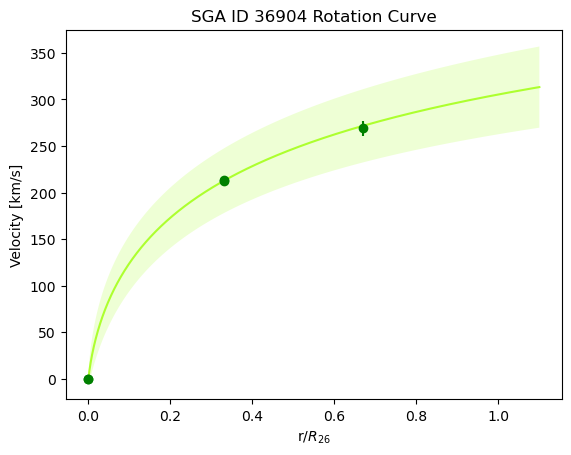

[1.59209105e+02 4.33412001e-02 1.21786378e-01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


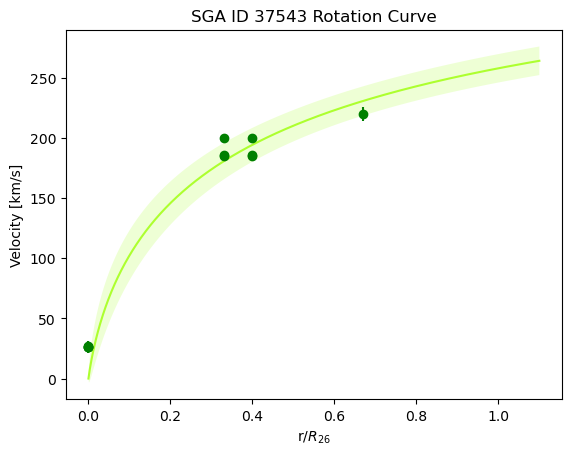

[2.95459405e+01 5.84590763e-02 2.75382206e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


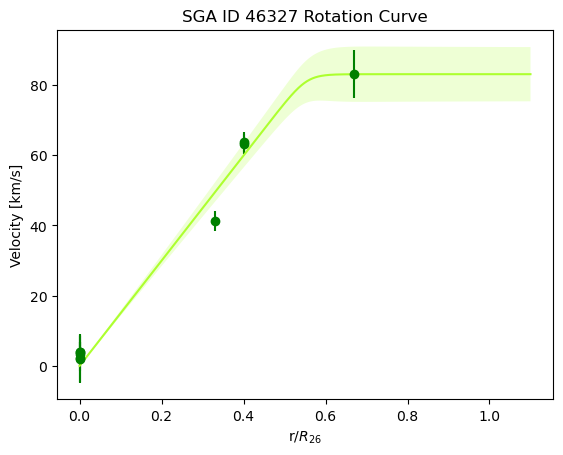

[6.87173644e+00 4.86489828e-02 1.96037407e+02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


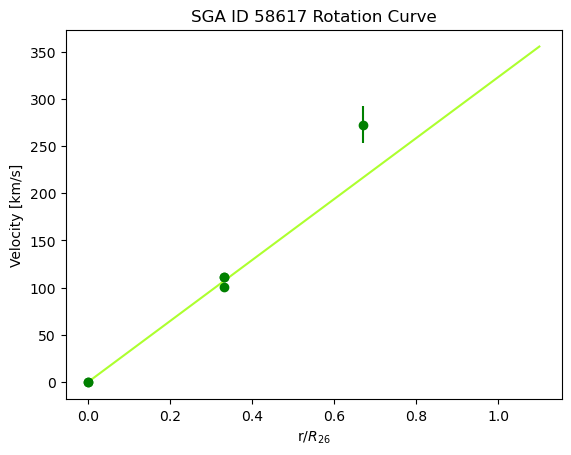

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


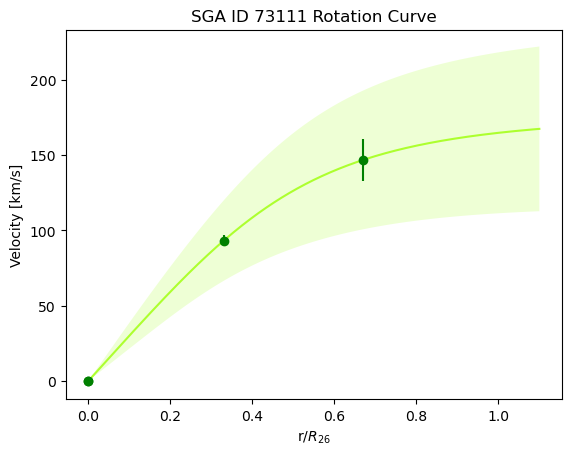

[5113.15808756   10.18373087  250.80397169]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


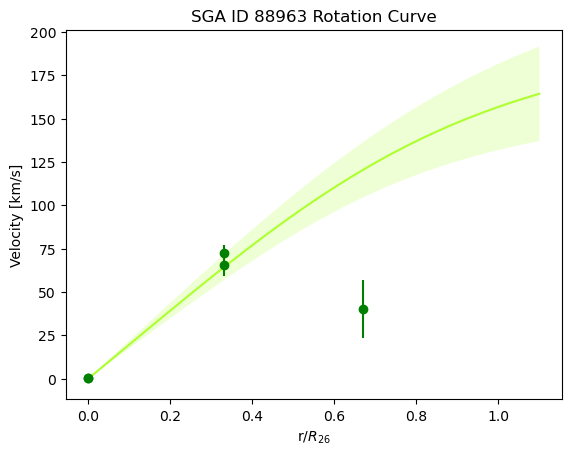

[46.02098125  0.25052883  1.04753971]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide 

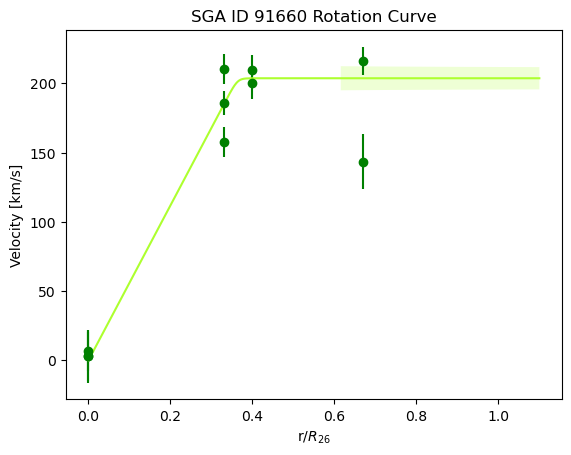

[5.84713891e+00 1.55719330e-02 3.59581254e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


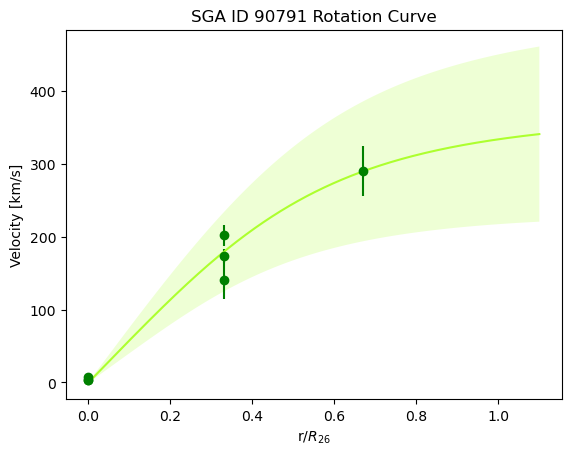

[940.63578771   1.09544105  16.21621002]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, c

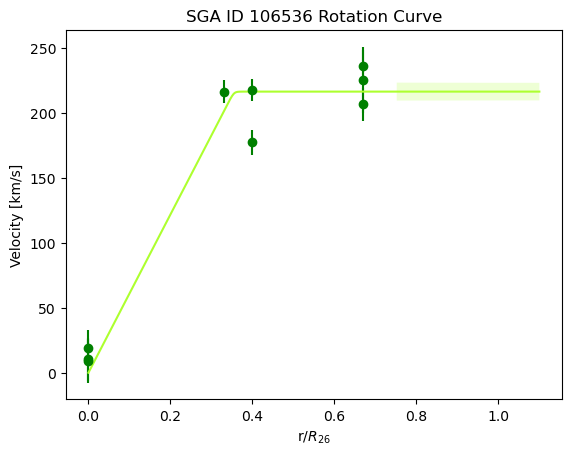

[5.11288836e+00 1.87044210e-02 7.31121850e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

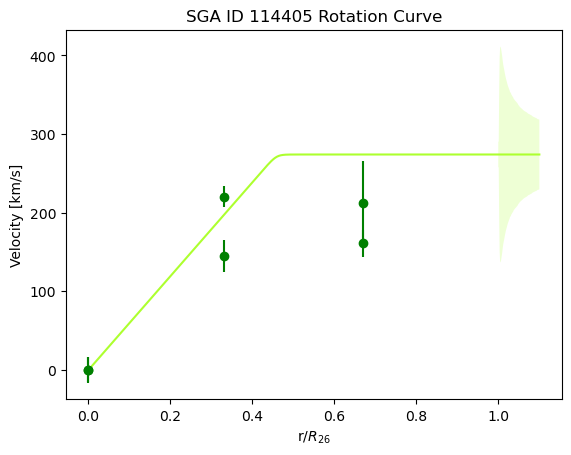

[1.62697534e+01 3.77786953e-02 2.11516962e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


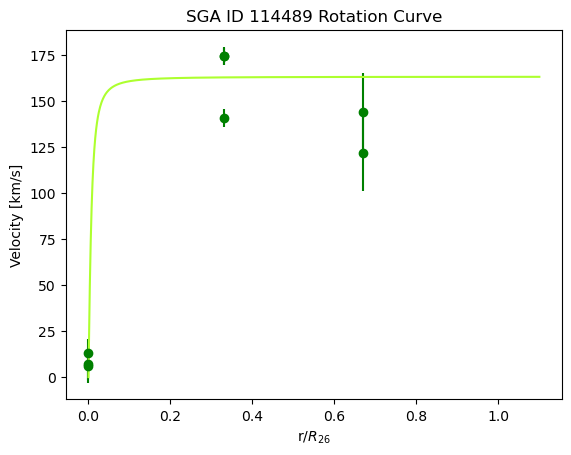

[nan nan nan]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

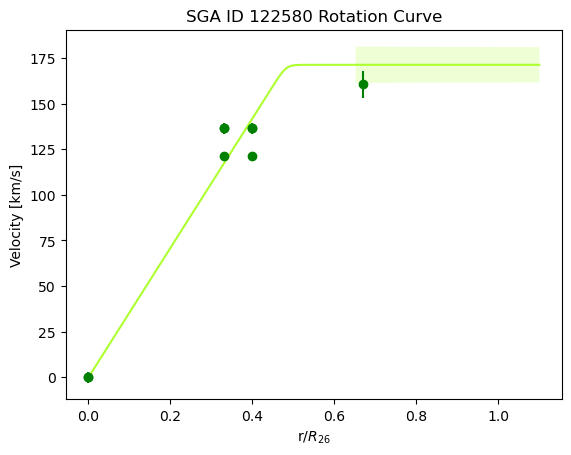

[7.32182157e+00 2.09379049e-02 4.11023109e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


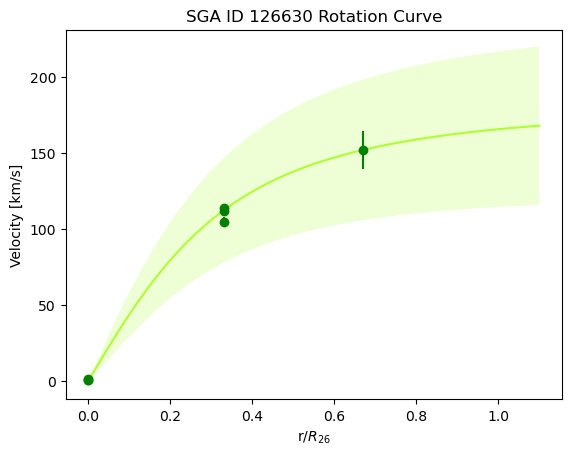

[1.04624967e+02 6.58771677e-02 3.84426915e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


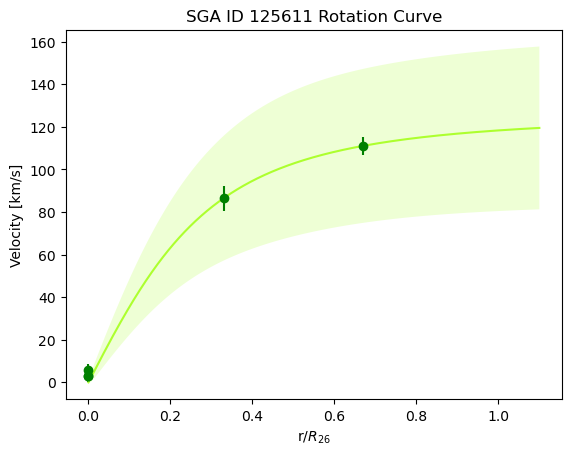

[991.39802775   3.96398679  73.19225665]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


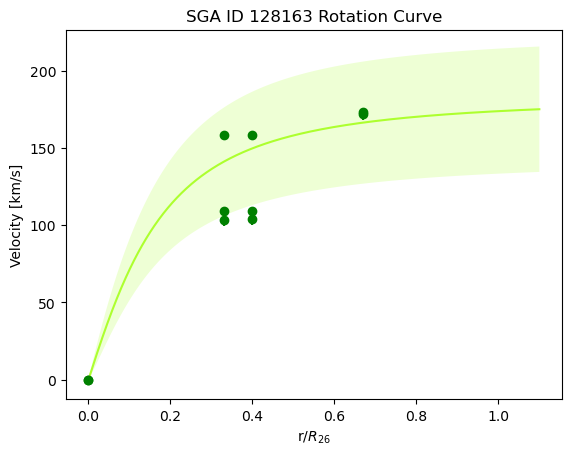

[31.39189182  0.14377883  1.57692268]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


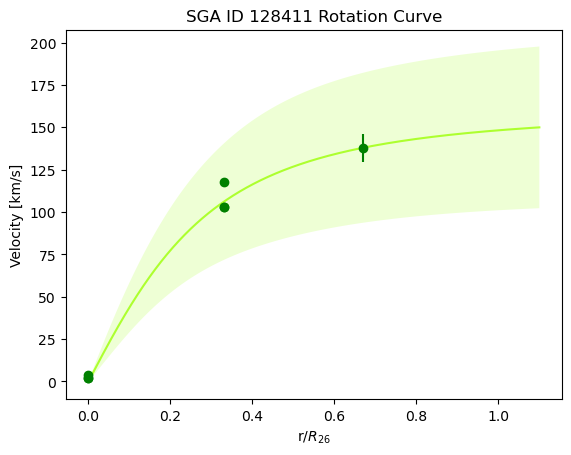

[15071.2606567     38.93456595   699.88619794]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

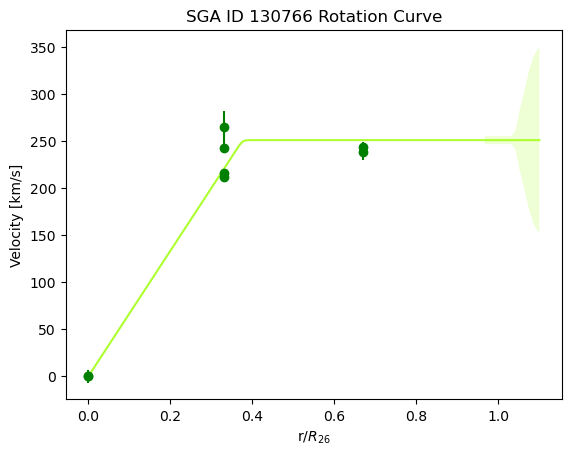

[4.23402311e+00 7.88630899e-03 5.73198711e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, c

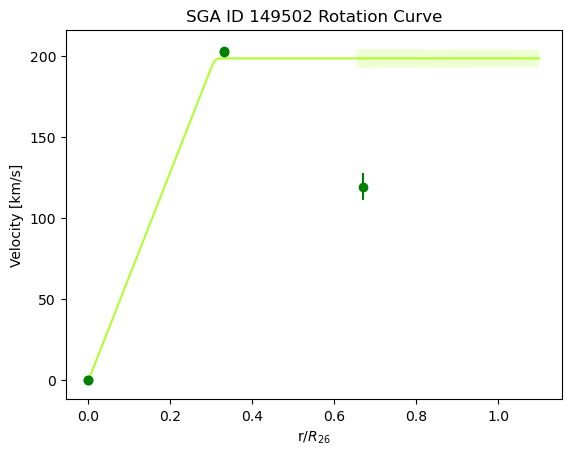

[1.90531354e+00 1.15462740e-01 4.83063239e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


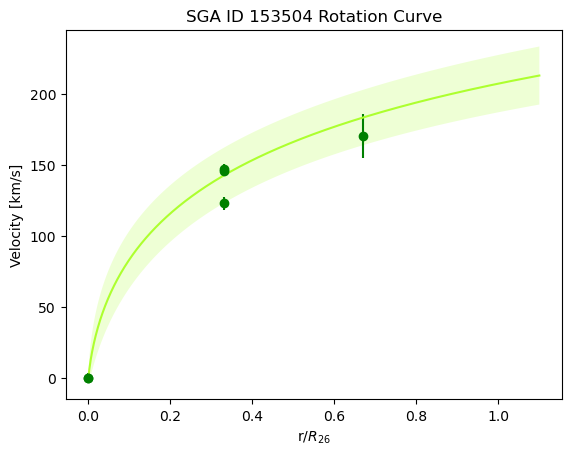

[8.20687738e+01 7.34669501e-02 4.32195381e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


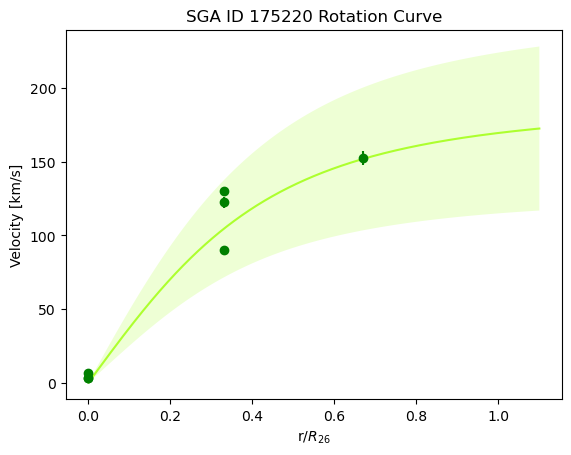

[3.33621430e+02 1.02954132e-01 1.04710740e+01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


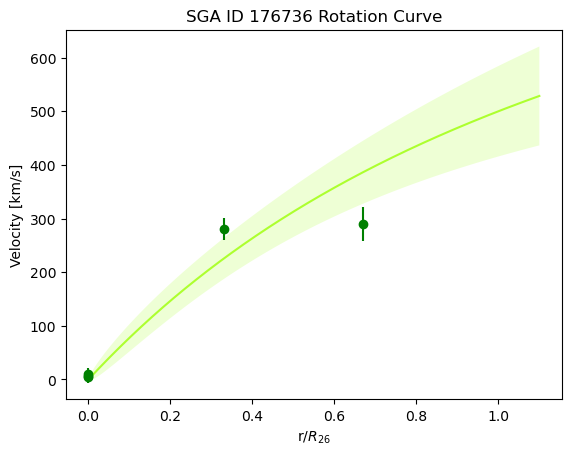

[3.68100076e+02 7.05425088e-01 3.28200009e-01]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


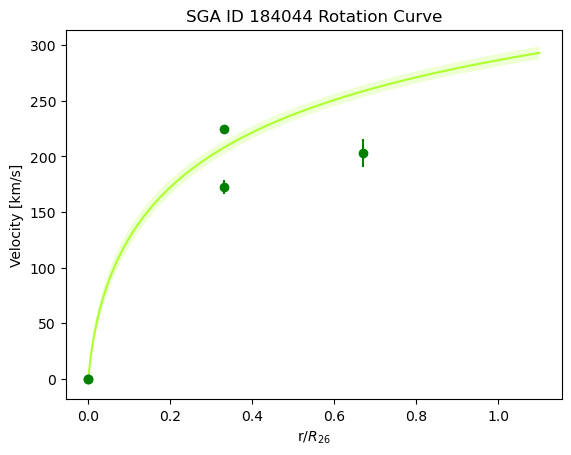

[2.66115419e+01 1.81714267e-02 1.81154833e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


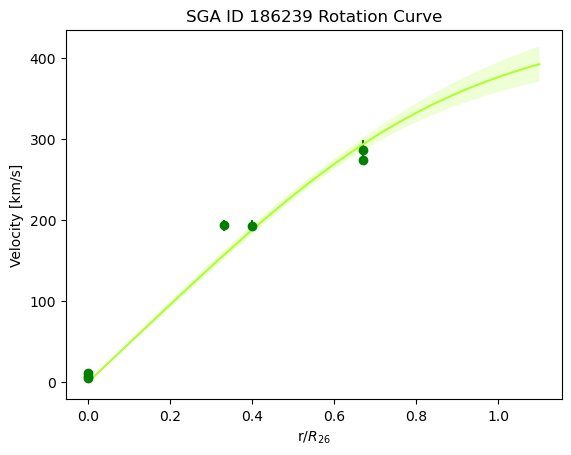

[44.70679991  0.11391634  0.62006238]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, c

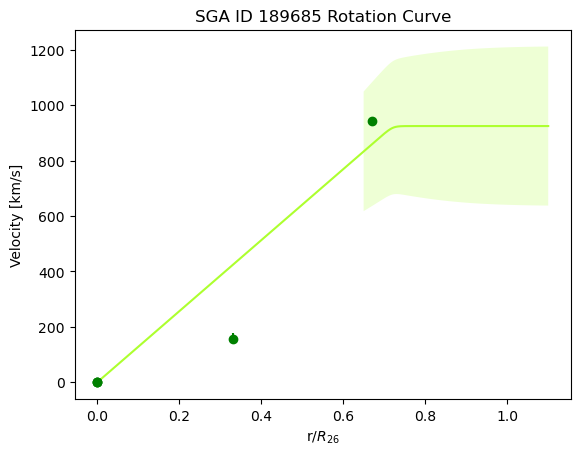

[4.27336421e+02 3.32944628e-01 5.53611359e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


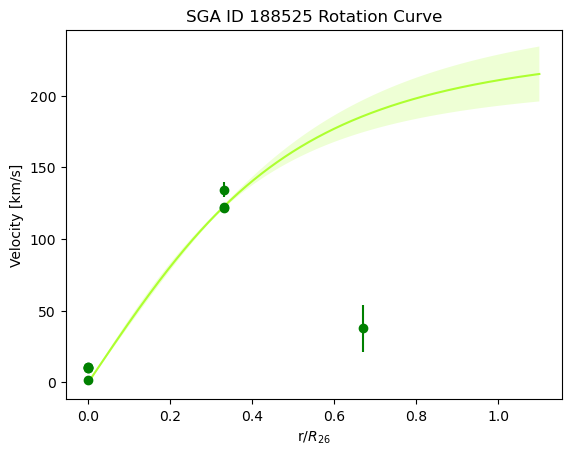

[26.80815475  0.09204949  0.23293221]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


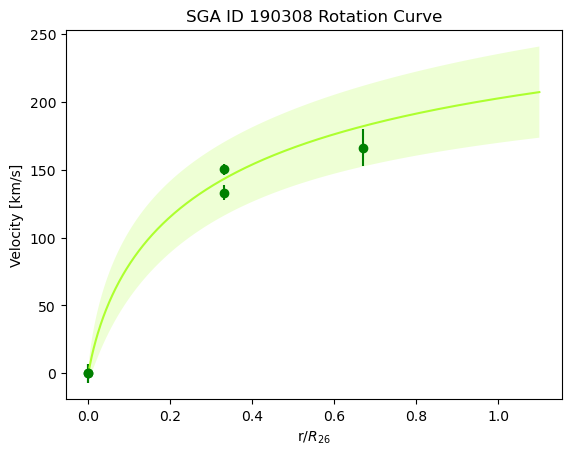

[76.11720572  0.16627723  0.19694545]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


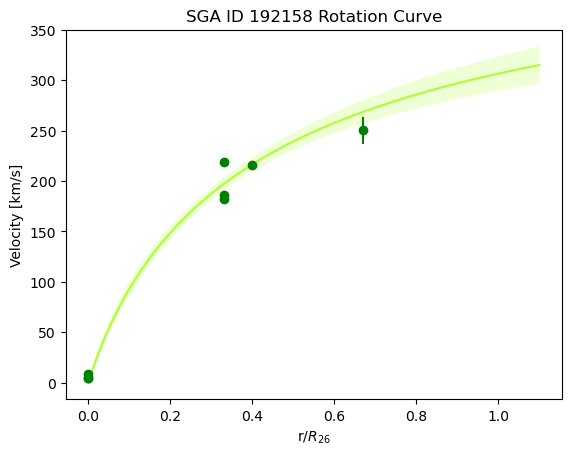

[66.51777327  0.08078886  0.11296312]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


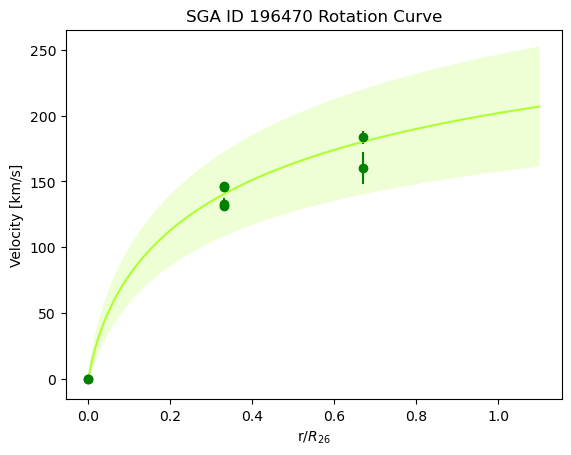

[1.12097753e+02 9.82511134e-02 2.40626404e-01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


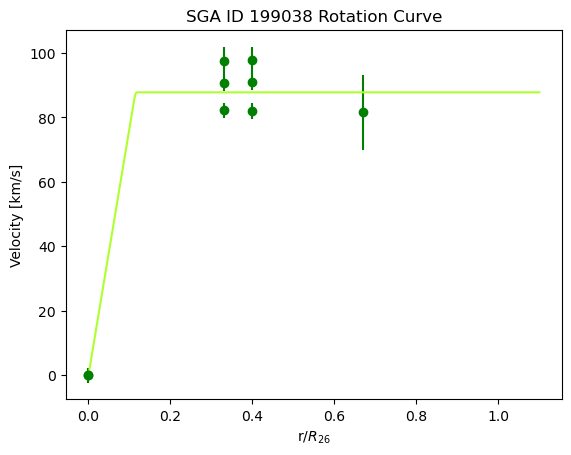

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


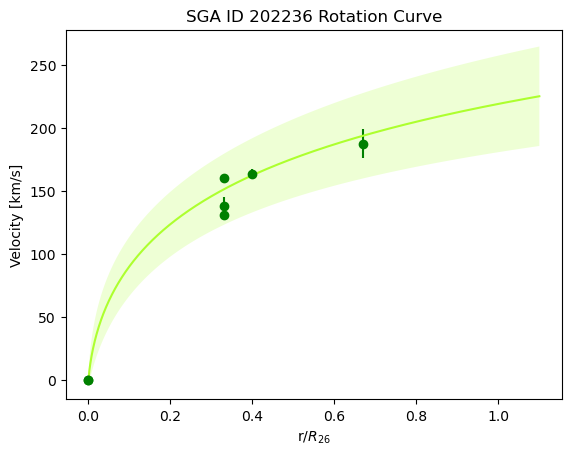

[1.57083781e+02 1.27804722e-01 5.75023548e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


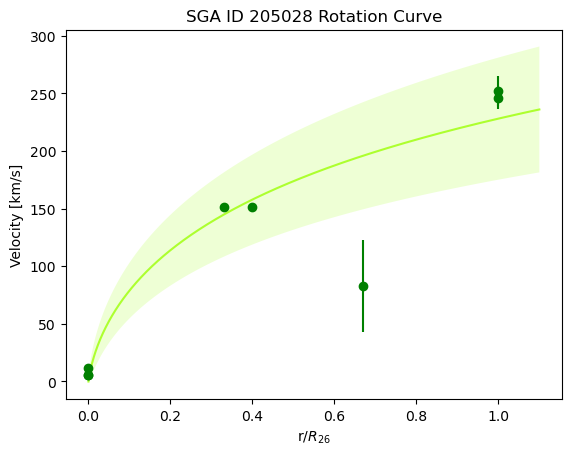

[3.37413670e+02 8.23795292e-02 8.88826731e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


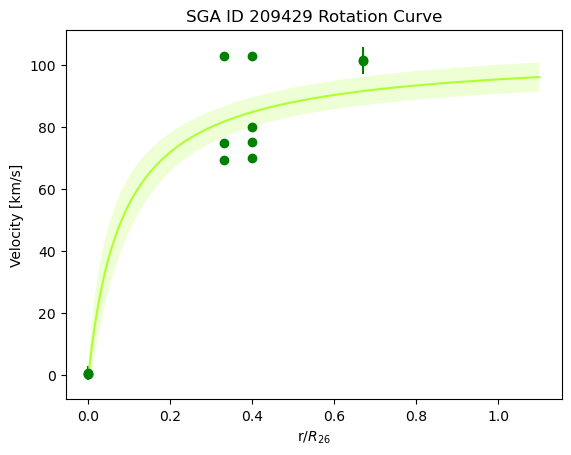

[8.6073819  0.02814907 0.33931032]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


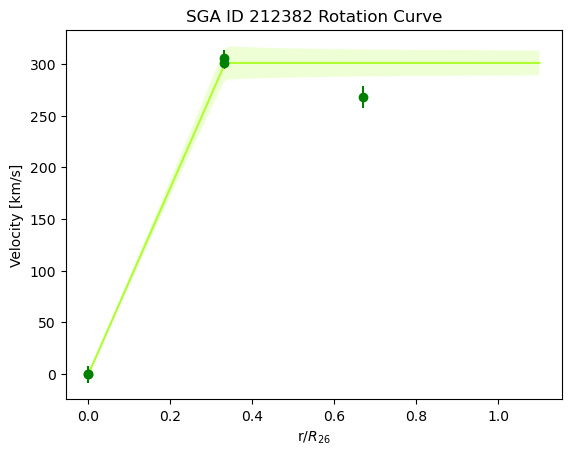

[6.82019515e+00 8.37999445e-03 1.06523805e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

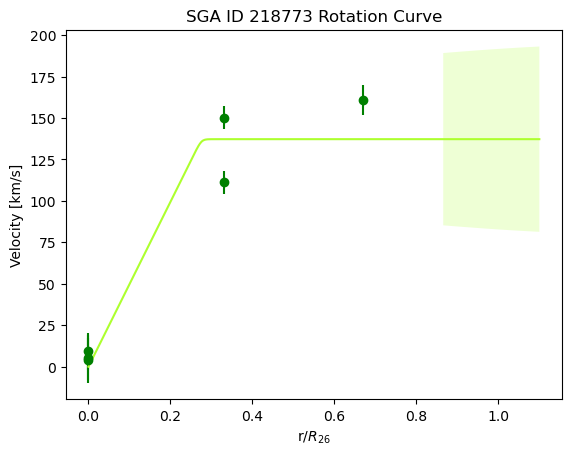

[4.23680722e+00 3.37973219e+00 3.78672939e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


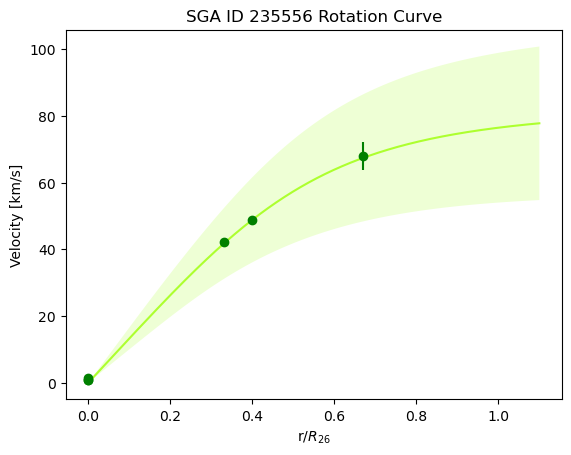

[45.07967618  0.23060623  4.55204013]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


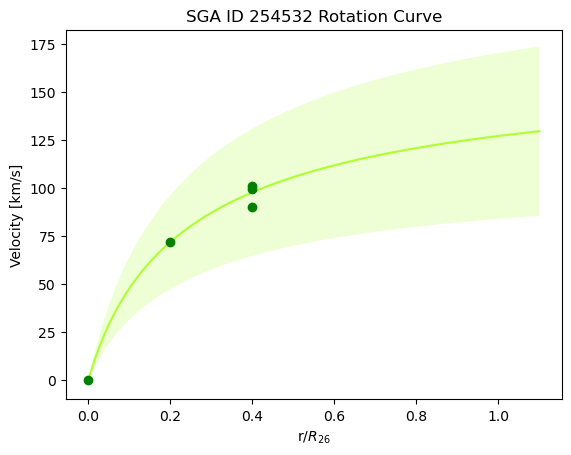

[1.58344767e+03 8.07950561e-01 1.22592671e+01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


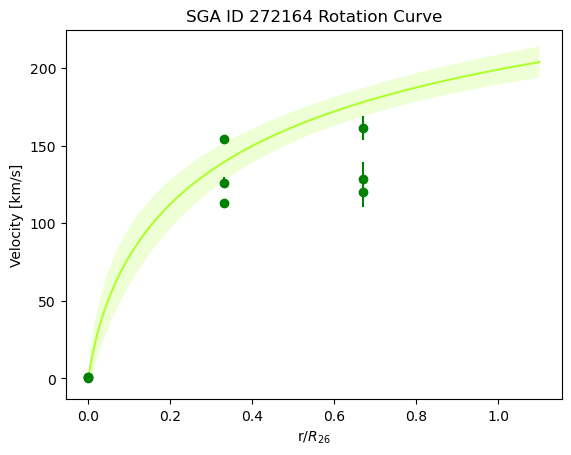

[16.52143555  0.07398859  0.03109169]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

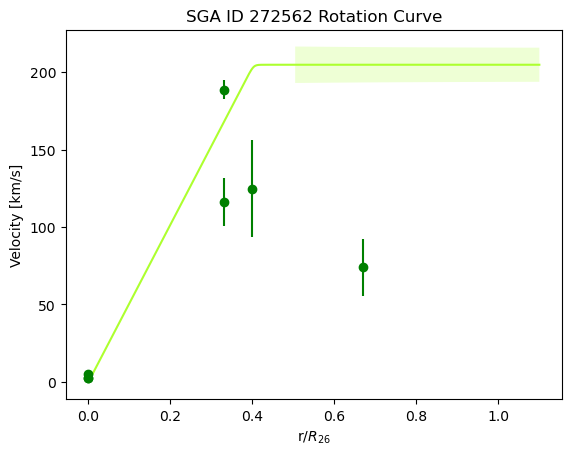

[9.17438867e+00 2.67492323e-02 2.24910140e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

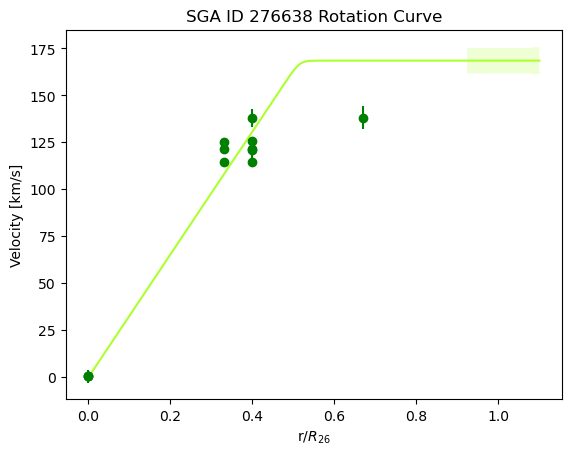

[6.02346664e+00 1.86971179e-02 2.04760156e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


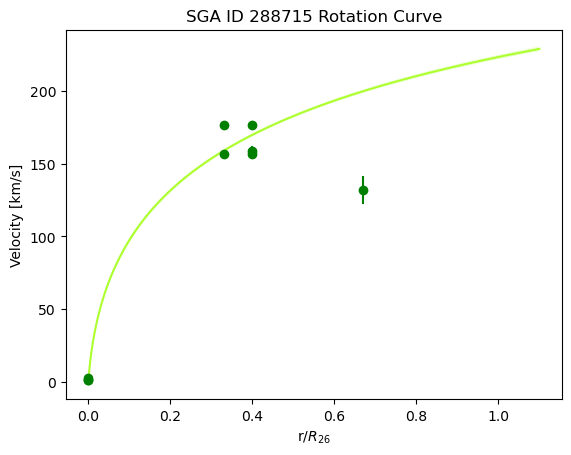

[1.52846495e+01 7.70036311e-03 7.12067543e-03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


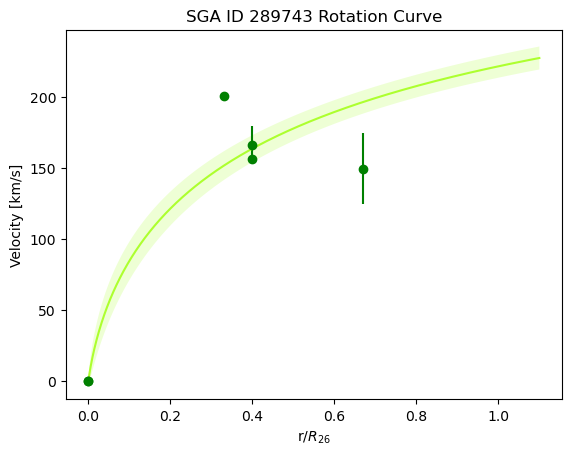

[1.04489775e+01 3.47214767e-02 1.55463437e-03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


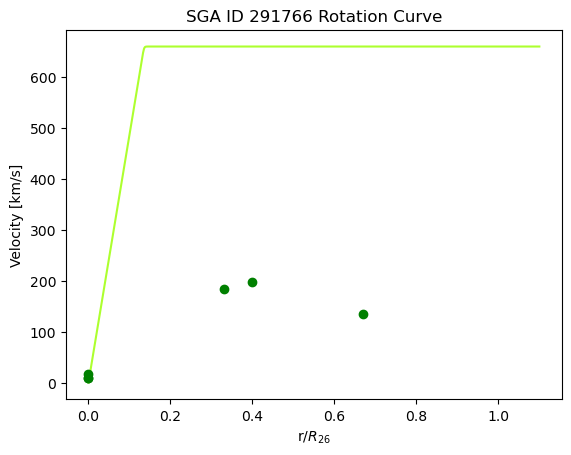

[7.62761890e-01 6.95485119e+02 1.48619675e+07]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


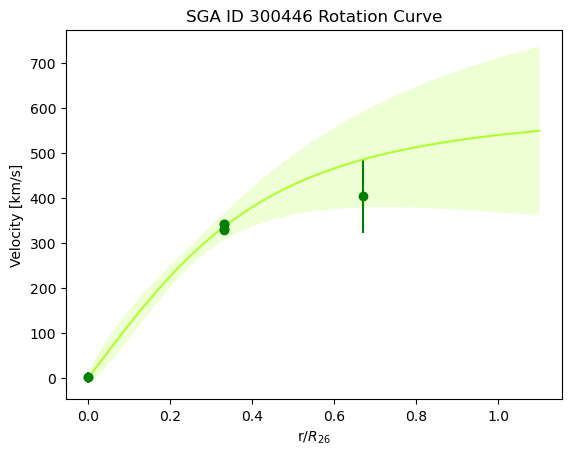

[399.95151869   0.51479872   0.67704524]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


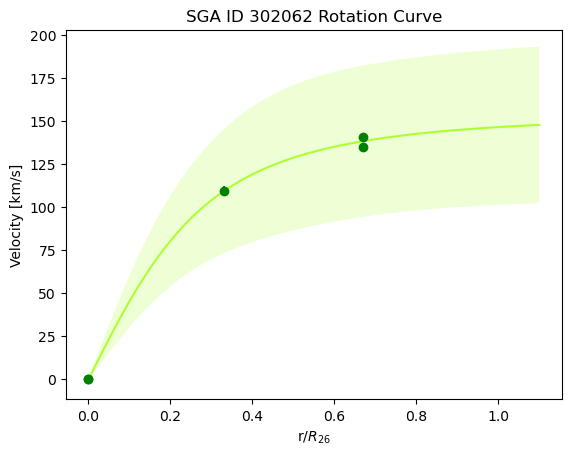

[3542.3189043    13.68756531  240.68540268]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


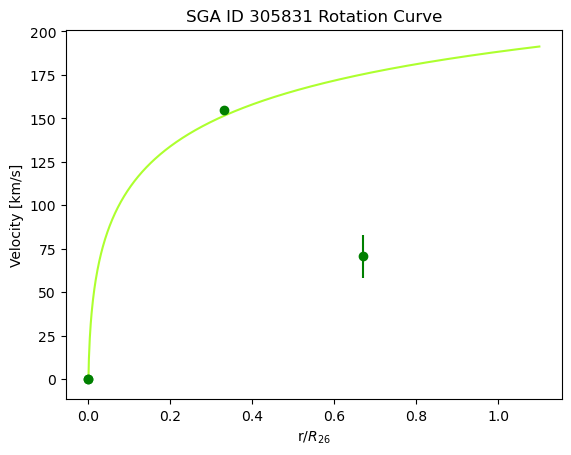

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


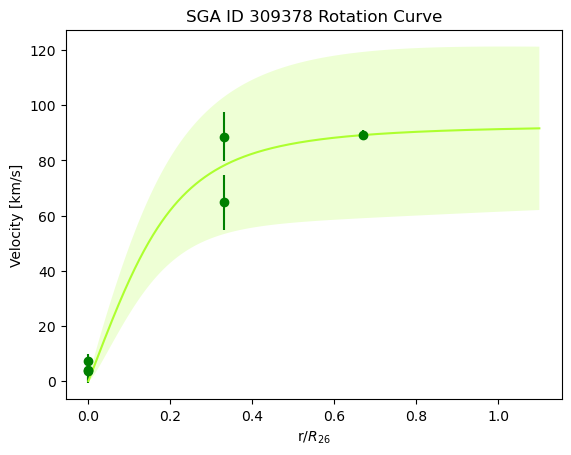

[110.30585637   2.29021293  35.1940839 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


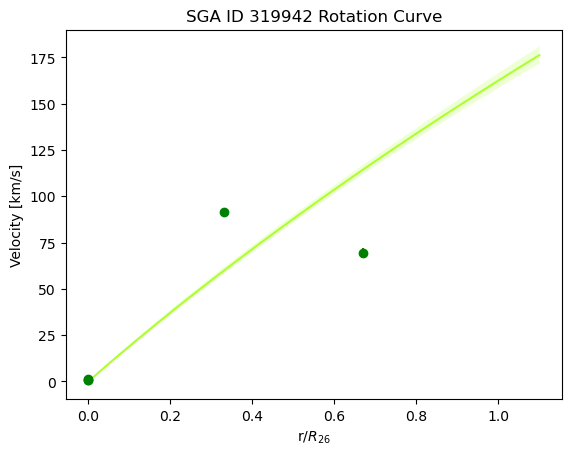

[9.62605922e+01 7.88571021e-01 4.98108916e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


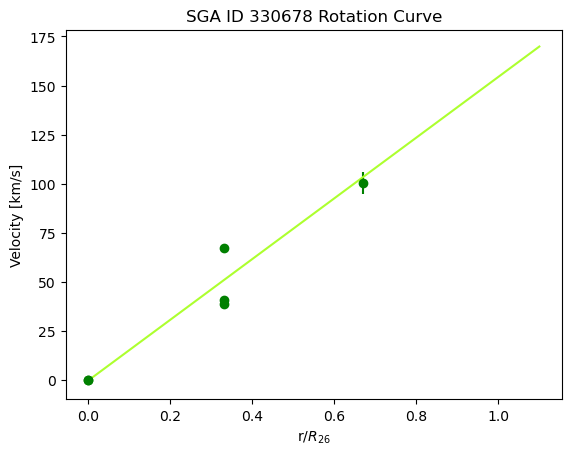

[1.25537872e+01 1.01594997e-04 2.30009470e+09]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

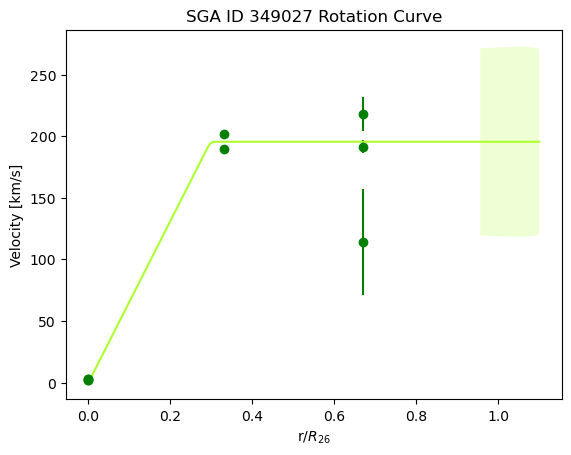

[1.64824643e+00 3.09947135e+00 9.24529614e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


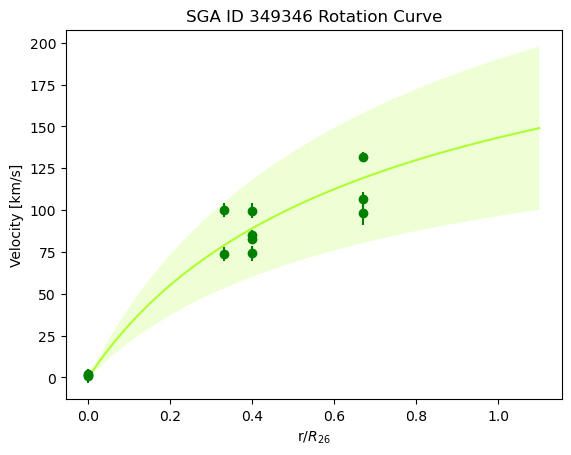

[2.16561166e+02 8.78524181e-02 9.08163777e-01]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


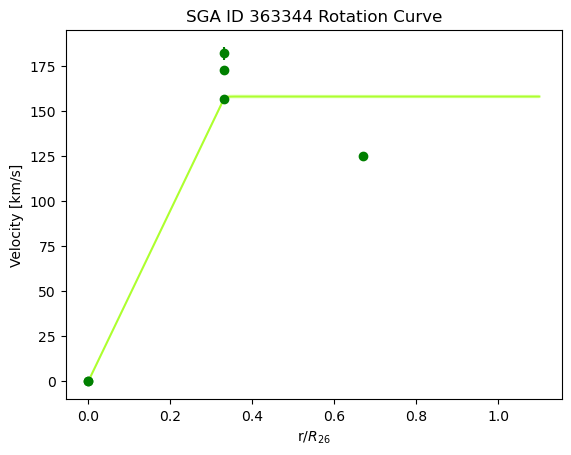

[9.87165841e-01 2.18263923e-03 2.70268140e+01]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


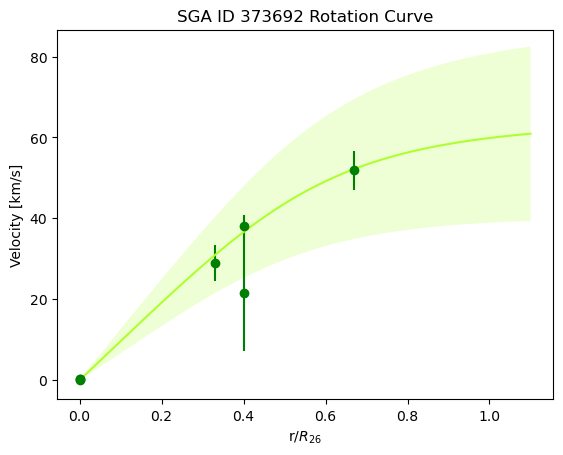

[453.71860151   3.6391202   66.15346026]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


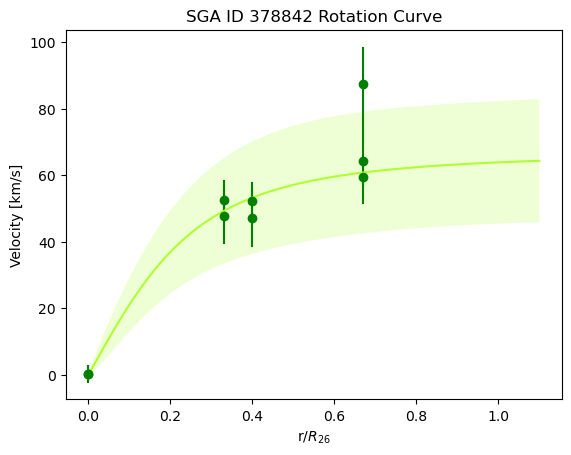

[38.20053466  0.50180736  7.2614076 ]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


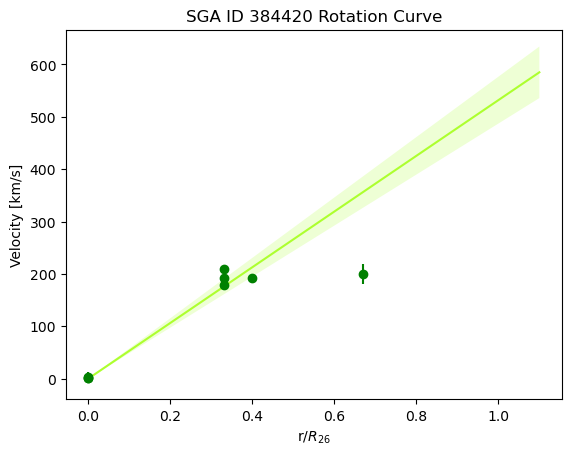

[9.36245739e+06 1.76035092e+04 6.69950509e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


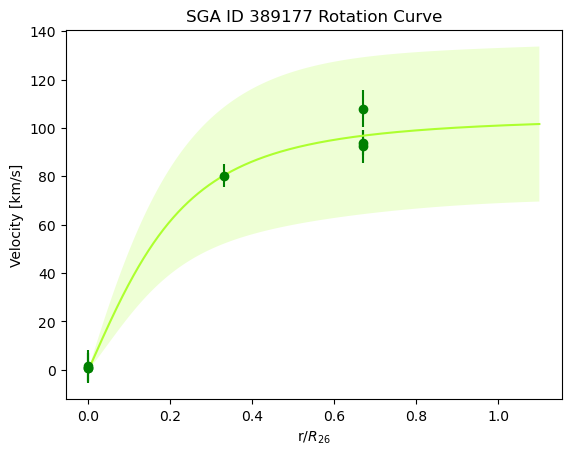

[3023.43728793   28.79265821  411.3430182 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


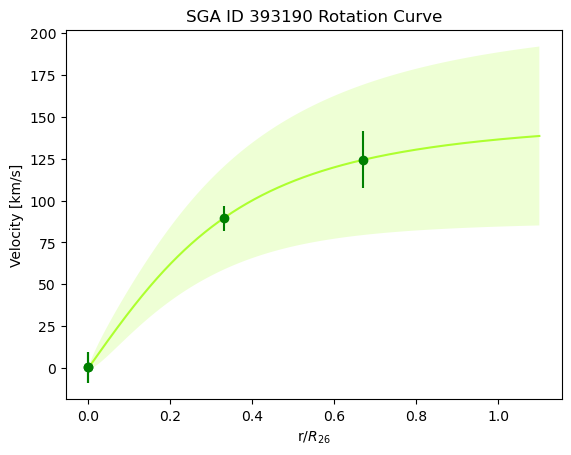

[2.19353701e+04 1.52730742e+01 9.14487137e+02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


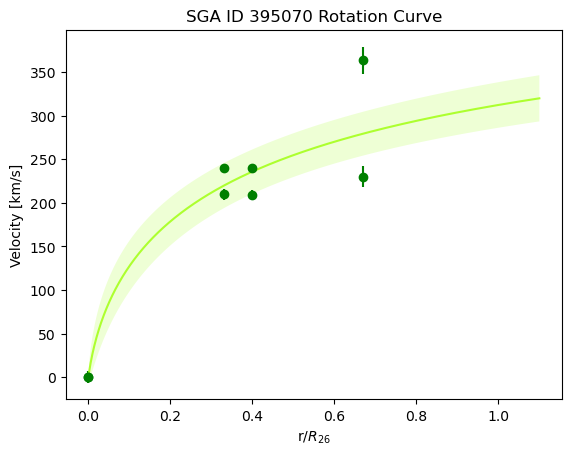

[8.83136137e+01 6.90654323e-02 8.64137636e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


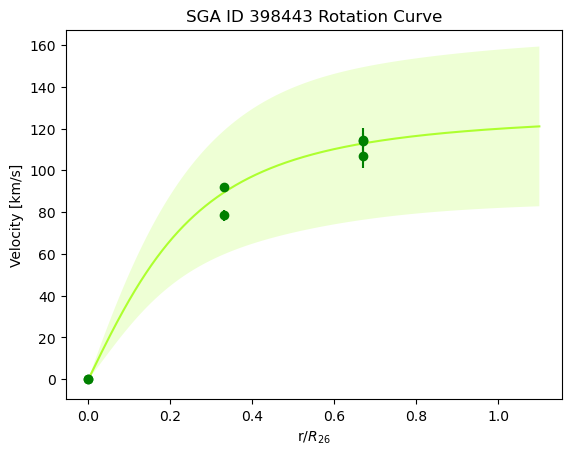

[1110.4891701     5.14860565   79.6441091 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


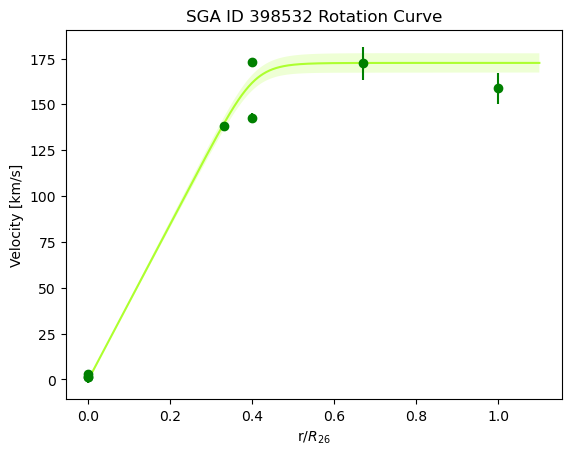

[4.50723723 0.01169603 3.64255696]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


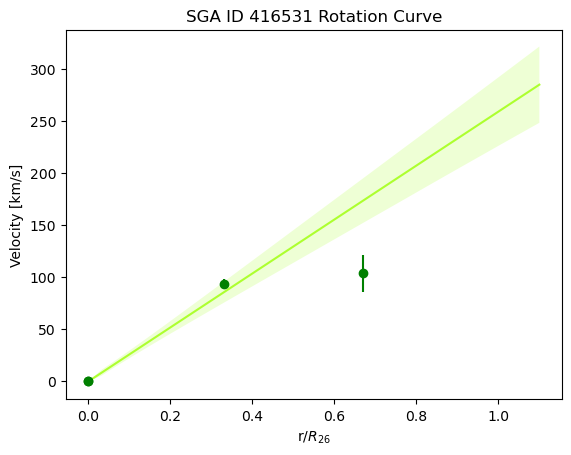

[30536.95273961   117.83954831    74.11515348]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


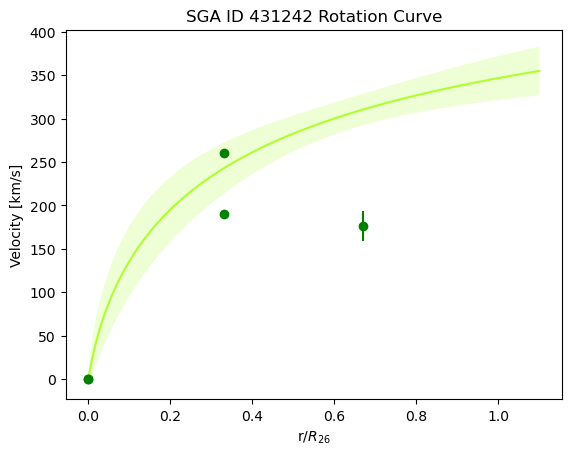

[35.23203319  0.16178005  0.12339032]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/2

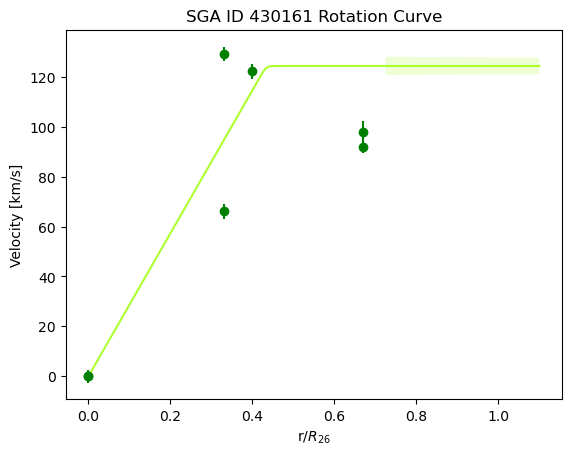

[2.10152900e+00 1.07558766e-02 6.23913148e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


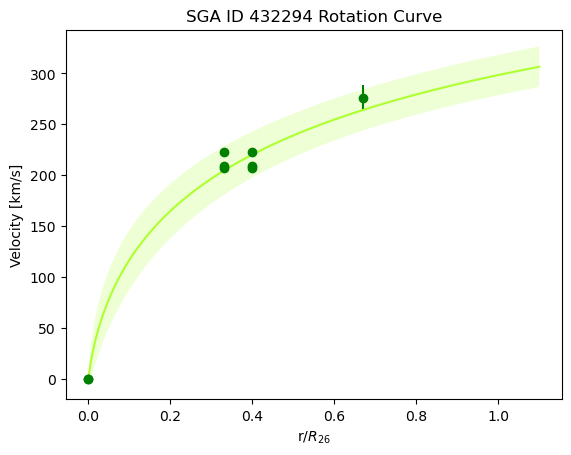

[38.80847489  0.08057643  0.03979827]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

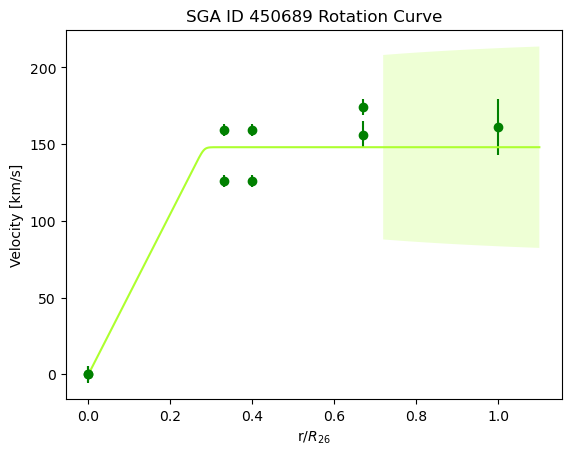

[1.78111629e+00 1.22149631e+00 1.54430039e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


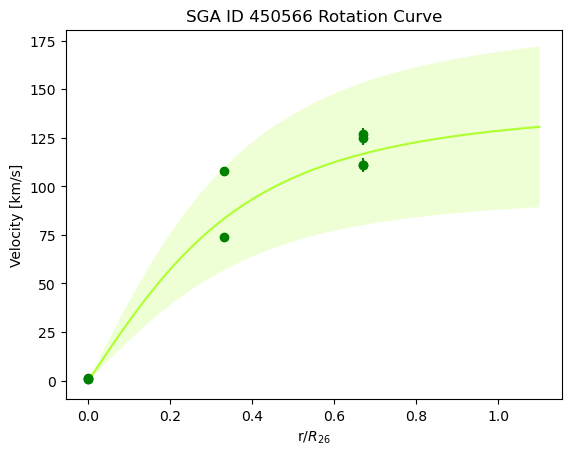

[2.16096538e+02 9.23806820e-02 9.41184531e+00]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


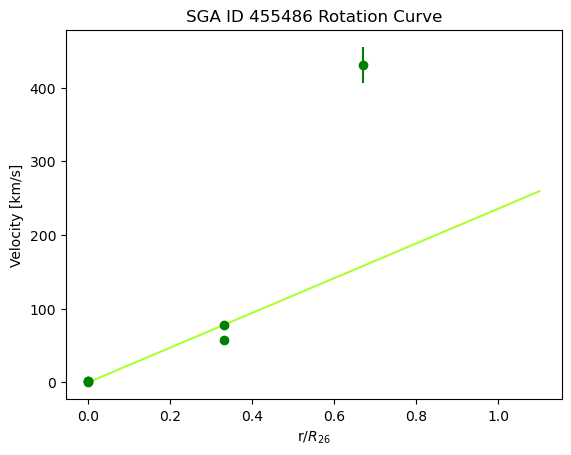

[1.23124691e+08 5.22337075e+05 4.35087027e+07]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


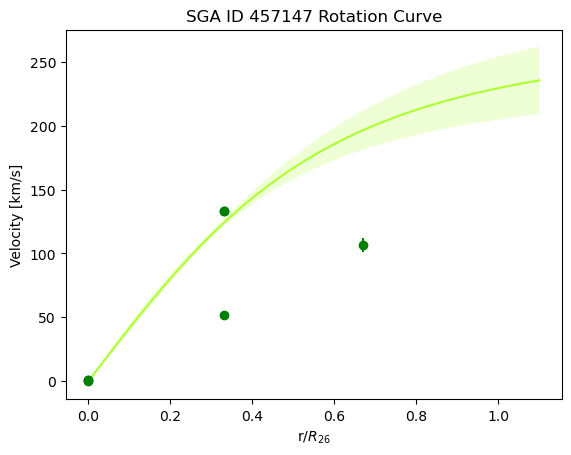

[33.15387179  0.13323354  0.34169225]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


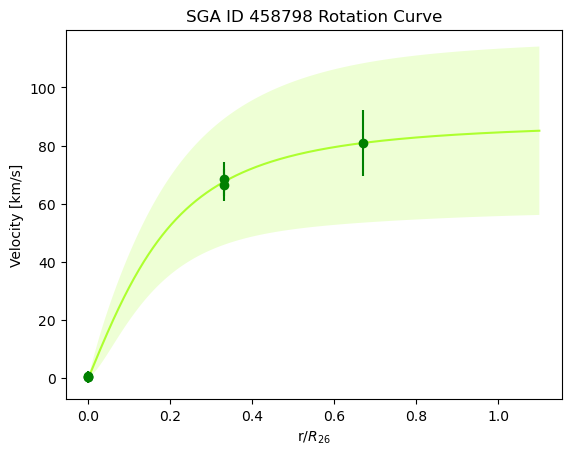

[2060.01656234   23.25751801  292.1489794 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


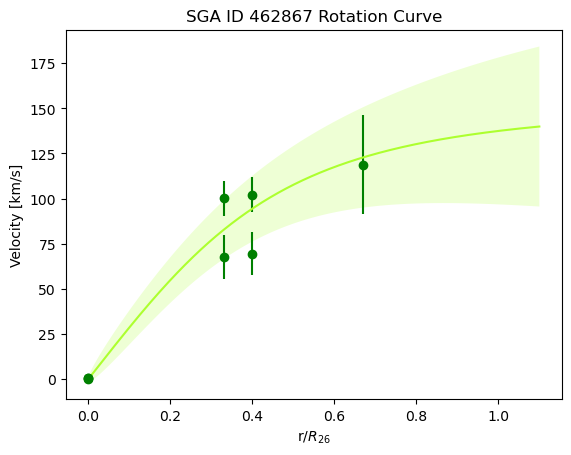

[73.59537078  0.55346756  0.98352598]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


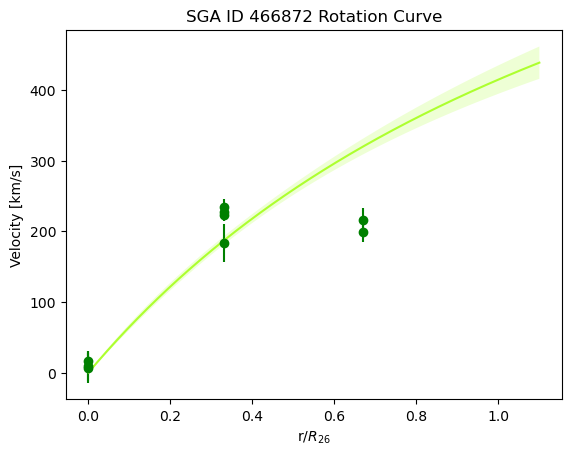

[1.22147940e+02 2.73932023e-01 1.13117899e-01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


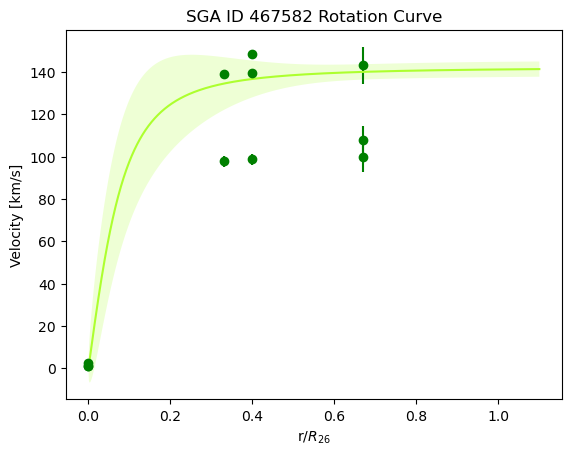

[3.15781    0.16298386 1.76223587]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


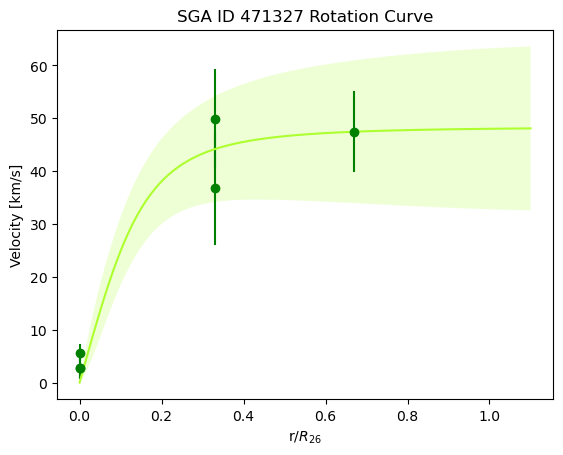

[1299.61950437  111.89519186 1602.73377756]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


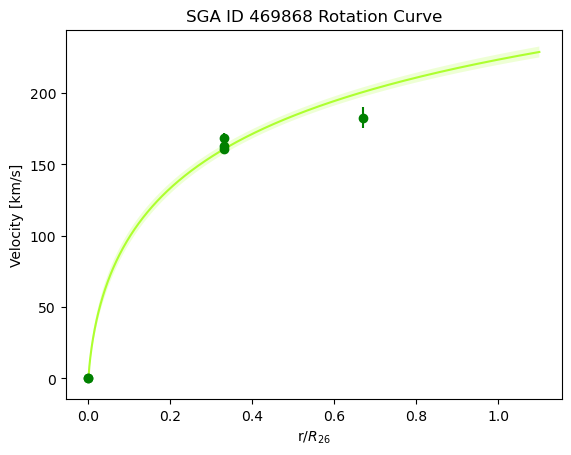

[2.57277503e+01 1.52530623e-02 1.38103584e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


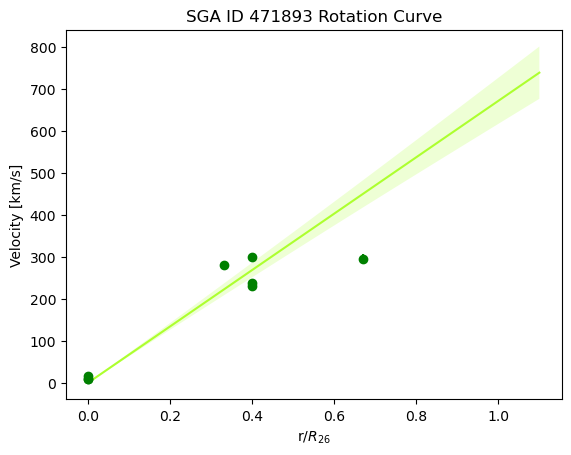

[102421.426988      152.69010336    128.15900963]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


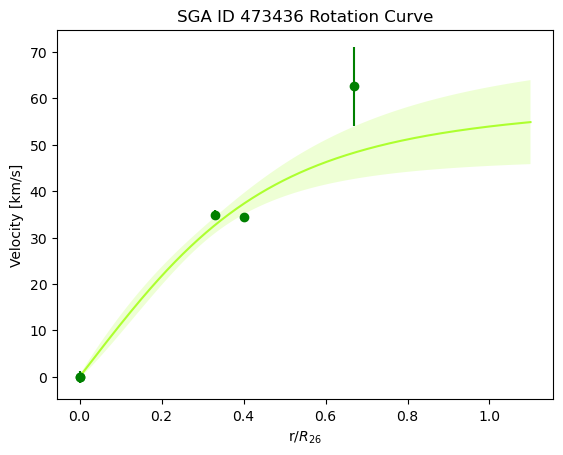

[12.30754384  0.17337375  0.53469476]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


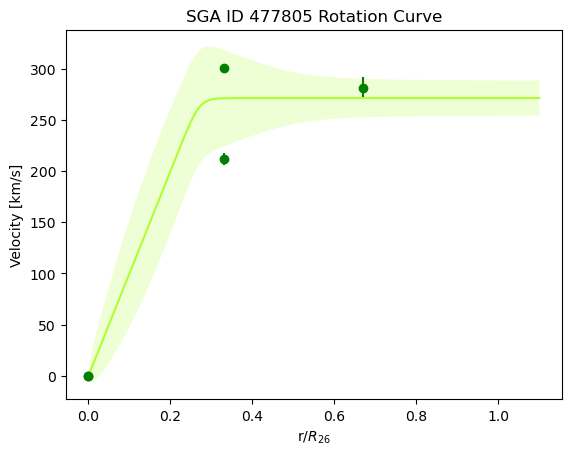

[ 2.97274366  0.16956096 52.95812224]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


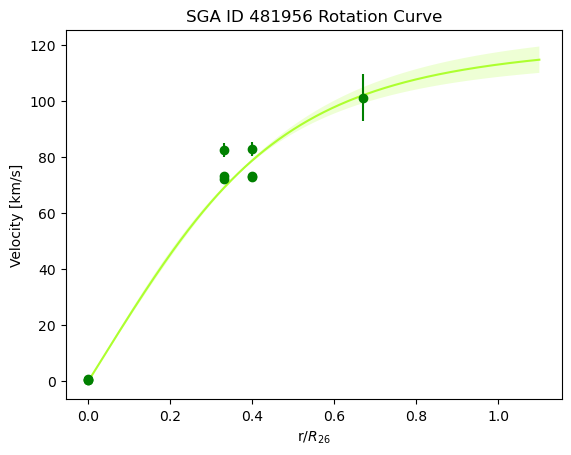

[5.97912424 0.0416731  0.18991604]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


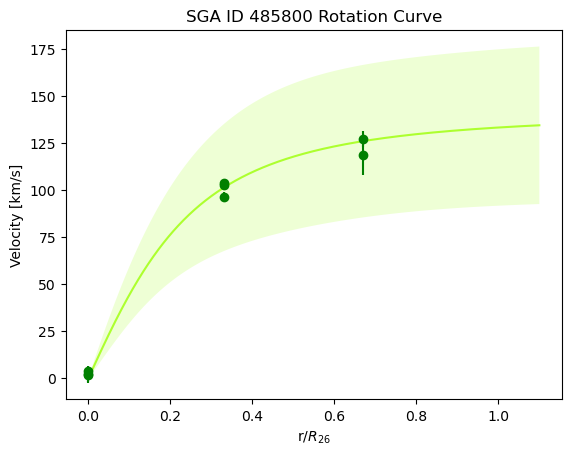

[164.44616549   0.8036773   11.29715116]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


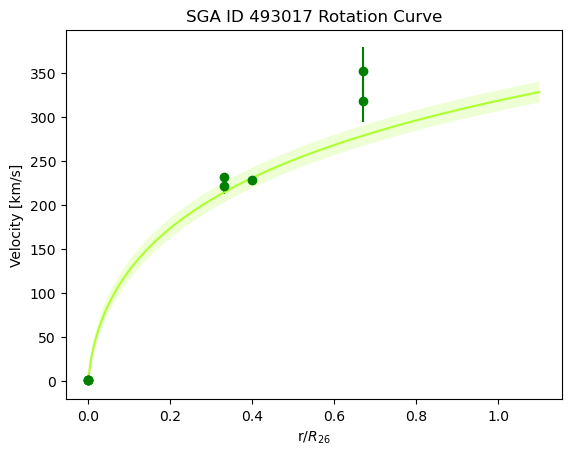

[9.06911316e+01 2.43159816e-02 1.01224173e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


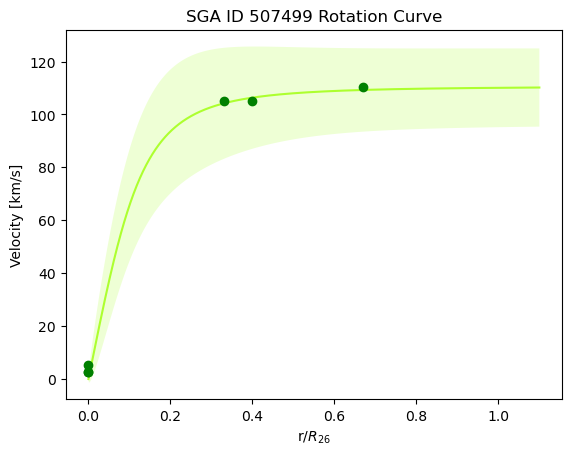

[6.82507364 0.26390164 4.06018179]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


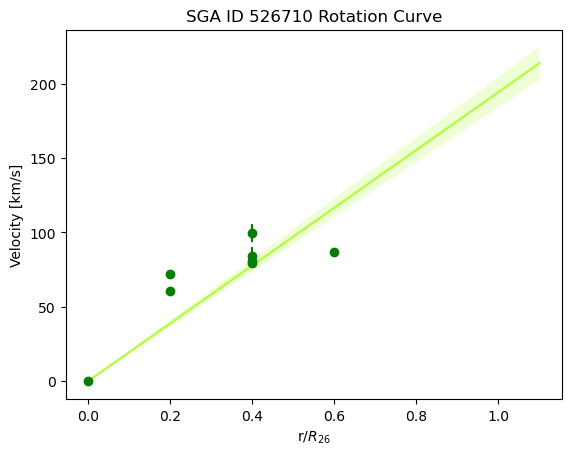

[2957498.20798046   15210.04712885   40435.50967084]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

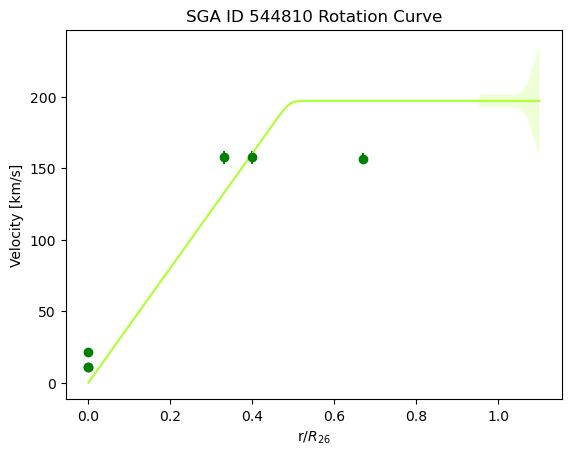

[3.78831058e+00 1.51514498e-02 3.61025219e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


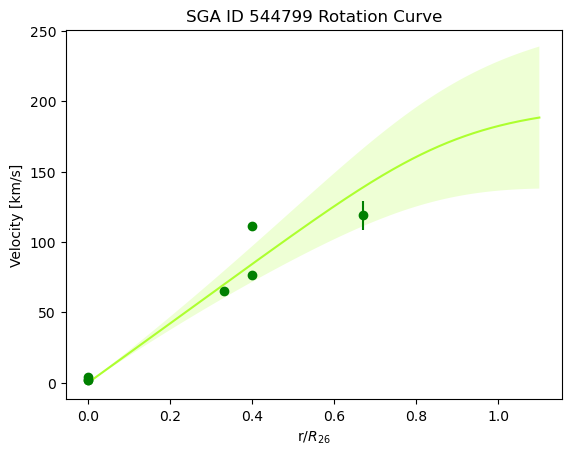

[84.35423866  0.40001822  0.3285004 ]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


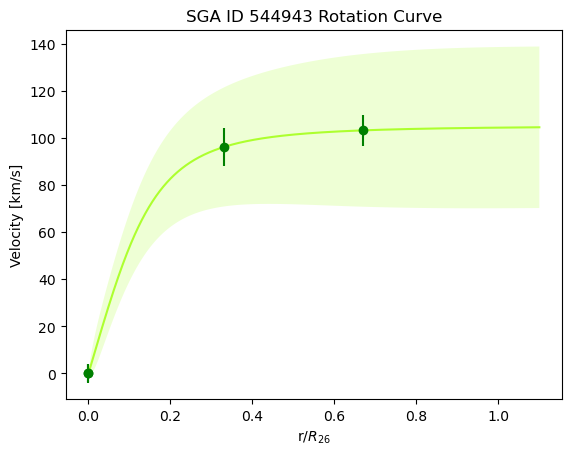

[5795.4562042   239.11901531 3517.28050238]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

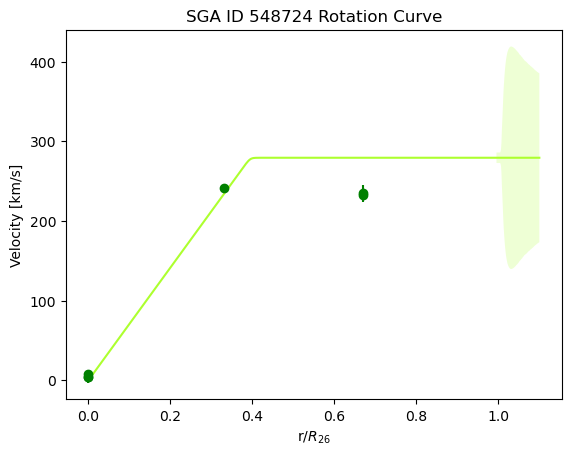

[6.56598042e+00 1.16165345e-02 3.38309670e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


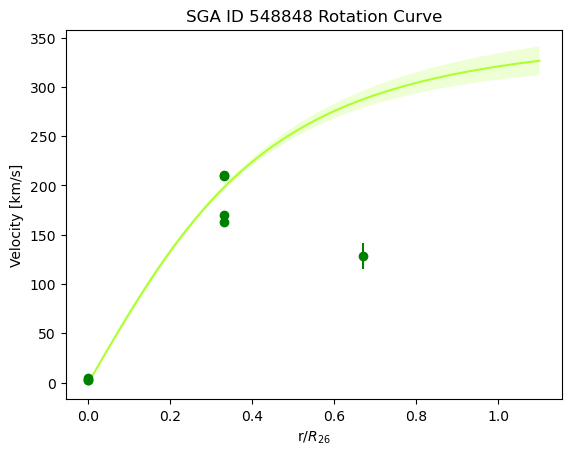

[2.62664695e+01 1.98013216e-02 7.40313747e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


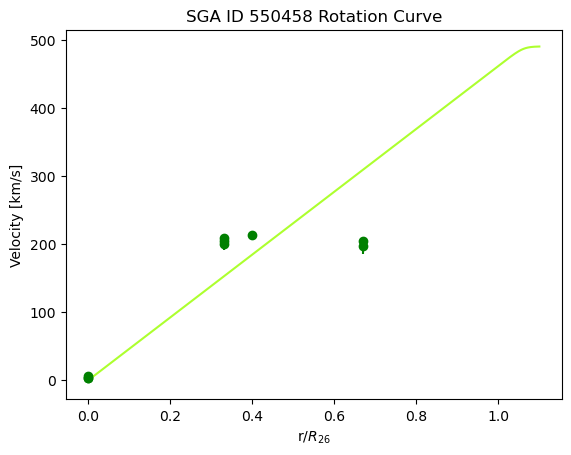

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


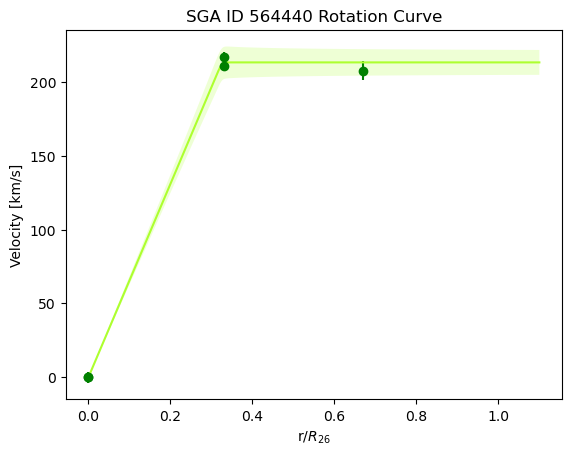

[2.79122183e+00 6.79671843e-03 1.40178148e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


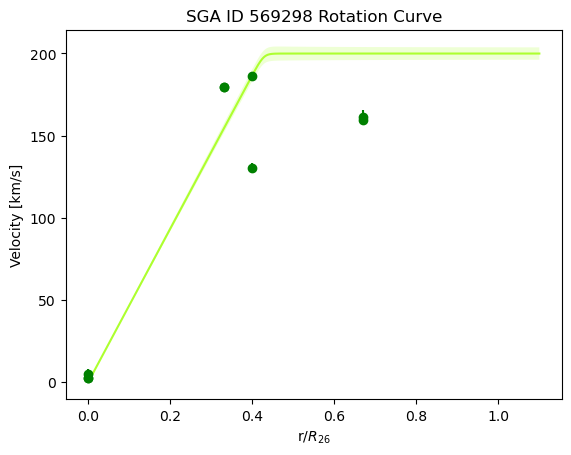

[2.02668667e+00 5.25934600e-03 2.00291200e+01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


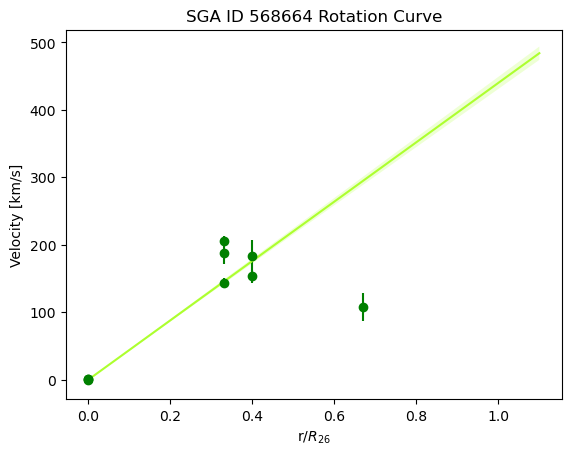

[2937857.31012347    6675.08535327  138536.51270063]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


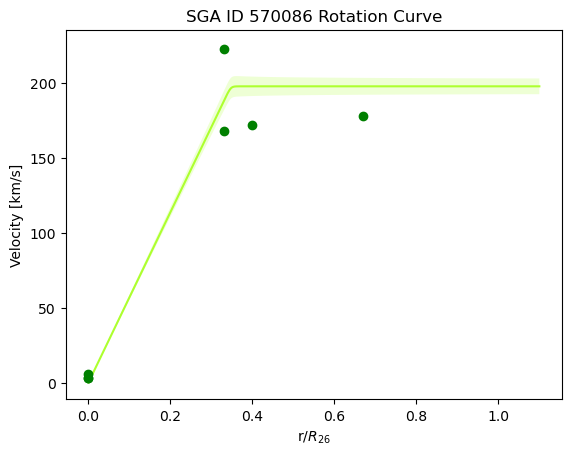

[1.41091444e+00 3.43434797e-03 5.33055822e+01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encounte

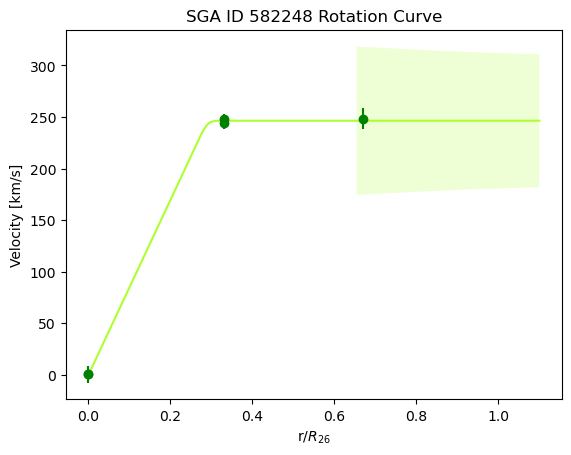

[3.30447374e+00 7.82476952e-01 8.20490722e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


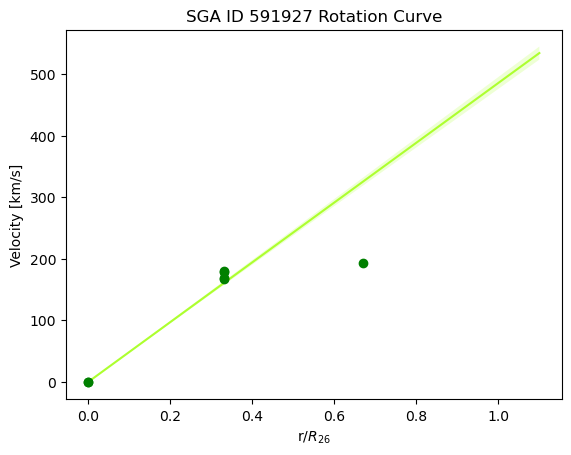

[2960144.85723527    6090.27699689 1233317.55870242]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

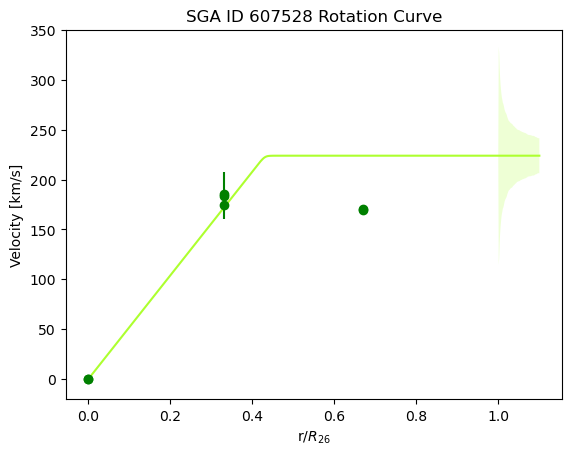

[2.59137980e+00 7.09293082e-03 9.44856639e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


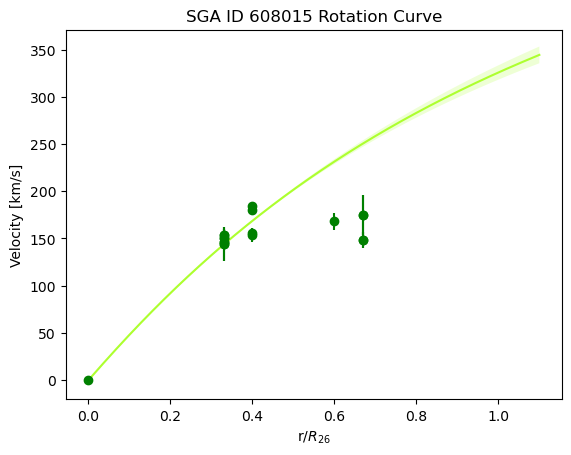

[46.73685627  0.10908079  0.06257383]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


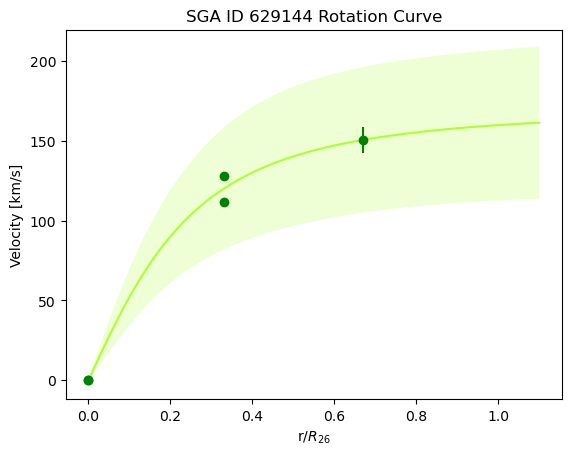

[101.94020133   0.37240575   5.36764417]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


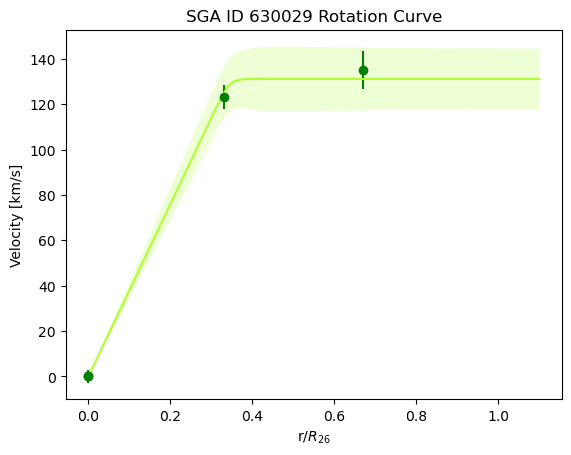

[9.16358861e+00 3.02258302e-02 5.25255886e+01]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, c

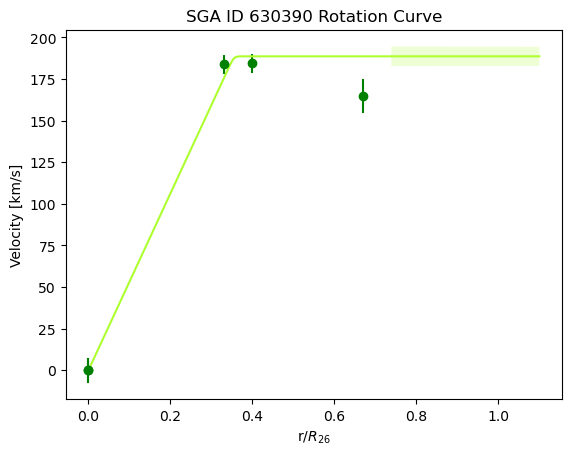

[5.10441218e+00 1.60133516e-02 6.97039812e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


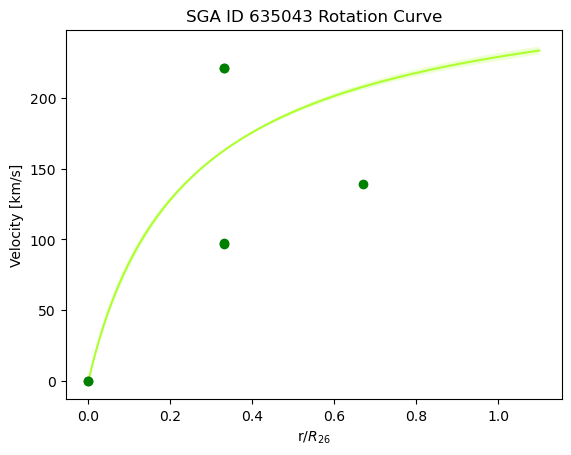

[3.53323087 0.01761692 0.01560901]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

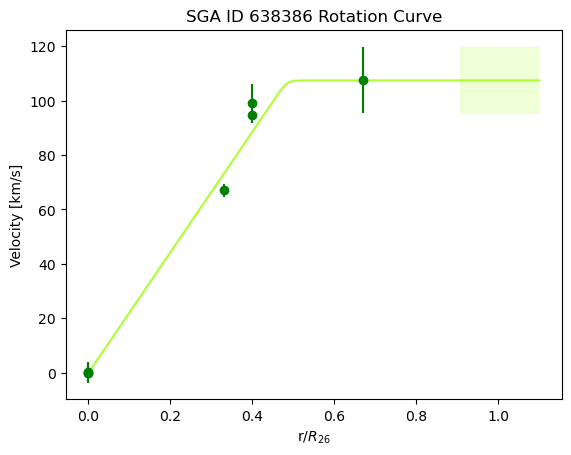

[1.21095246e+01 5.56565474e-02 1.78286287e+03]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


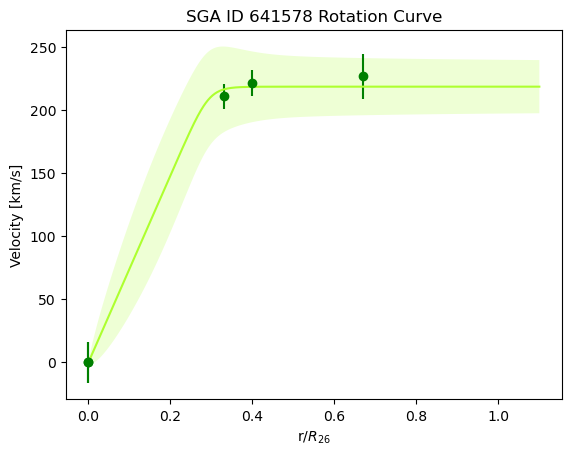

[ 5.07204426  0.08060378 20.82045286]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


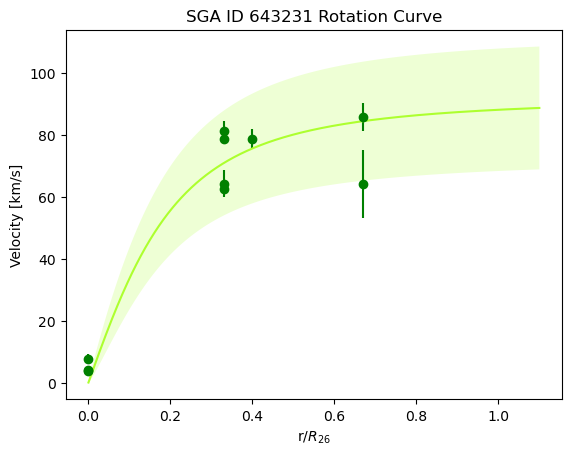

[16.12205172  0.17011095  1.95783   ]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

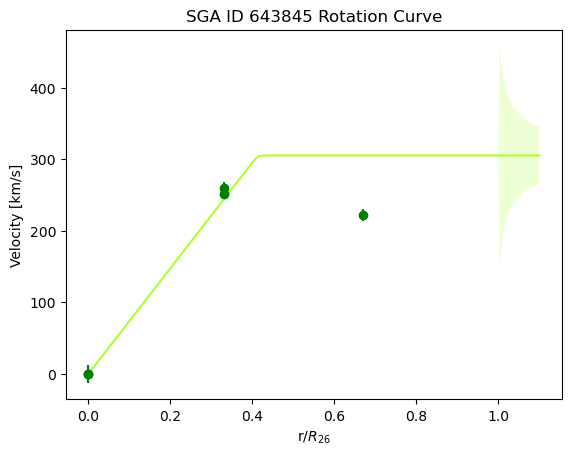

[8.39556948e+00 1.52883882e-02 3.16719403e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


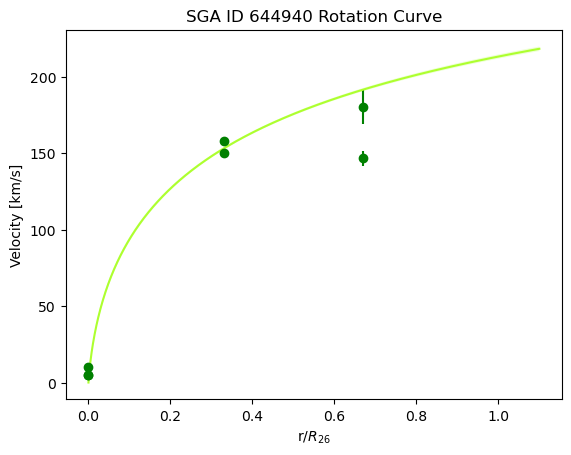

[1.04583593e+01 7.59677338e-03 7.07359042e-03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


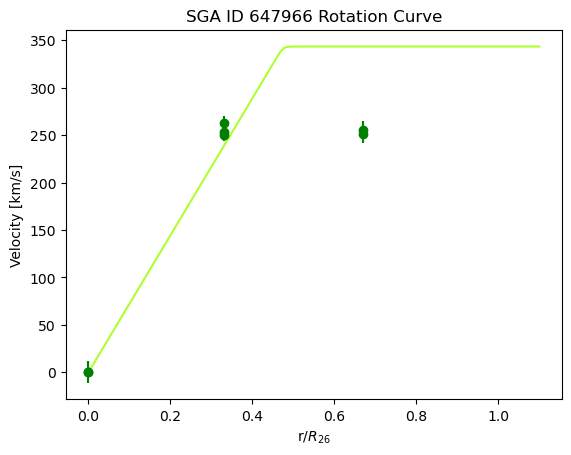

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


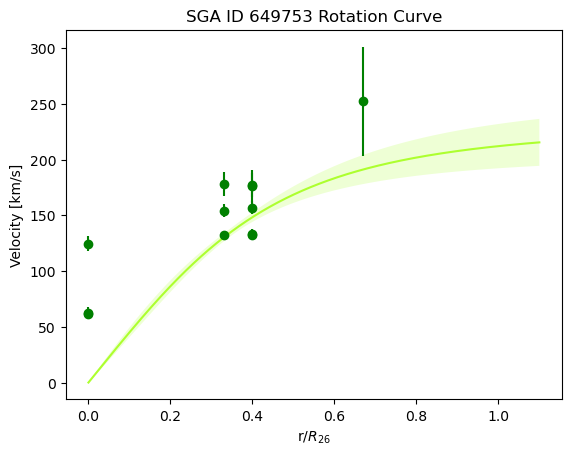

[27.11987695  0.10336104  0.41972328]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


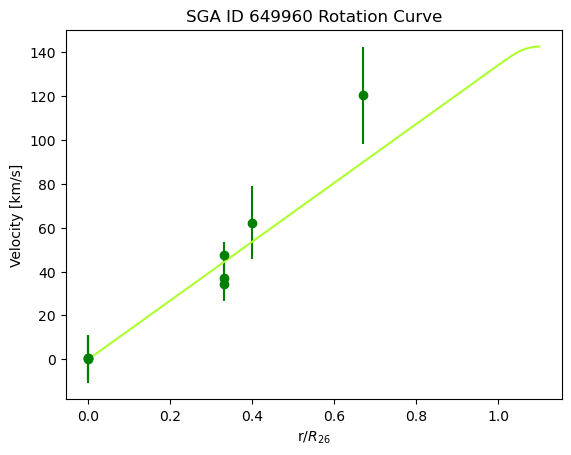

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


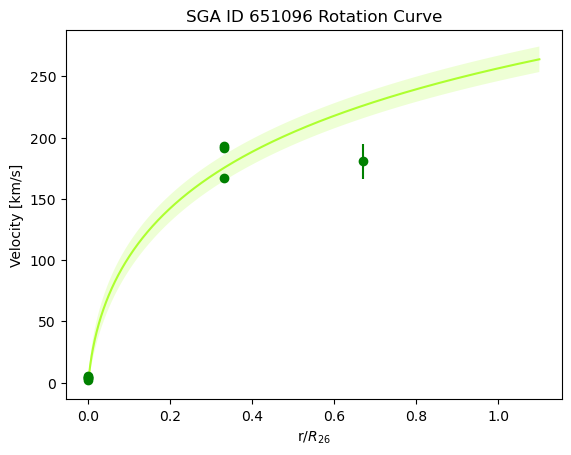

[5.44911134e+01 2.76636931e-02 1.34732016e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


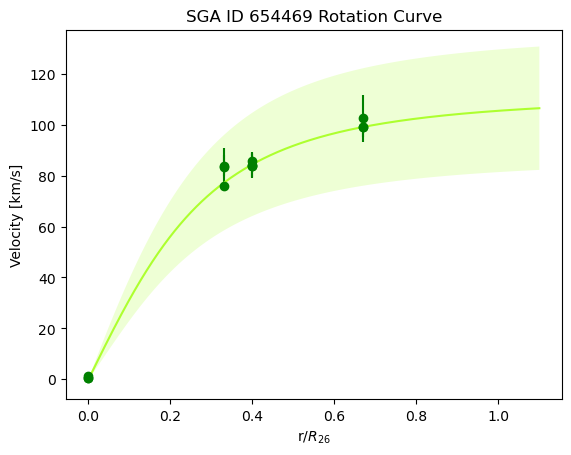

[21.77089518  0.11075829  1.89957703]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


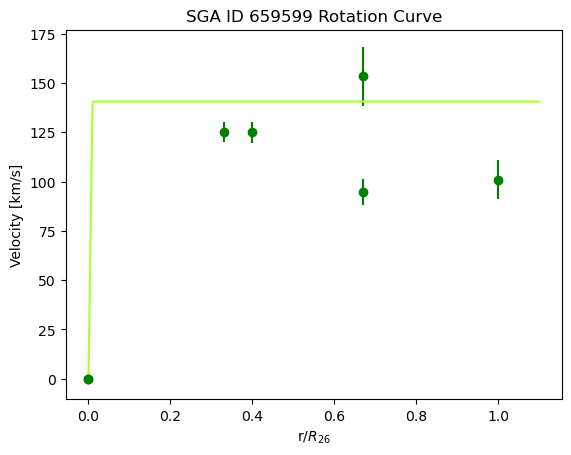

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


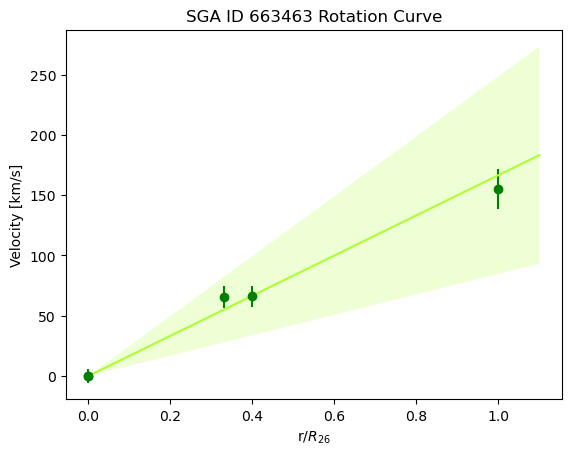

[65672.48288048   394.2951919    504.38584942]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

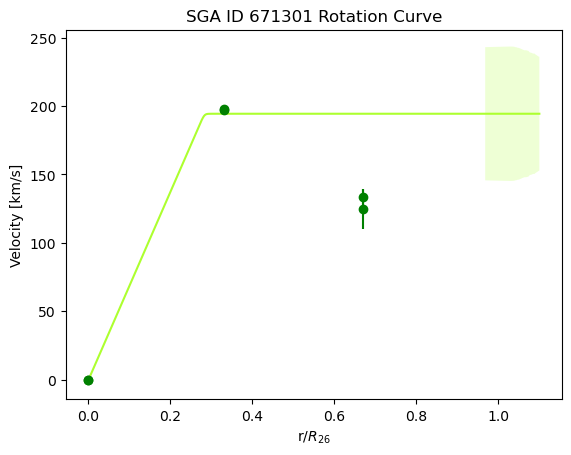

[1.20192757e+00 8.77484070e+00 1.90140239e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

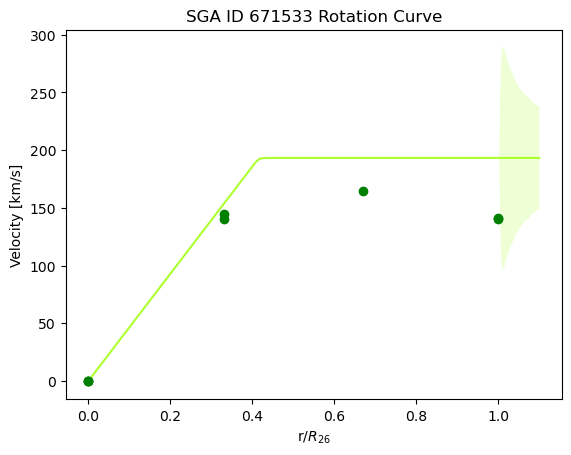

[1.09472078e+00 3.22950834e-03 9.14960220e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


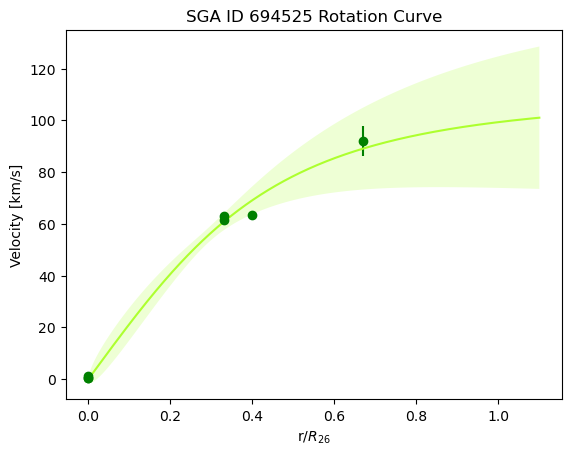

[46.00420205  0.35945831  0.54367924]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

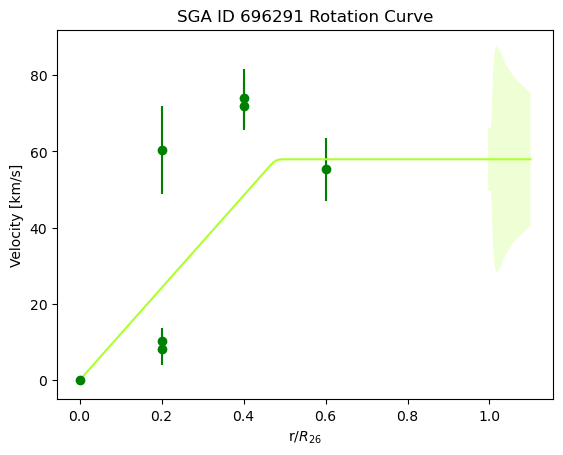

[8.28899695e+00 7.95174449e-02 5.78386143e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

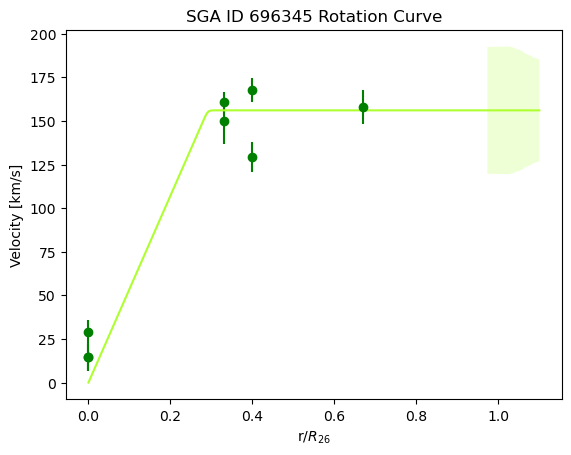

[3.47794667e+00 9.73124241e+00 2.47032827e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


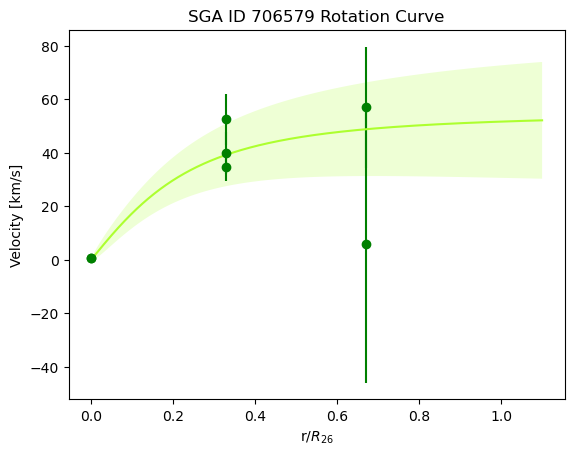

[66.59263422  0.79261554 12.79101016]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/ma/core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


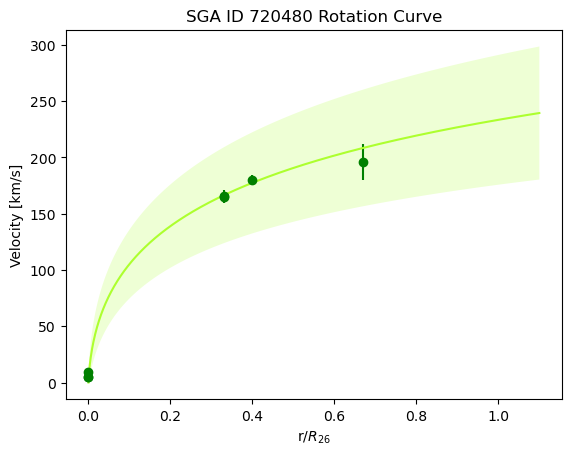

[2.97885637e+02 4.04229090e-02 7.47309406e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


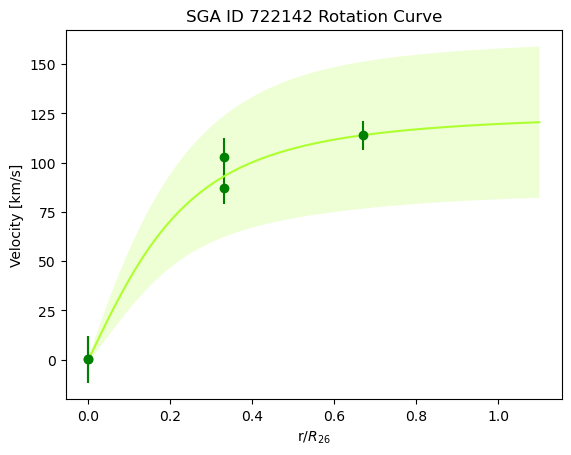

[339.23957634   2.24376326  32.37556545]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

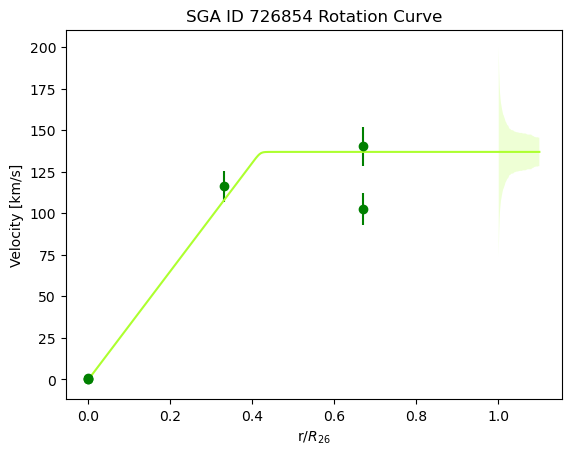

[7.45726804e+00 4.70037756e-02 1.95727184e+06]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


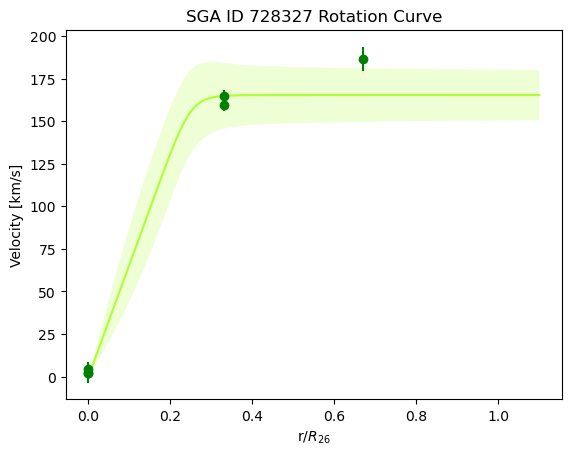

[1.98455586 0.07173622 8.85222743]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


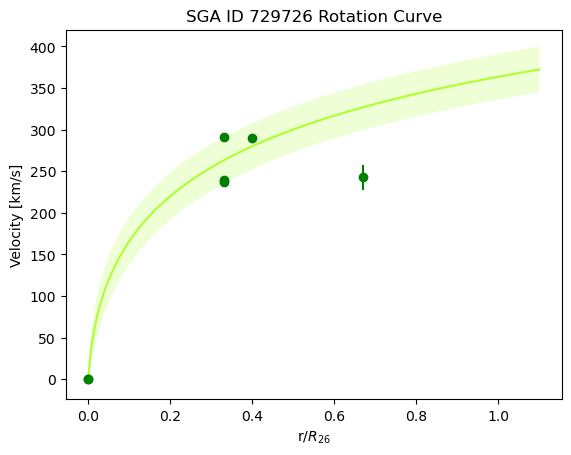

[1.19944784e+02 2.31600297e-02 3.56308000e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


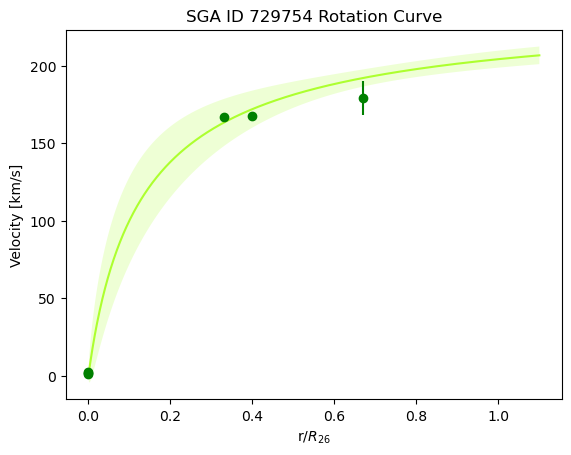

[5.1908794  0.05054476 0.07193312]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


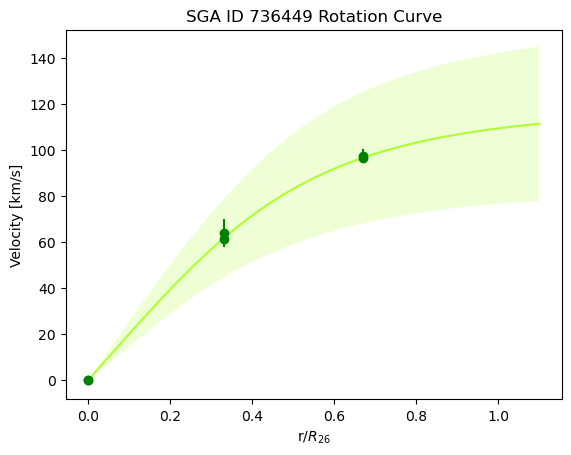

[1814.23966846    5.18855947  108.92008837]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


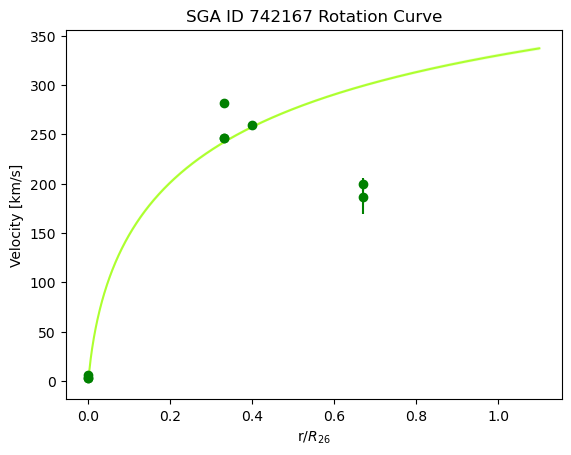

[9.51115529e+00 6.37200696e-03 7.02763143e-03]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


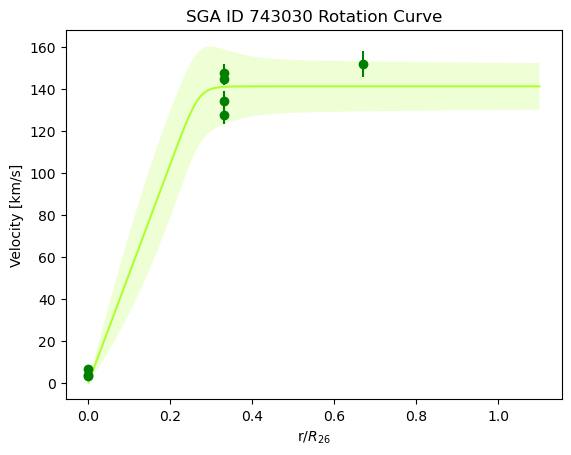

[ 1.71080697  0.09194106 21.96330858]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


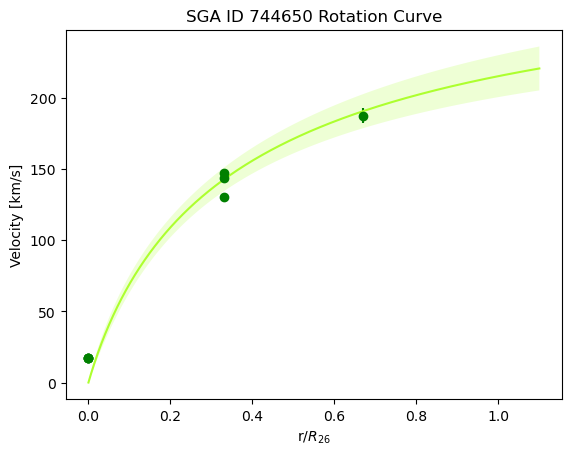

[44.14686452  0.07086551  0.16241346]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

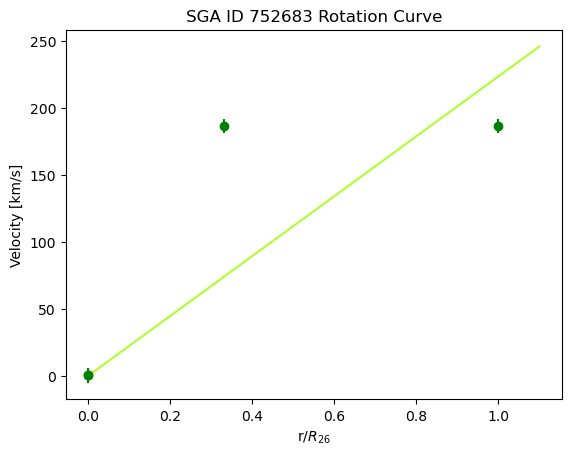

[2142921.29119479    9585.04475197 5763672.73124269]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


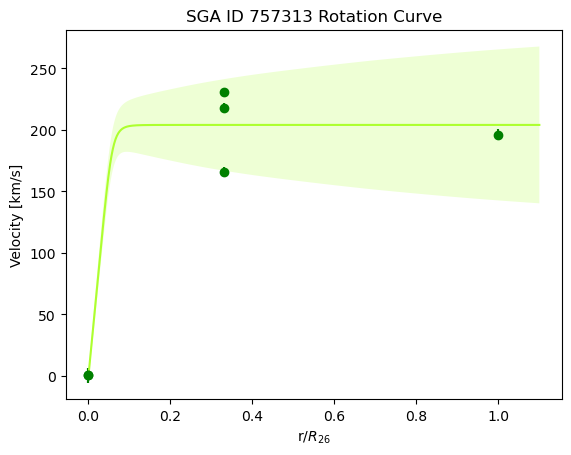

[  1.95000723   8.31765689 458.86219952]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

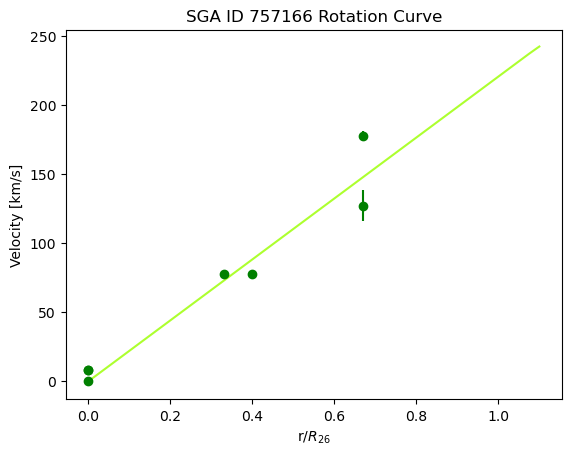

[6.22776425e+05 2.82479962e+03 5.53782366e+07]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages

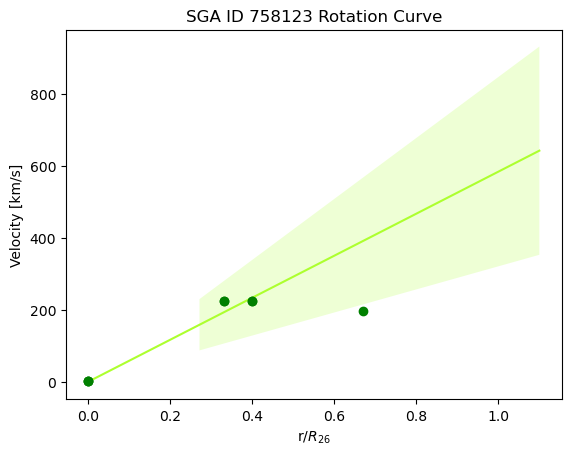

[674478.23013084   1156.5126354     982.56018401]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

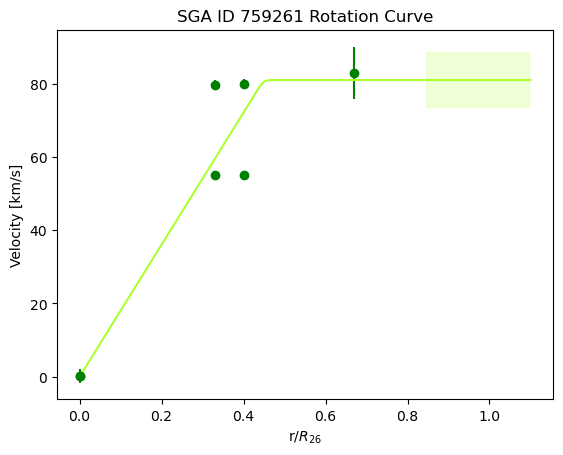

[7.19709073e+00 4.01088845e-02 1.06352519e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


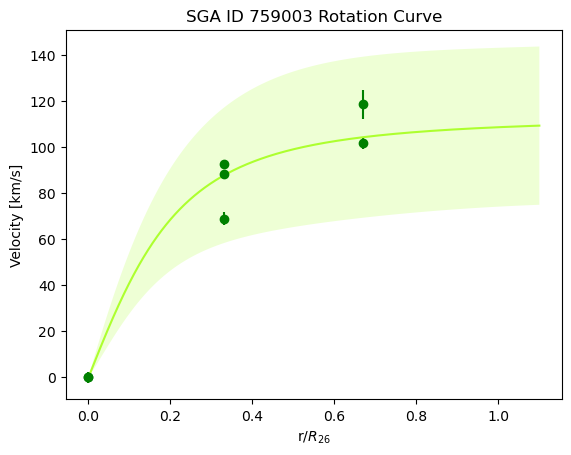

[328.62868285   3.17177085  40.13219444]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


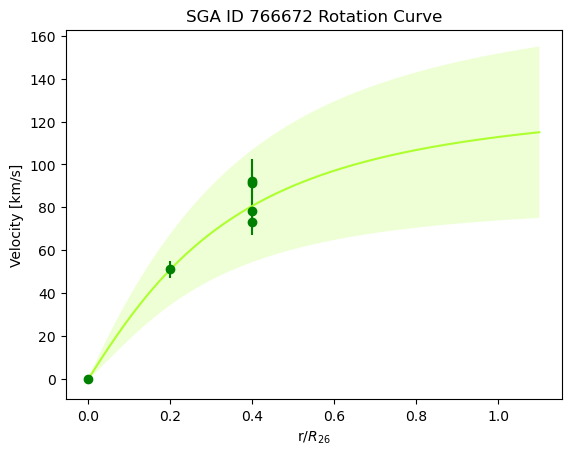

[781.36897152   1.62133753  13.87149099]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


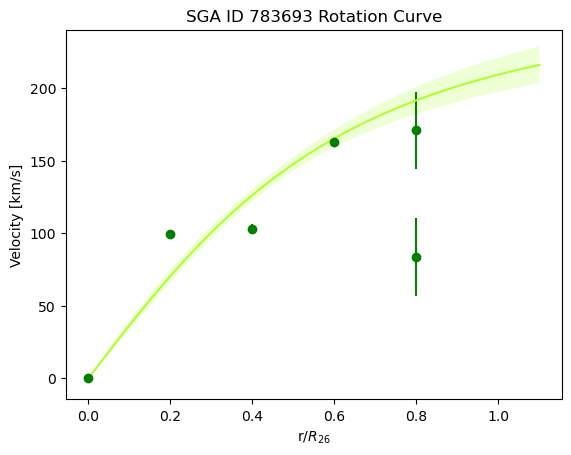

[17.74611254  0.10337162  0.35798755]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

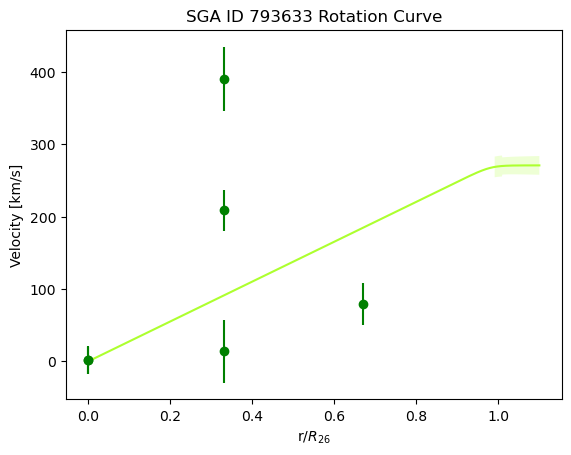

[1582118.23814604    5737.92242099  755747.32415008]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


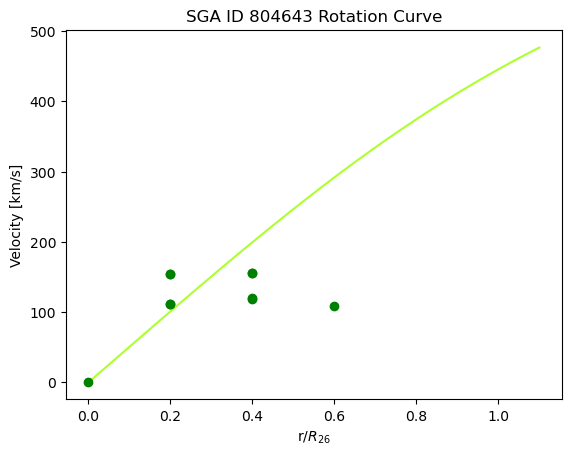

[9.28649114 0.01867704 0.02556912]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


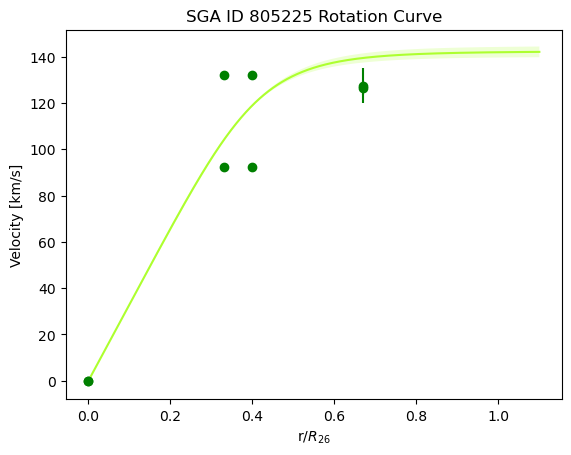

[2.31951776 0.01140972 0.22532295]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


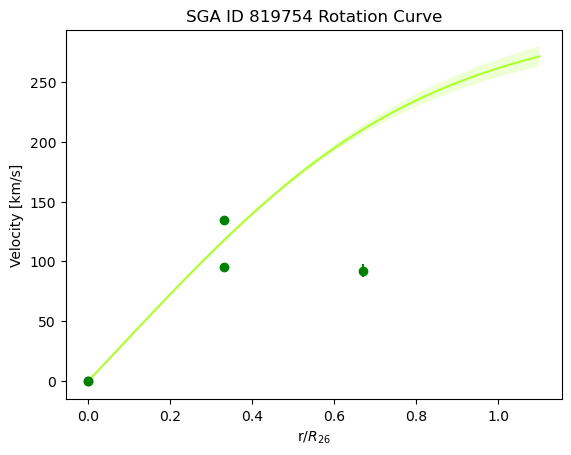

[13.66723608  0.0449542   0.22480435]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


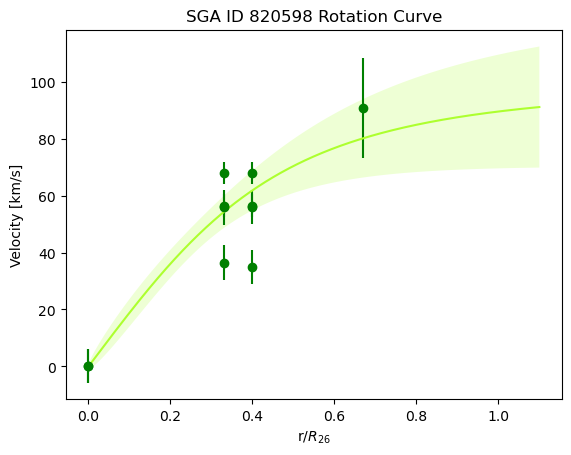

[30.23862121  0.26082014  0.73356937]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

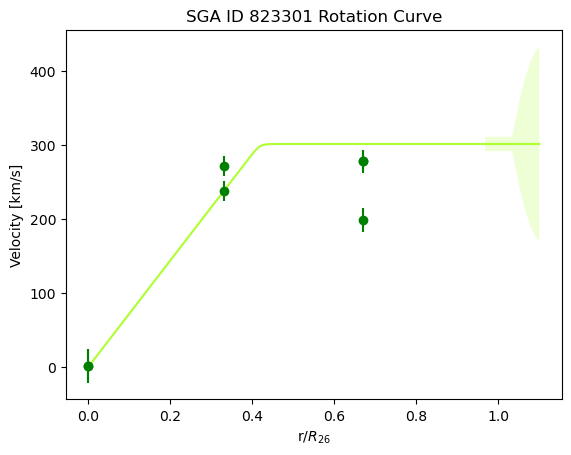

[8.61214807e+00 2.21288862e-02 6.60910951e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


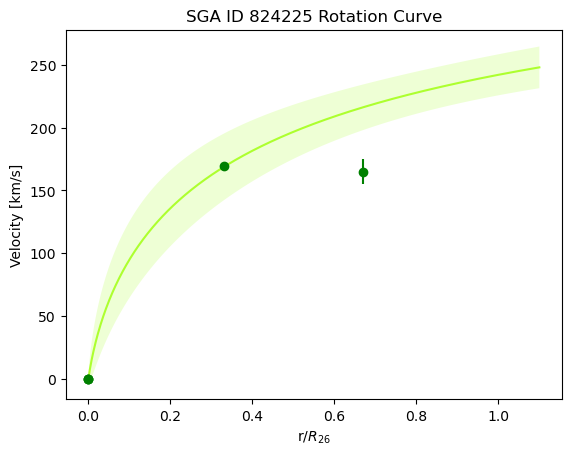

[30.27248312  0.16609042  0.10771448]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

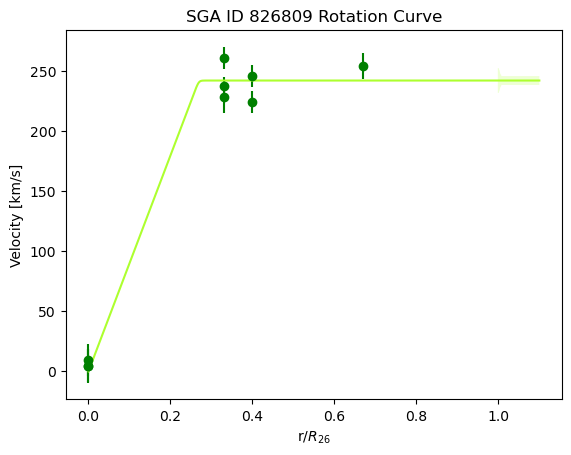

[3.90972448e+00 5.13548223e+02 9.06452067e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/ma/core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


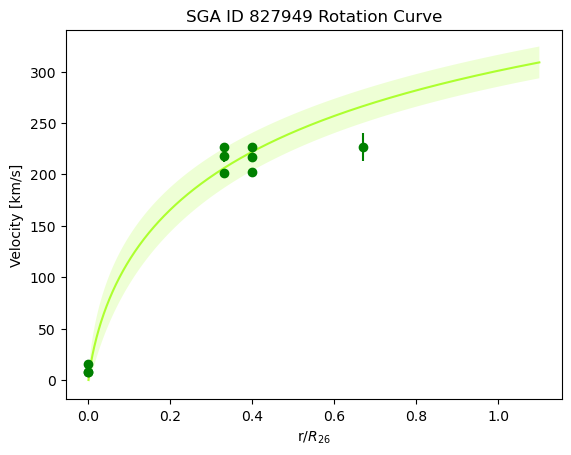

[3.17710582e+01 4.99973582e-02 2.72737537e-03]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

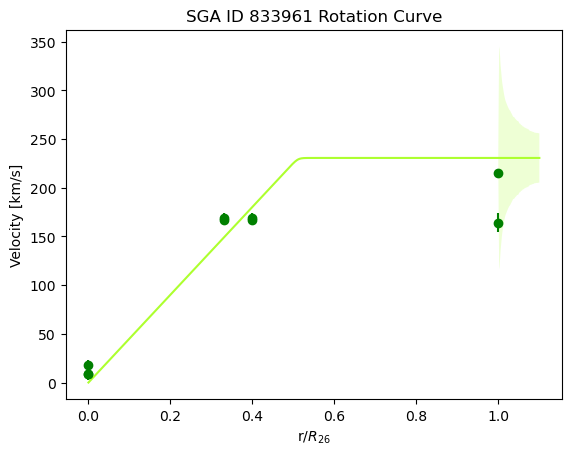

[3.66074751e+00 1.01156983e-02 4.54466542e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


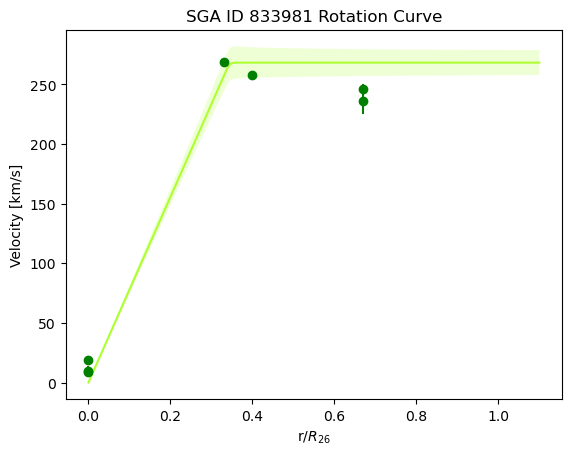

[2.20217086e+00 4.51994332e-03 7.24657023e+01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


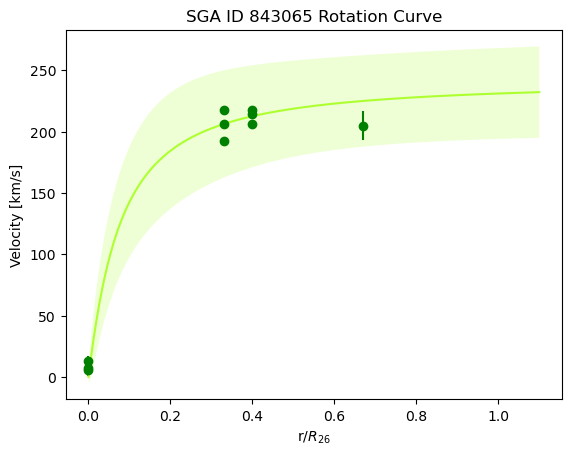

[57.38251914  0.25807493  2.26634938]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


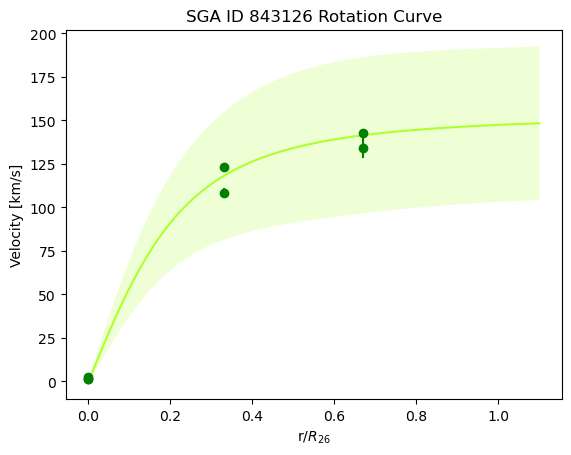

[1841.62224155   12.6009232   173.2704378 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


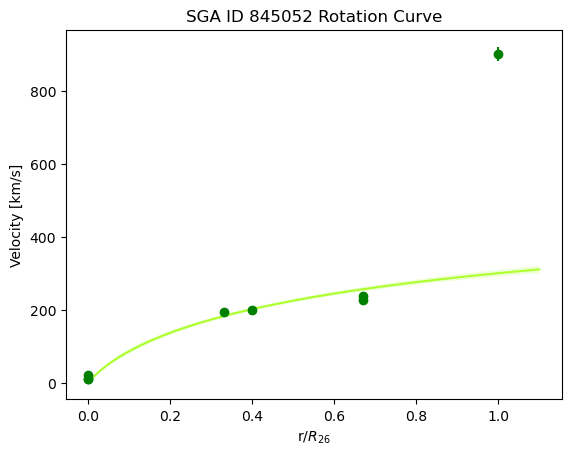

[60.0605373   0.09083298  0.06410002]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


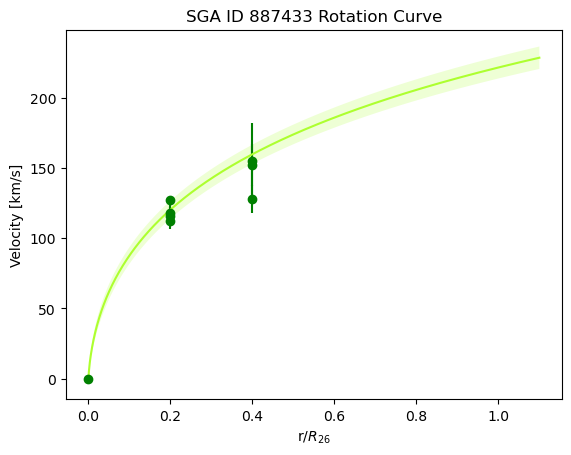

[7.83063663e+01 1.73480698e-02 8.84222789e-03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


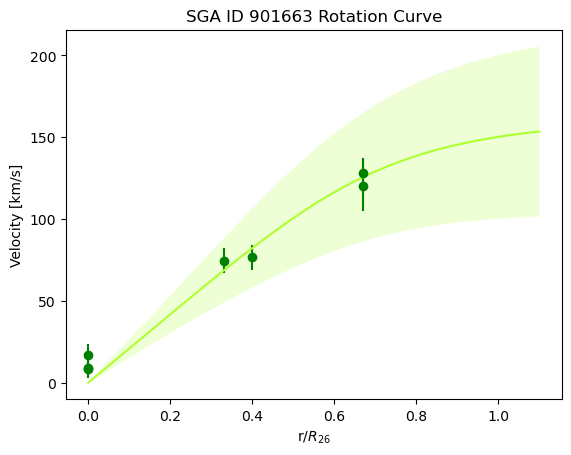

[275.53691296   1.16362097  19.0472507 ]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


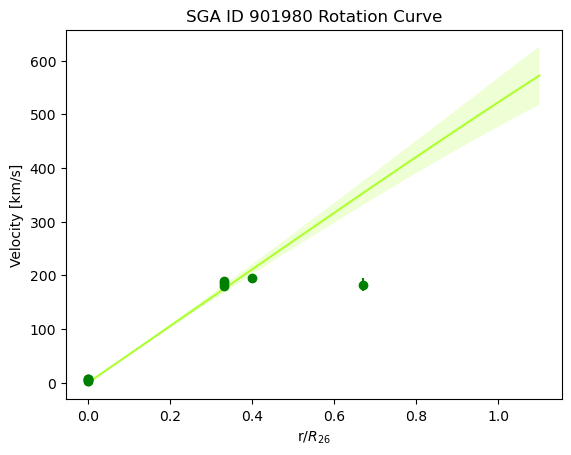

[419.93929232   0.7941001    0.95718021]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


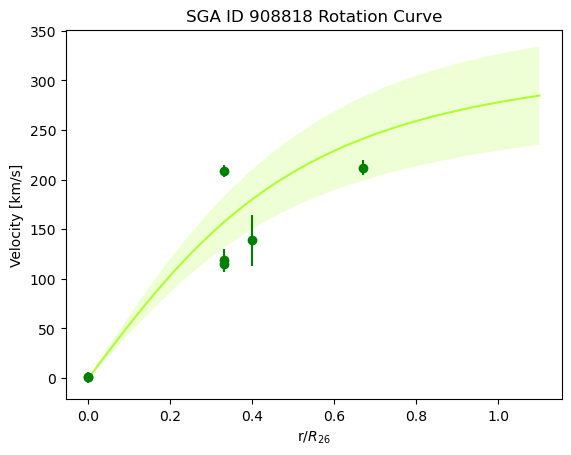

[14.83573653  0.07883262  0.08541855]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


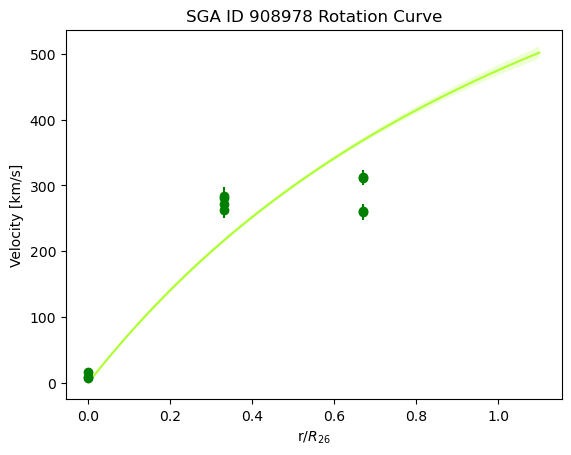

[50.78100876  0.10484514  0.05118149]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


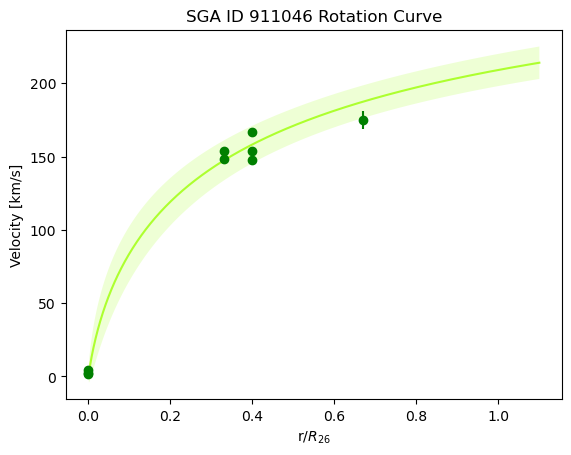

[30.07100208  0.06771028  0.04796958]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


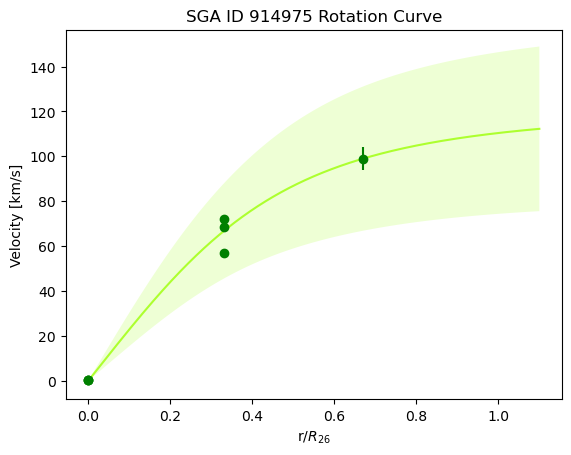

[1695.03052808    2.21462047   95.05398795]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


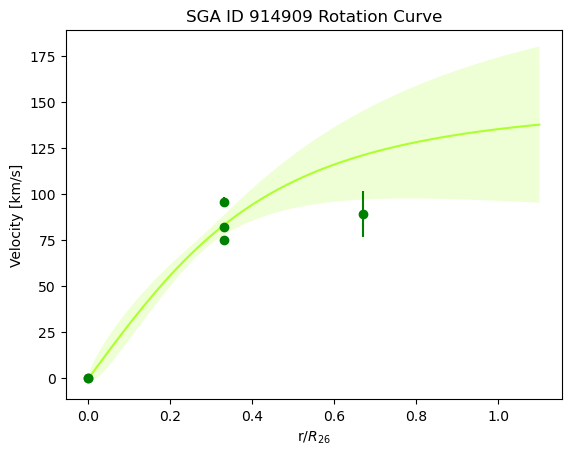

[78.66724264  0.43293486  0.64102077]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


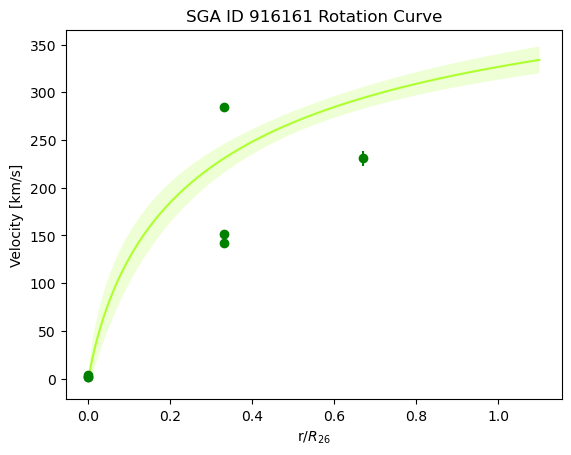

[21.44301237  0.06576695  0.02606661]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

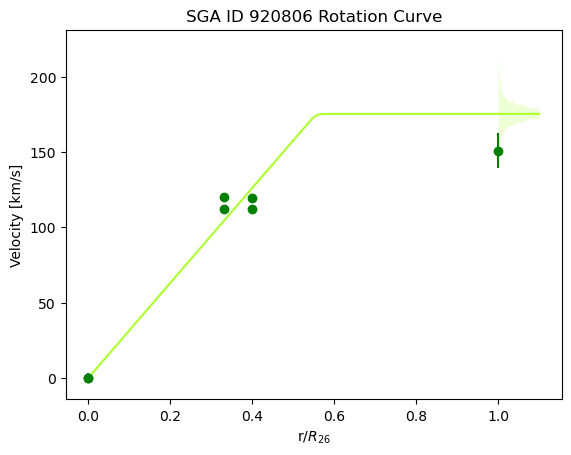

[1.15491972e+01 3.68488867e-02 9.39294450e+06]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


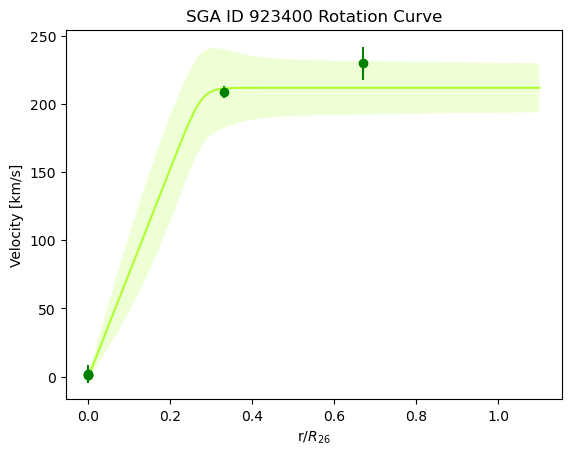

[ 3.61891376  0.08808046 22.07875427]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars

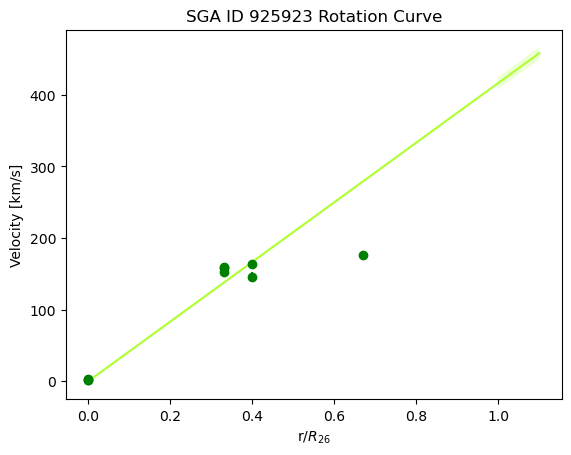

[7107121.42148371   17051.71338067  600816.70167196]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

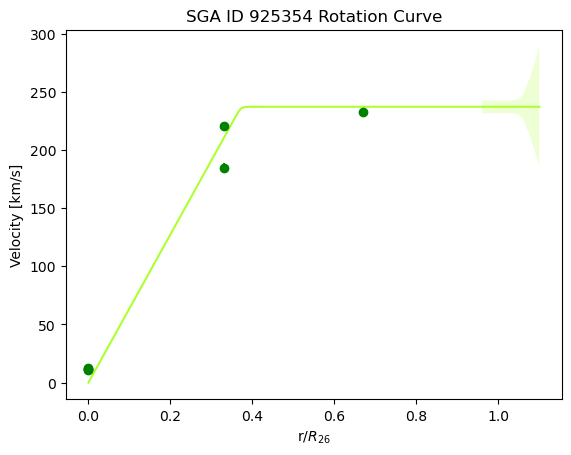

[2.85506188e+00 5.65341460e-03 3.68407718e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


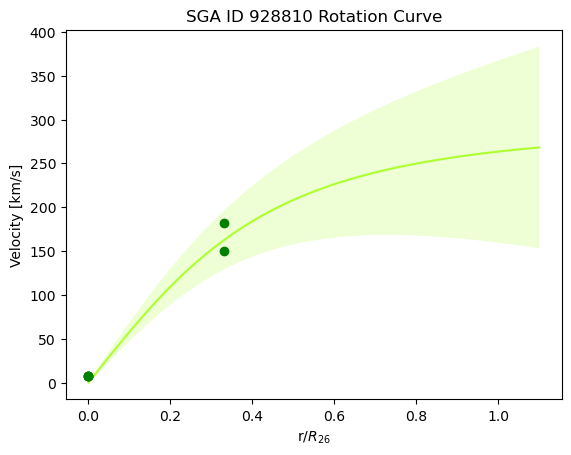

[2146.36658081    5.20503812   10.83137112]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

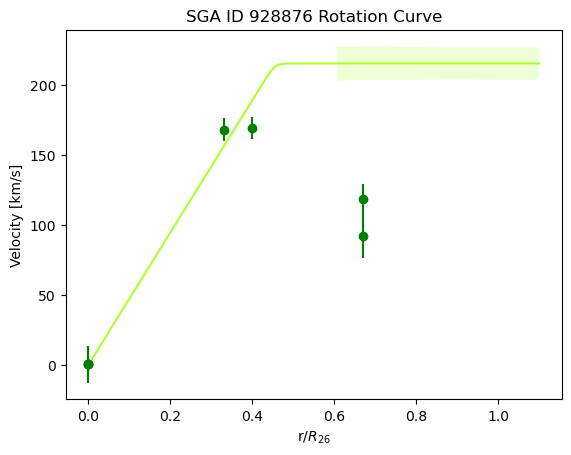

[8.85974193e+00 2.31393414e-02 3.57834876e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


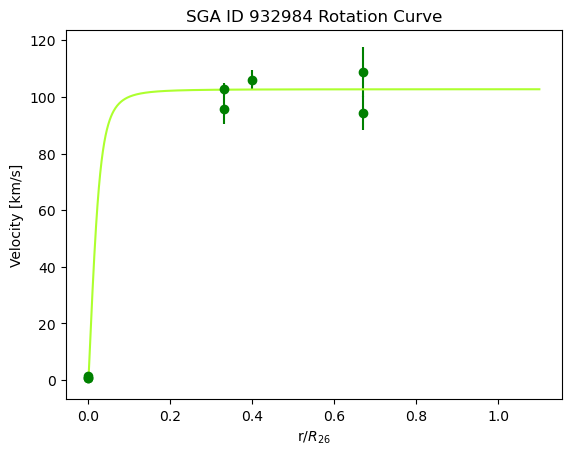

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


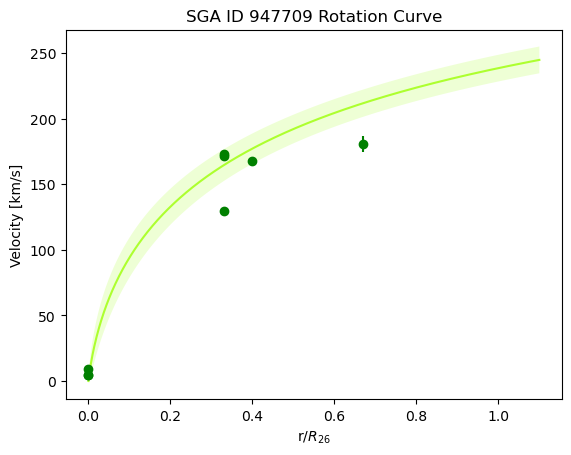

[2.39765533e+01 4.07378172e-02 1.55093258e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


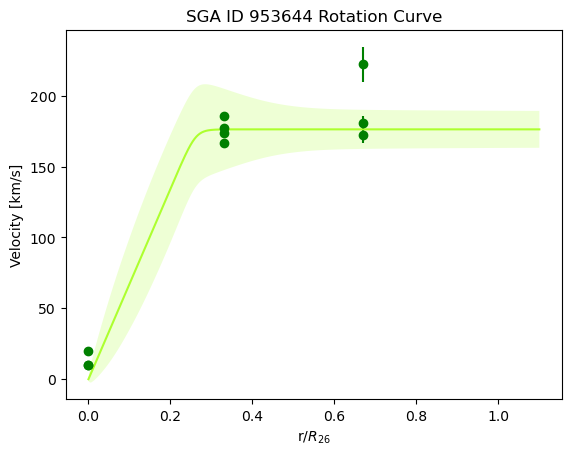

[ 0.84294379  0.15981875 46.99872592]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

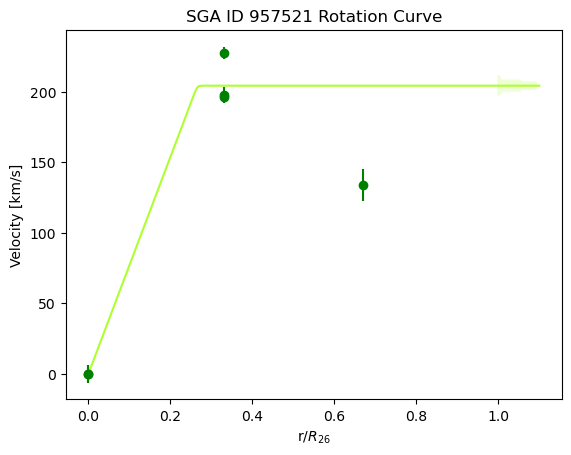

[2.50455109e+00 3.56688160e+02 6.00583713e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


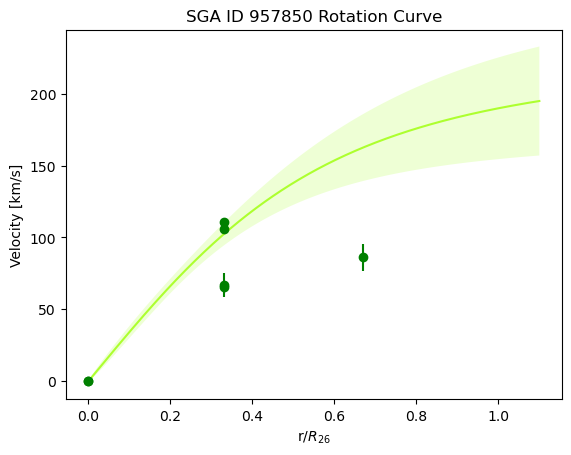

[47.77627314  0.22746169  0.59038278]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


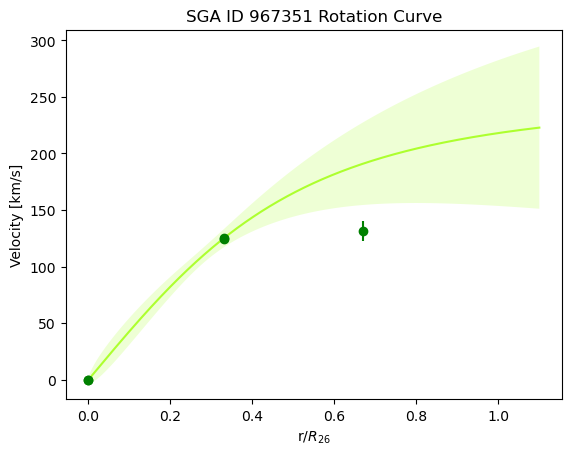

[158.05730508   0.59671249   1.0533925 ]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


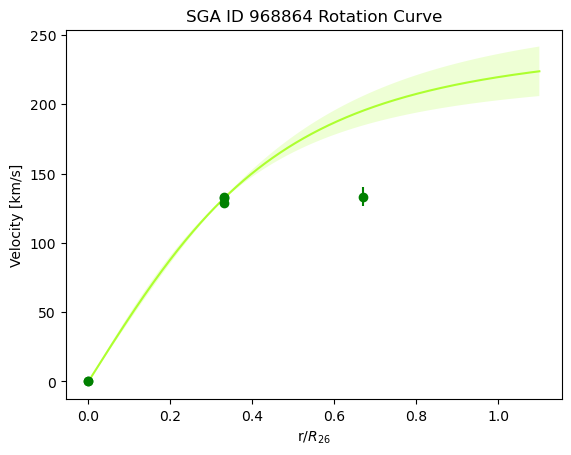

[24.20910841  0.0807634   0.14488831]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


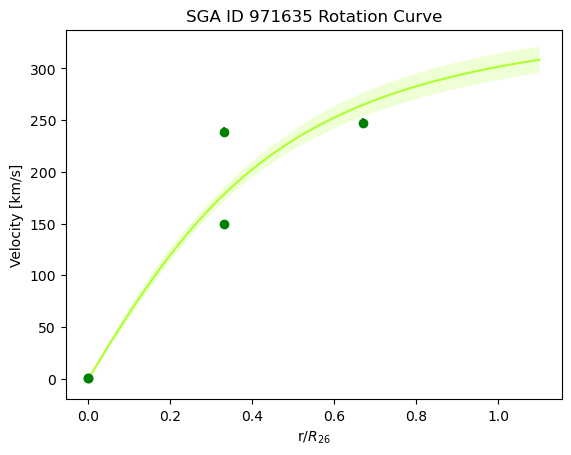

[10.47492331  0.0429401   0.11358918]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

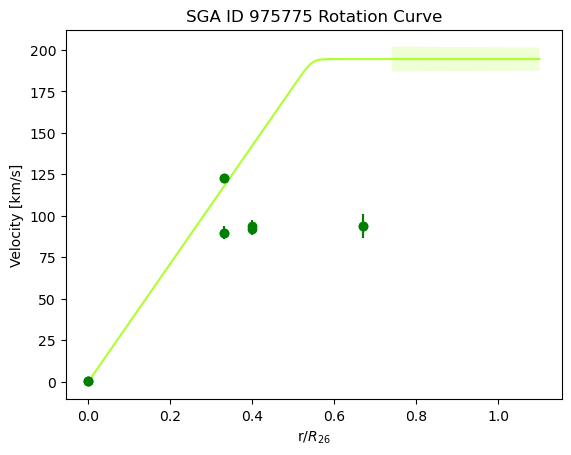

[5.13814463e+00 1.44494564e-02 6.45366792e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


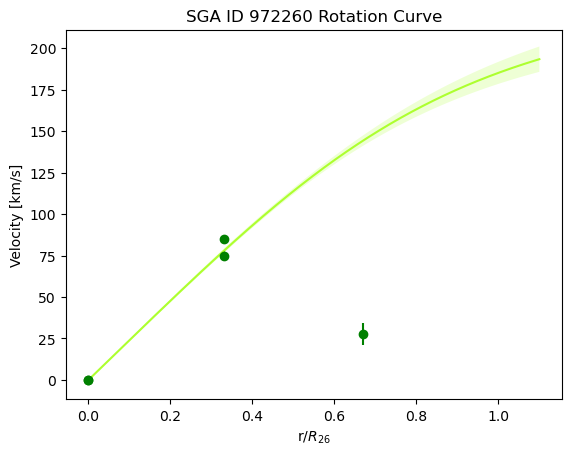

[15.95937328  0.07185181  0.32468952]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


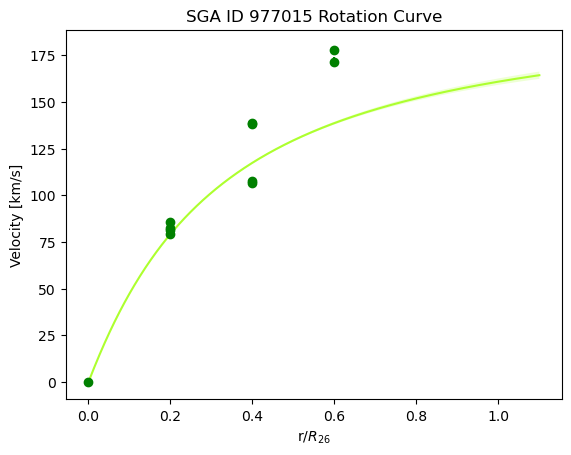

[7.42145926 0.00811713 0.06279752]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


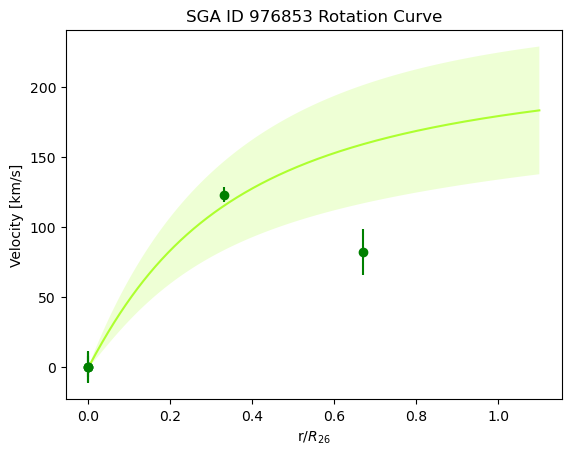

[2.14441207 0.23526459 0.32513826]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


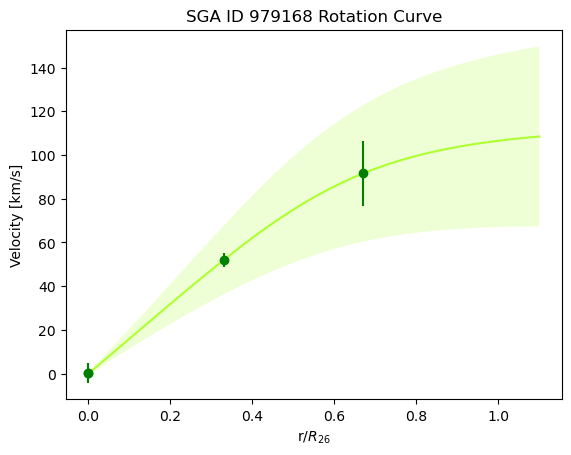

[4421.23972017   24.76158941  397.11828785]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


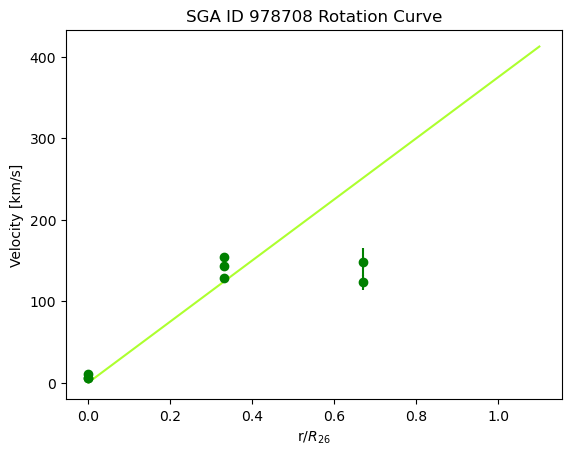

[2.33085155e+06 6.21880135e+03 9.10724531e+06]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

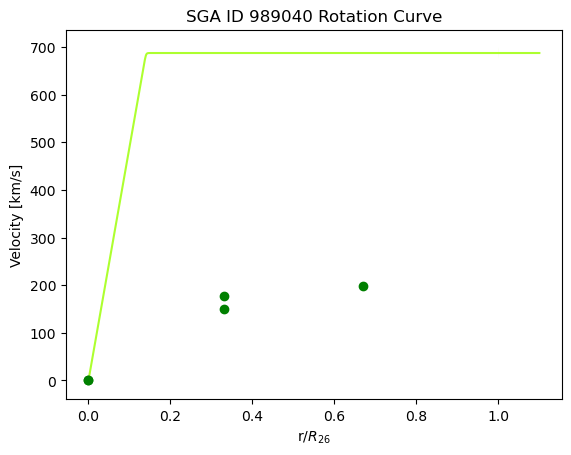

[2.19313244e+00 5.69515235e+03 1.25362332e+06]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


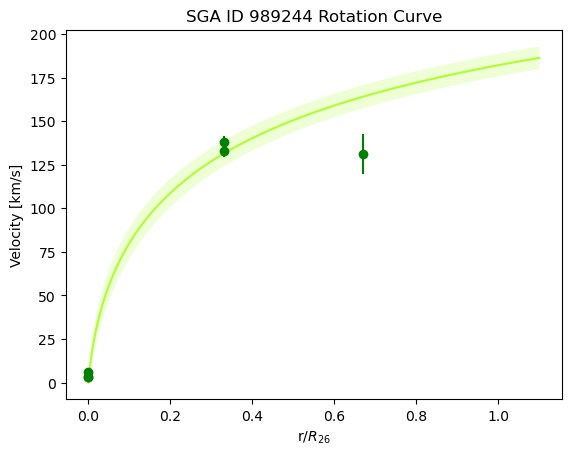

[2.37753434e+01 2.49474419e-02 2.34965346e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by ze

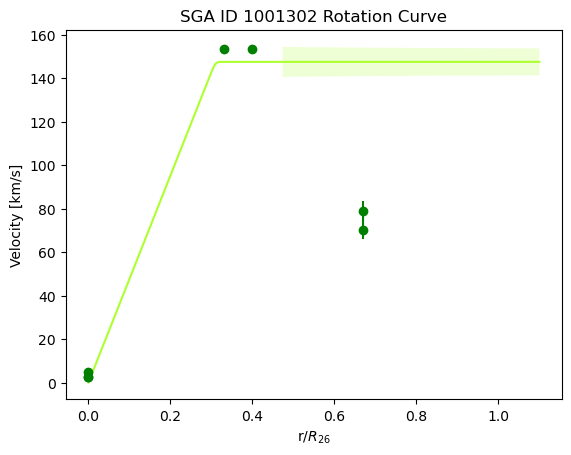

[8.57902651e-01 6.25976500e-02 2.72165299e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


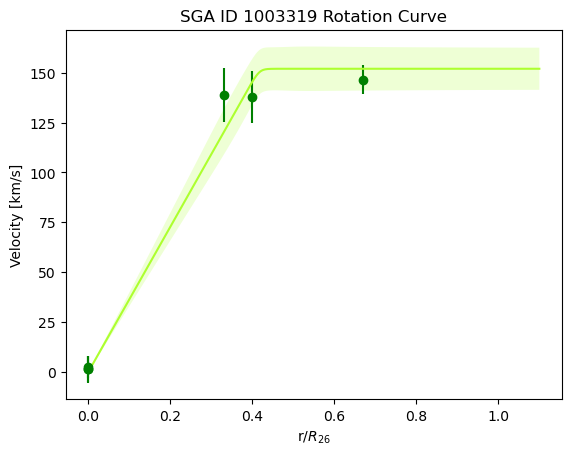

[7.58797185e+00 3.93914056e-02 1.73743631e+02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


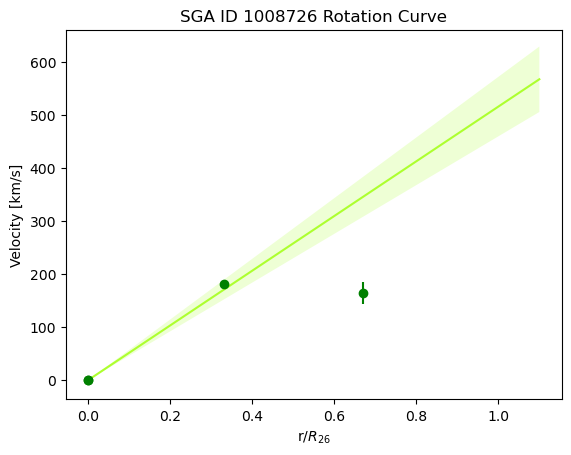

[9767492.94290477   18949.03326399   17592.77744353]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

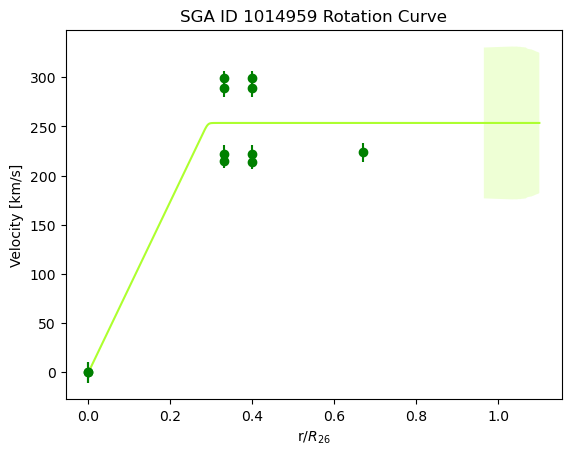

[2.67163483e+00 5.72765274e+00 1.46723016e+04]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by

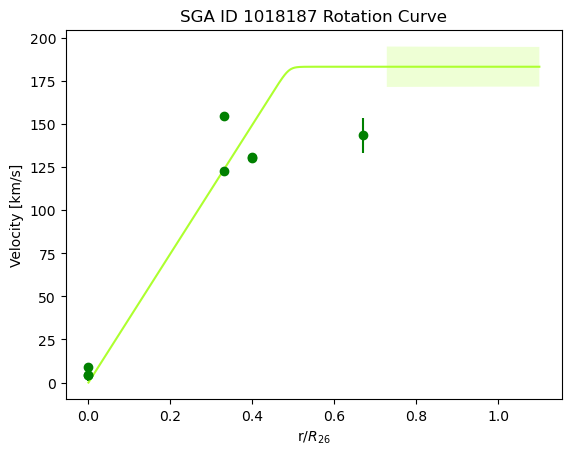

[1.02947369e+01 2.76838553e-02 5.25260286e+02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


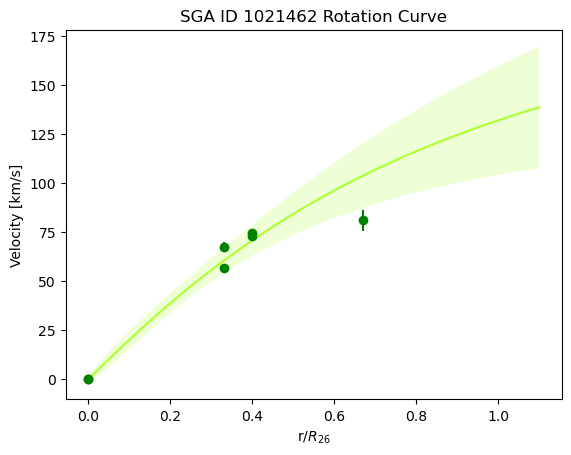

[82.55808409  0.63363353  0.36024743]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


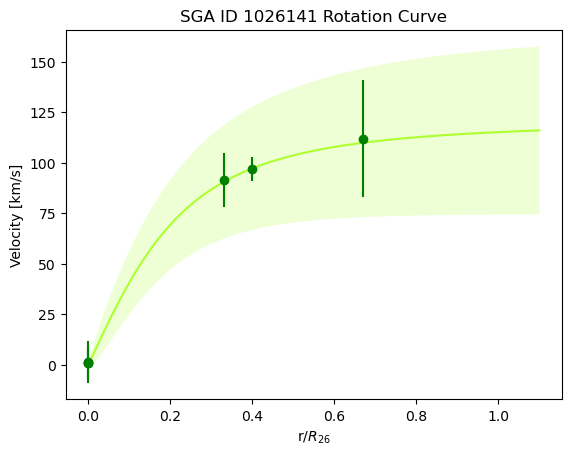

[86.58982355  0.41181336  8.10355117]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


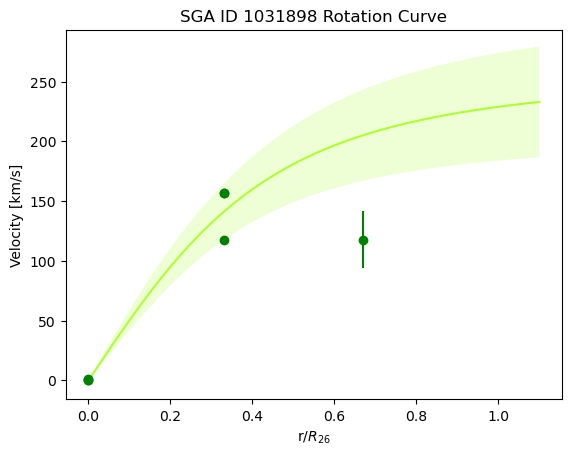

[56.43996371  0.05882394  0.15843014]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


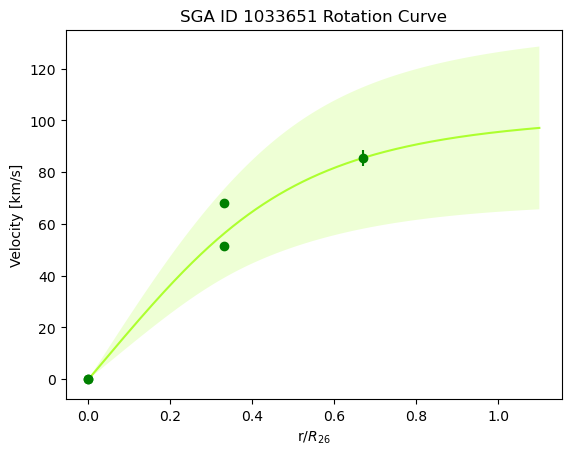

[216.32284971   0.50568626  16.06571925]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


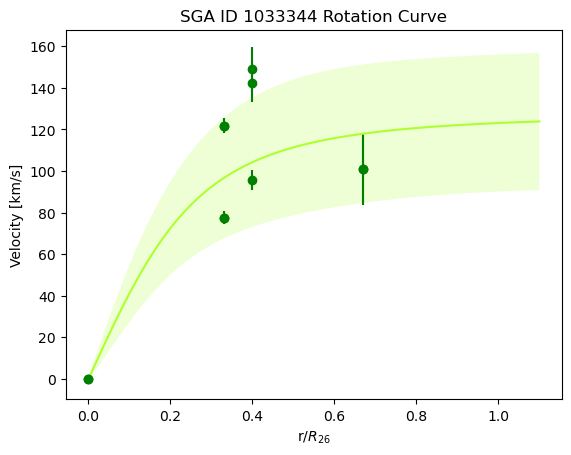

[52.40921208  0.34589587  6.18127719]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


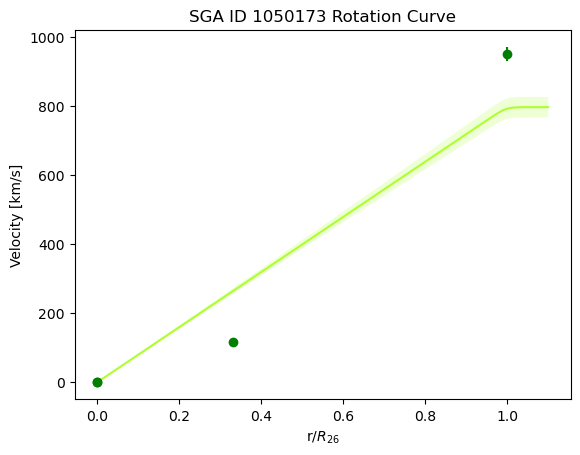

[1.94383802e+01 1.17612712e-02 5.06314394e+01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


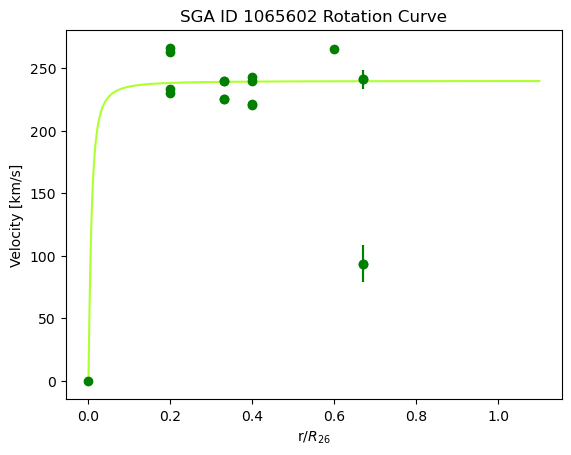

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

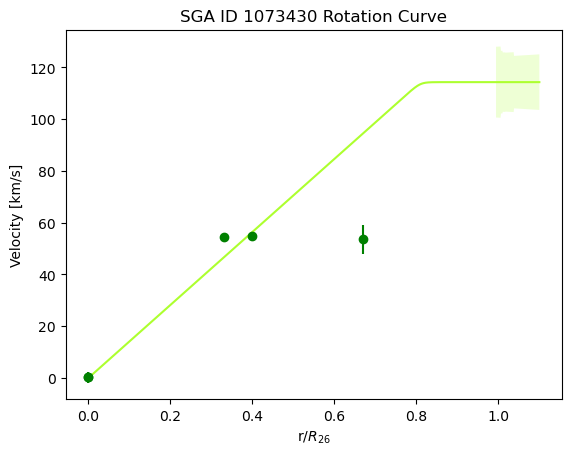

[ 49867.52389907    353.28891118 218222.25938321]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, c

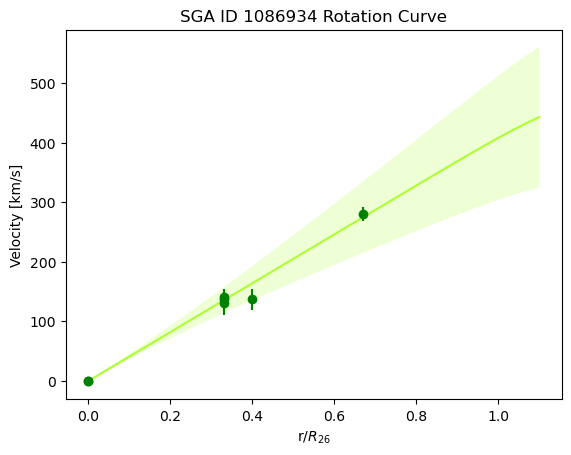

[4157.96425316   10.13937828  184.28493366]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


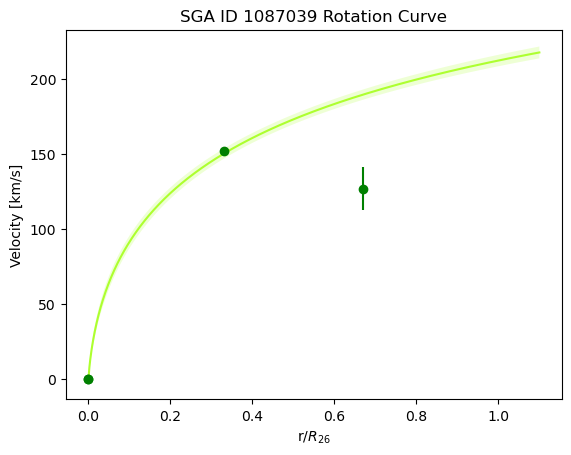

[2.85901409e+01 1.65561784e-02 1.39428244e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

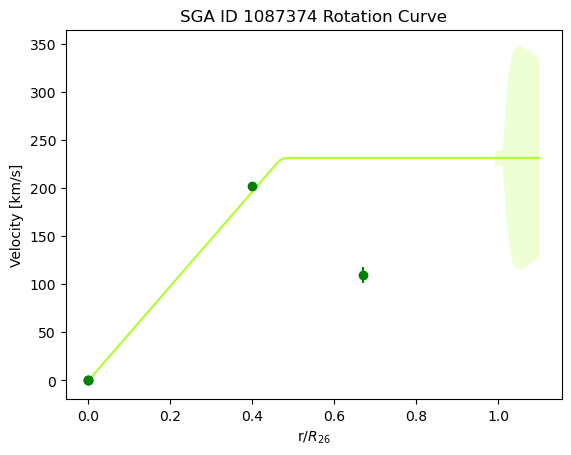

[8.05509604e+00 1.90203545e-02 2.08605639e+04]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


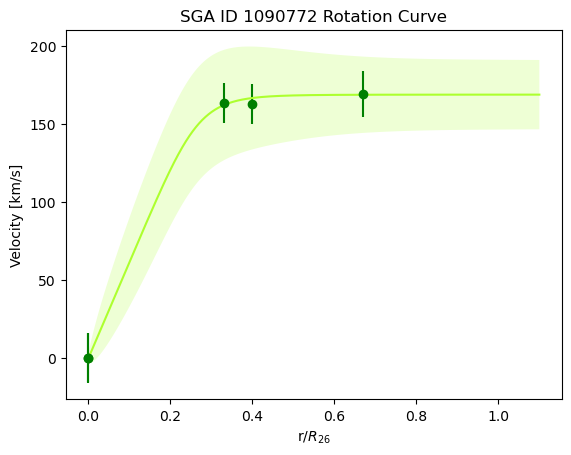

[ 7.68923478  0.15167076 20.38863605]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


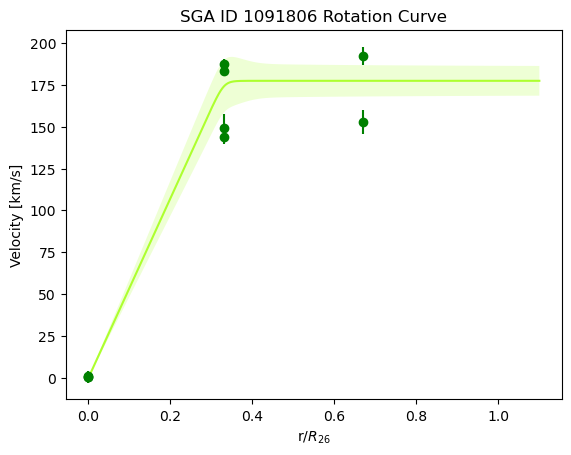

[4.27268076e+00 6.02660419e-02 1.79421124e+02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


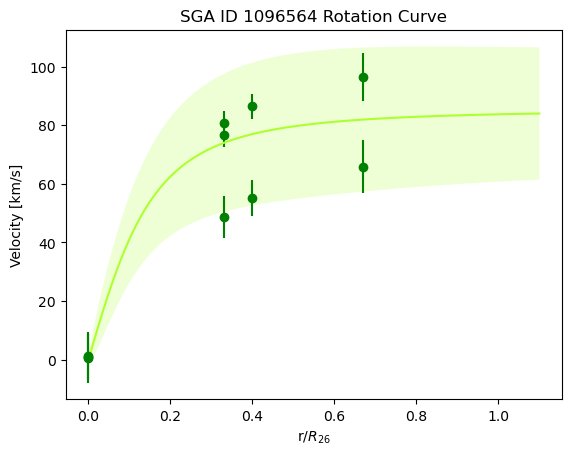

[34.6124903   0.73155788  8.76833908]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


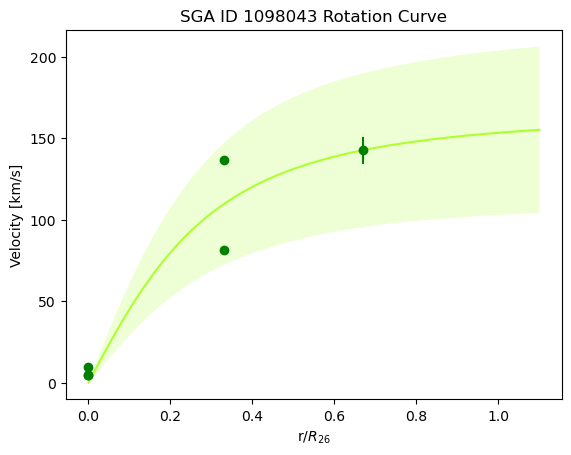

[2305.82736415    5.65622736  103.92248548]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


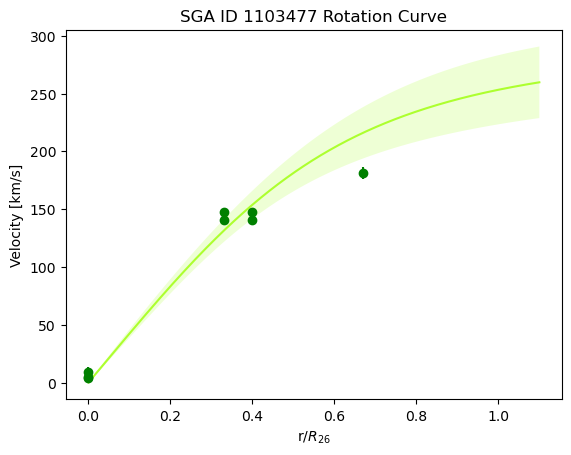

[19.75907817  0.09795854  0.35120735]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invali

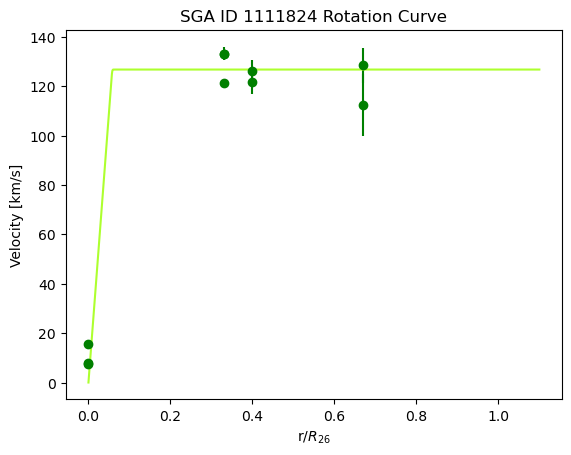

[9.62899917e-01 0.00000000e+00 7.23871722e+10]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


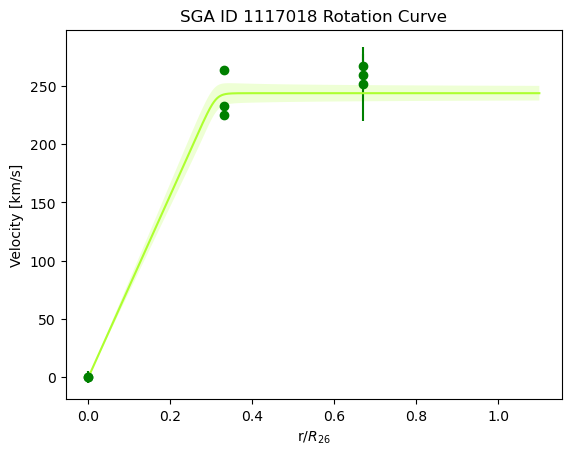

[ 1.38115211  0.01295731 12.68471294]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


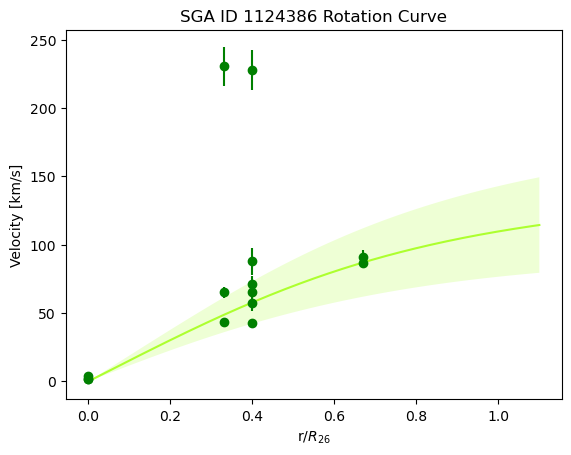

[96.66607522  0.55246343  2.39589025]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


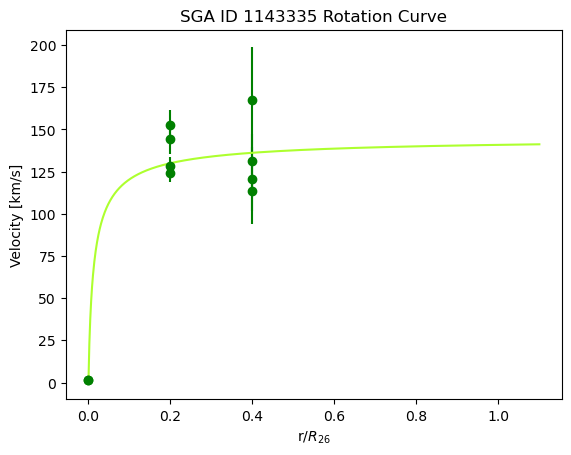

[nan nan nan]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


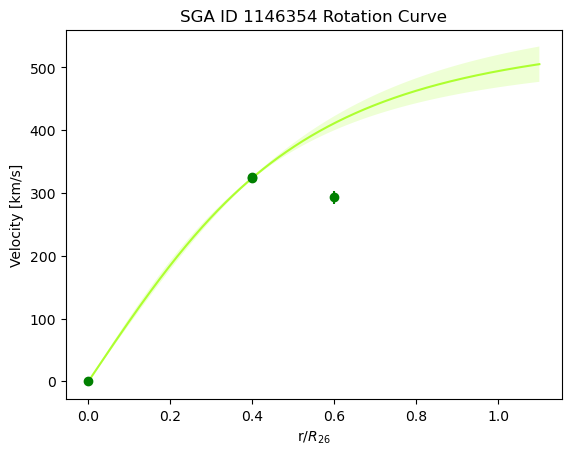

[40.69457828  0.07361717  0.17874716]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


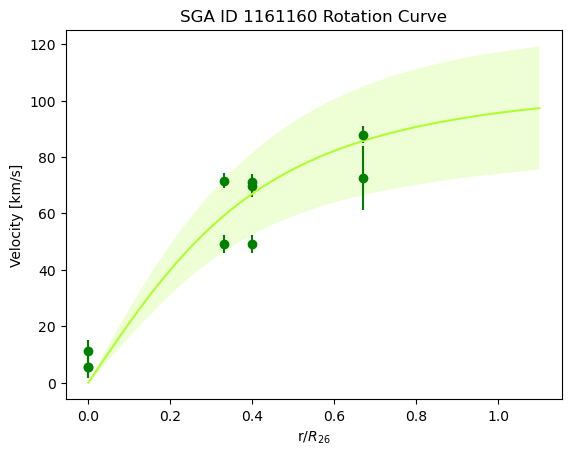

[4.74370019 0.07264176 0.51033826]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


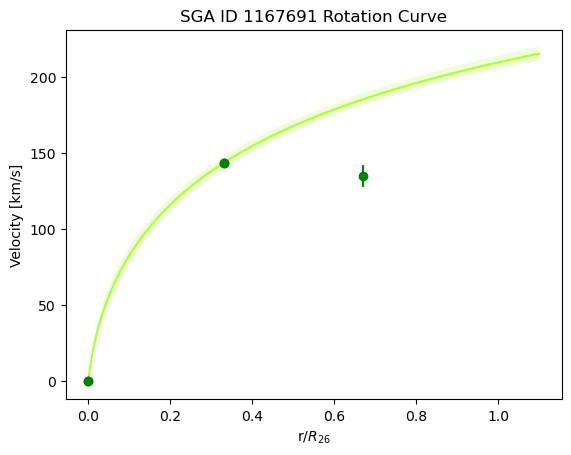

[1.93455121e+01 2.44926259e-02 1.06599222e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

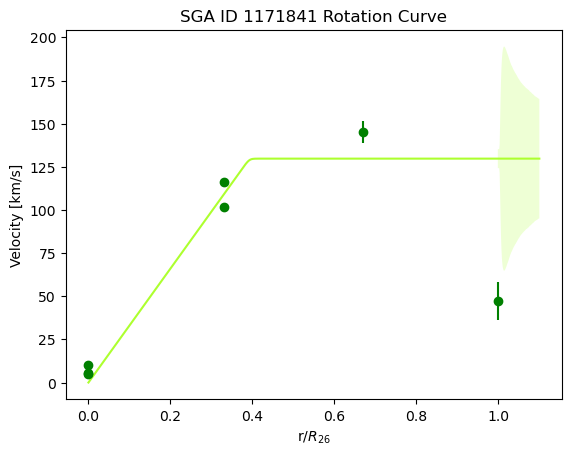

[5.41370080e+00 1.71288986e-02 7.37991533e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


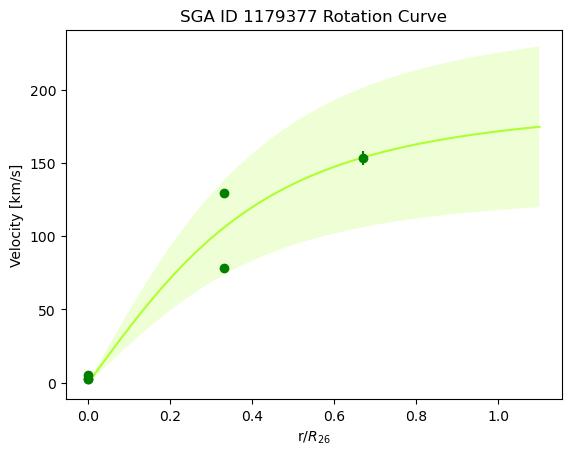

[1.91868799e+02 7.93867001e-02 5.69500695e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

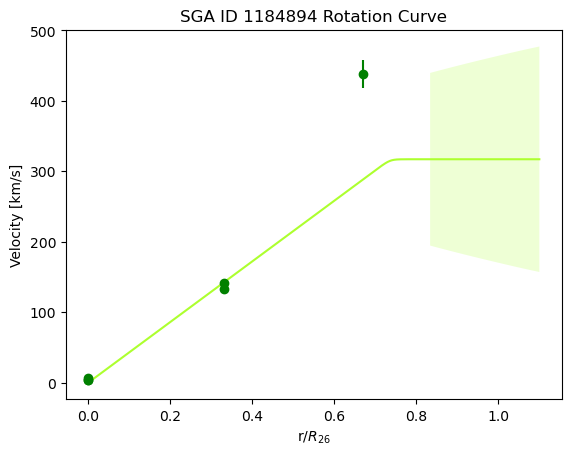

[7.76161017e+02 1.80237658e+00 2.35011942e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


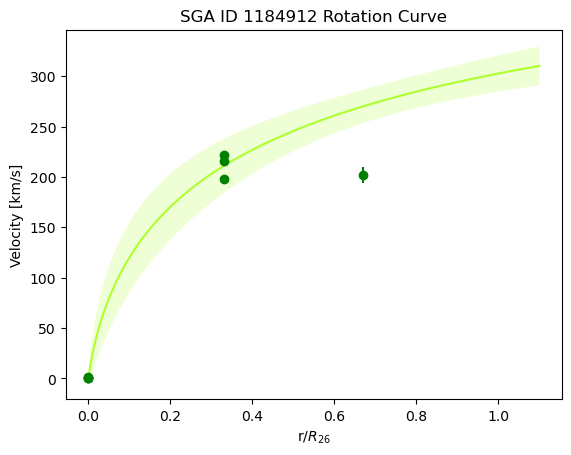

[16.08328028  0.09834946  0.05982257]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


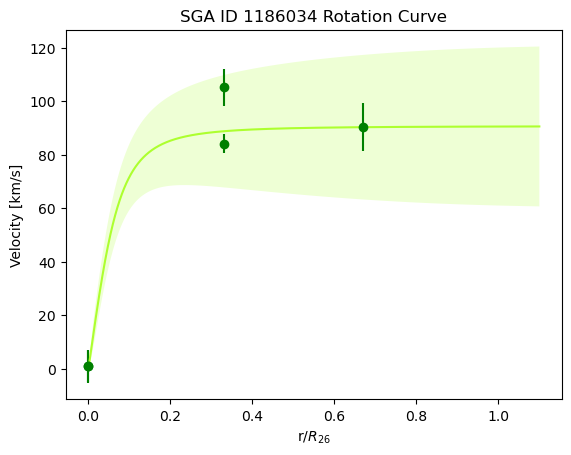

[22.33657596  4.03899942 65.37152712]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, c

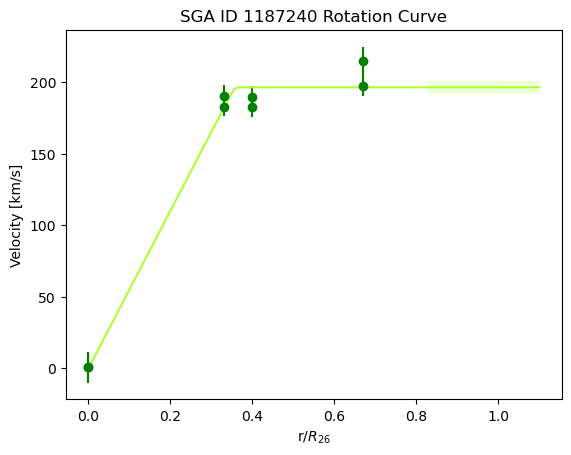

[3.81762620e+00 1.24574595e-02 1.05310892e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


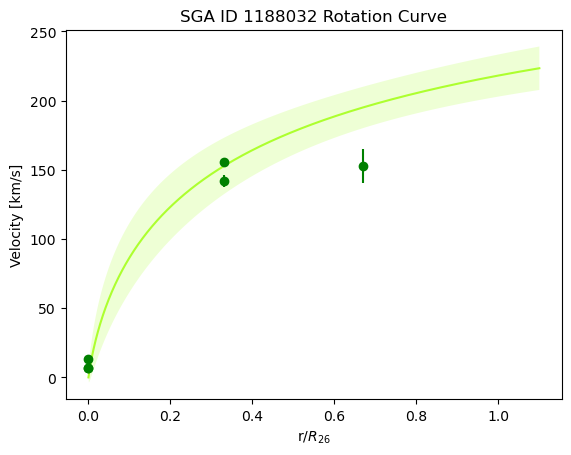

[36.82949072  0.15187978  0.06195179]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


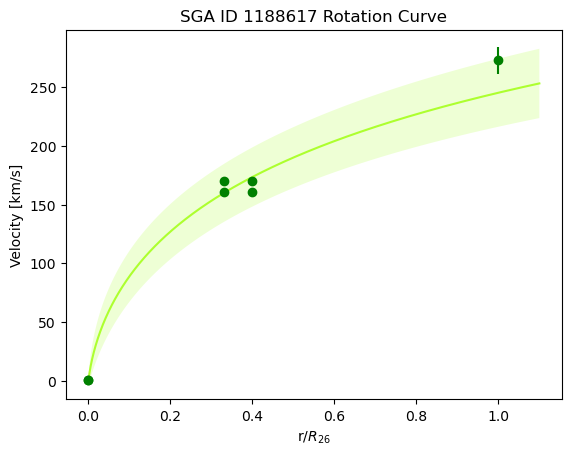

[1.64370941e+02 9.44411277e-02 4.83438548e-02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


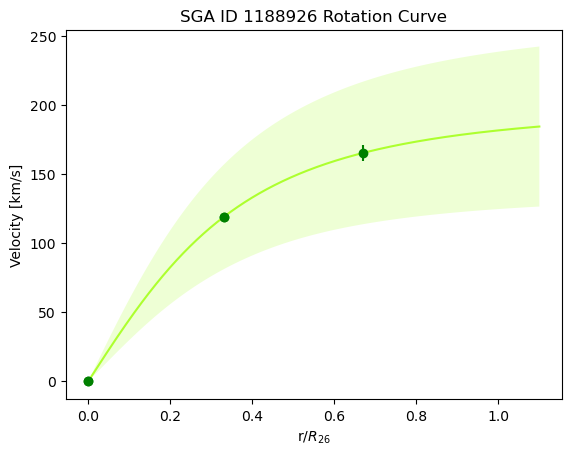

[5.55807065e+03 2.79986443e+00 1.71961307e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


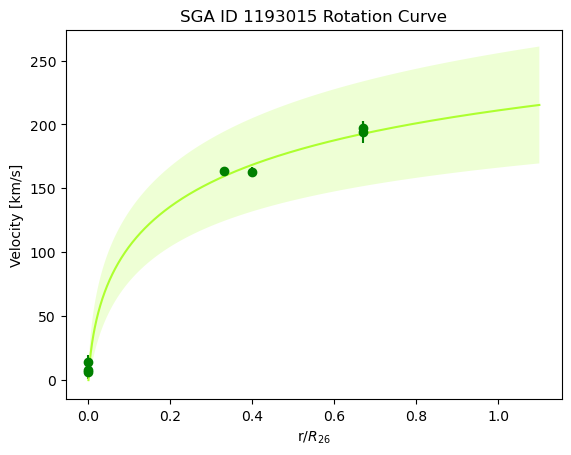

[1.41714369e+02 6.65819705e-02 2.17404571e-01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


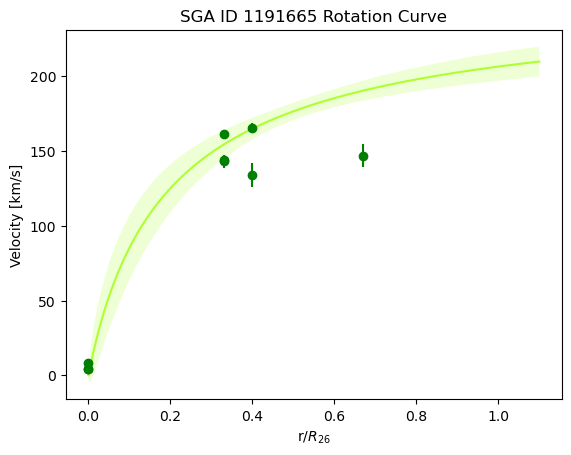

[6.13063004 0.05128127 0.03833302]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

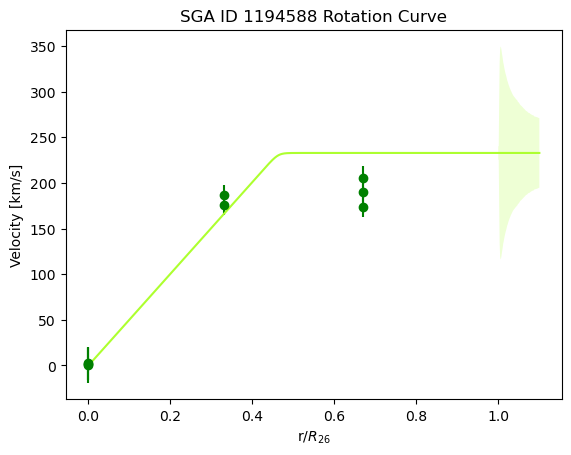

[7.35037224e+00 2.80588625e-02 1.89873781e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


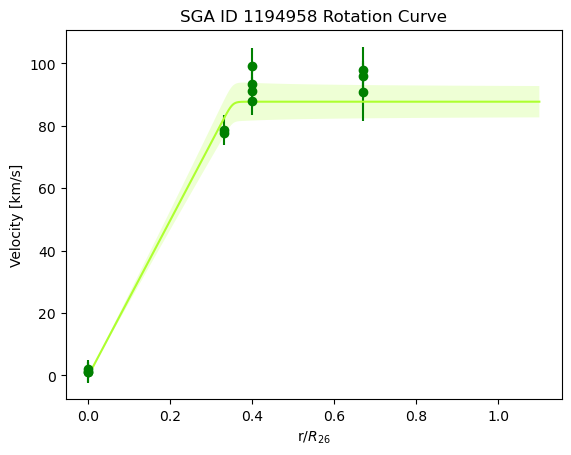

[1.97086242e+00 1.10894169e-02 6.85190924e+01]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


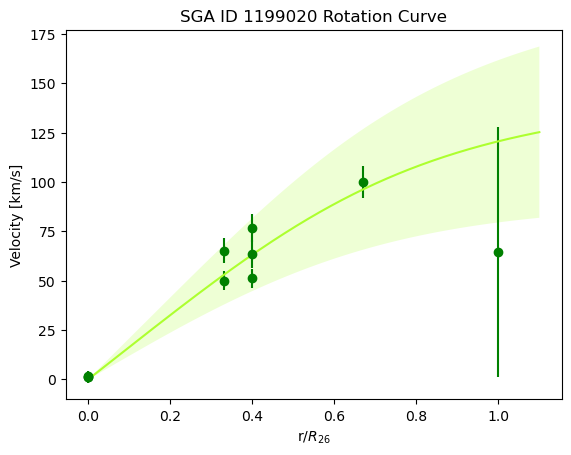

[203.92771129   1.07888815   7.30827069]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


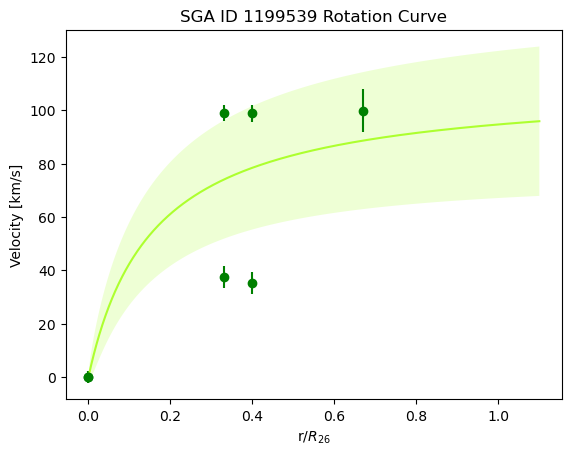

[52.70473253  0.16340554  1.4327878 ]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


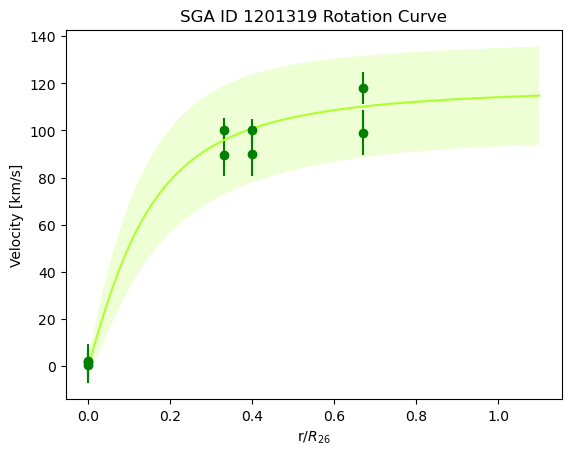

[18.72933127  0.18872345  2.14119139]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


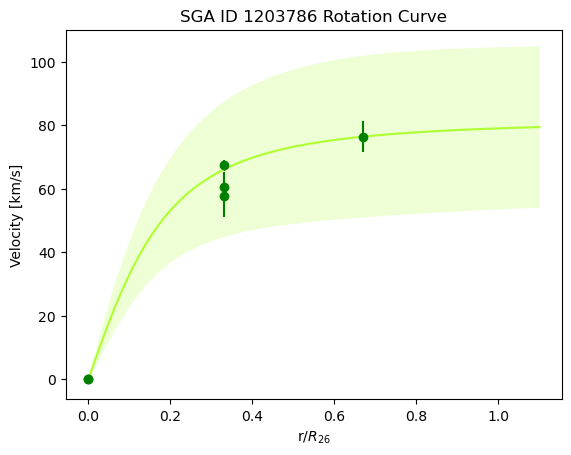

[1222.15016321   20.96129787  246.07350673]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


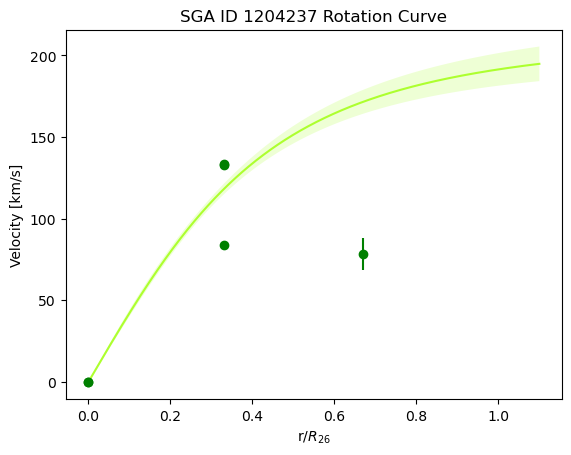

[1.84342080e+01 6.56689257e-03 1.05814773e-01]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


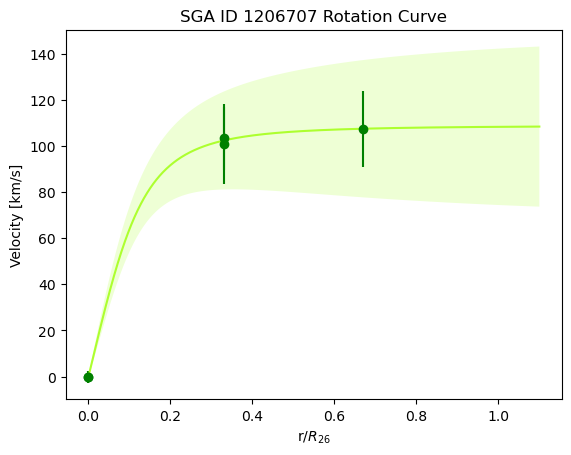

[536.33437971  31.26340644 455.90646665]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


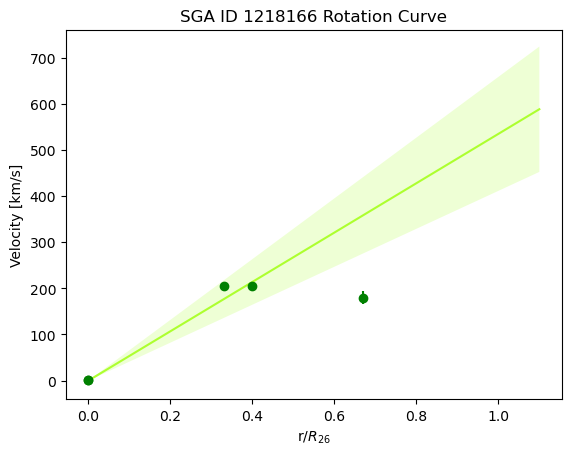

[2316667.97870037    4327.37259867    3520.52701481]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, c

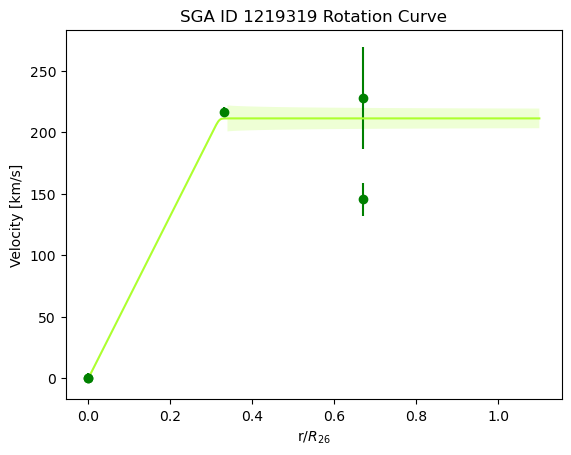

[3.48694381e+00 1.84900563e-02 1.27796603e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


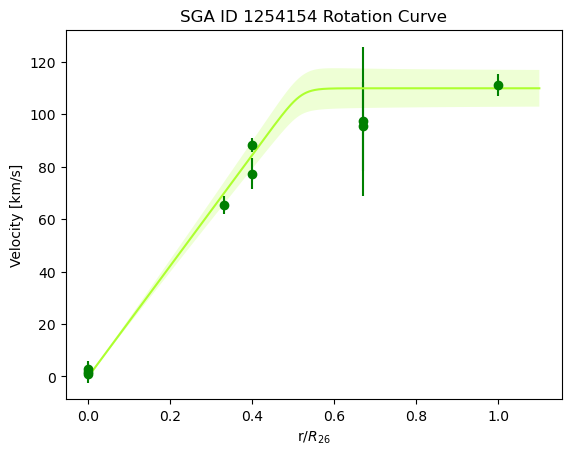

[4.15221983e+00 2.34717487e-02 1.68861572e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


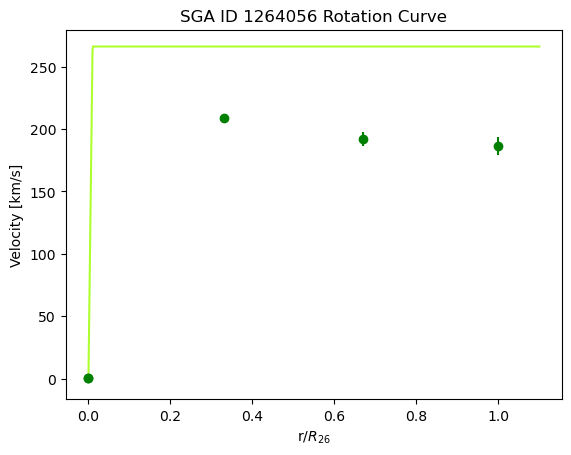

[nan nan nan]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


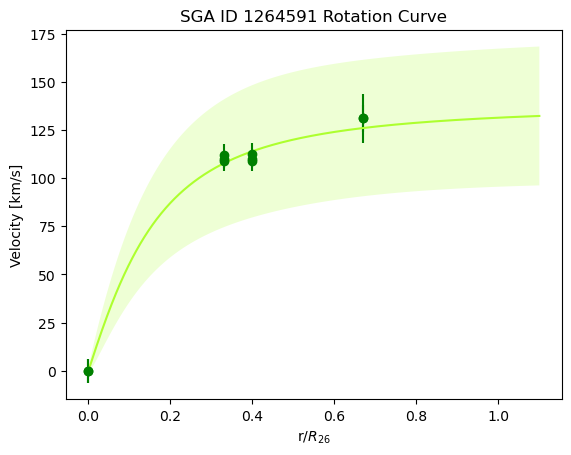

[62.07796062  0.39043669  4.14857556]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

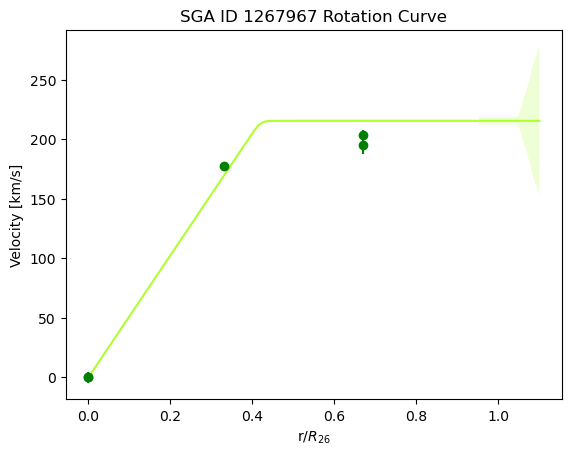

[3.24638448e+00 1.10401770e-02 4.34411246e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


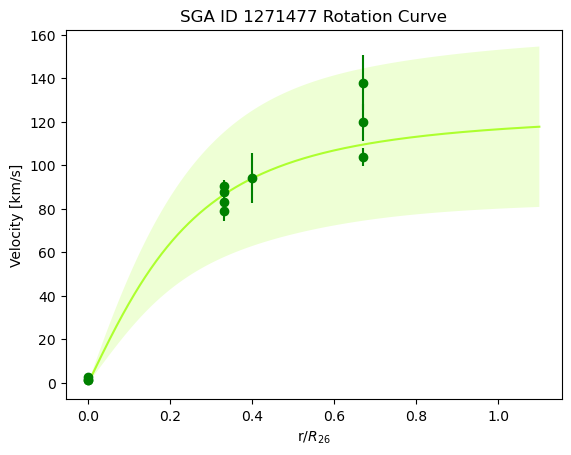

[160.22415371   0.72573215  11.14199588]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


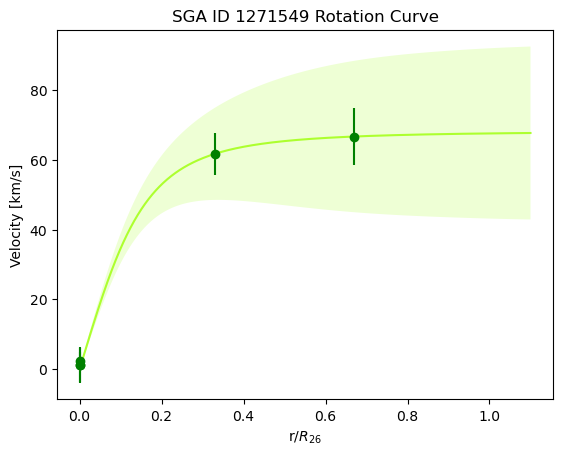

[7154.62334867  386.42700157 5338.00180096]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

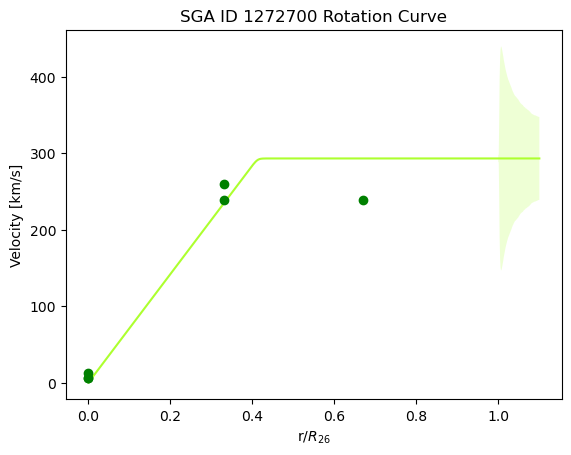

[4.79917919e+00 8.55894680e-03 1.57434466e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


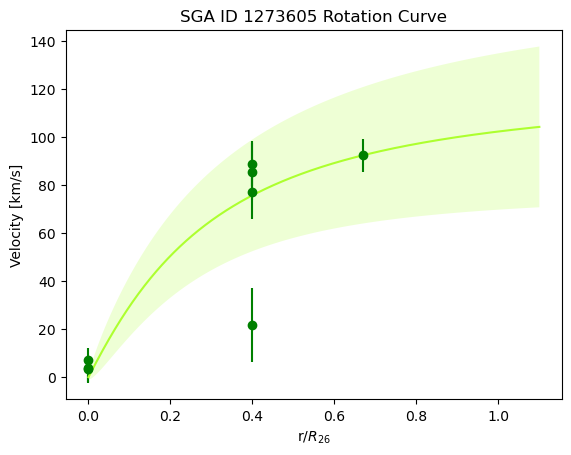

[75.21738709  0.32108109  2.21313036]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


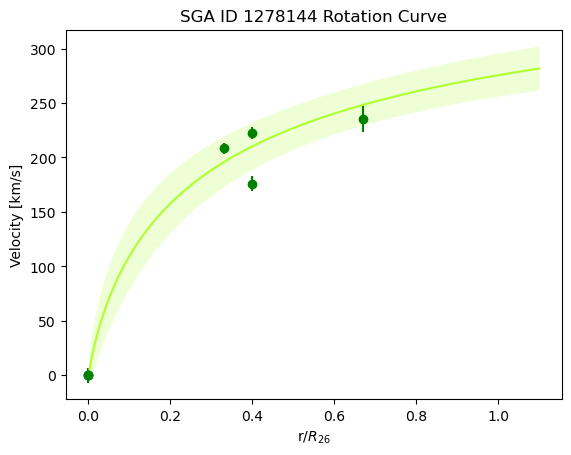

[48.96099545  0.11679138  0.08231363]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


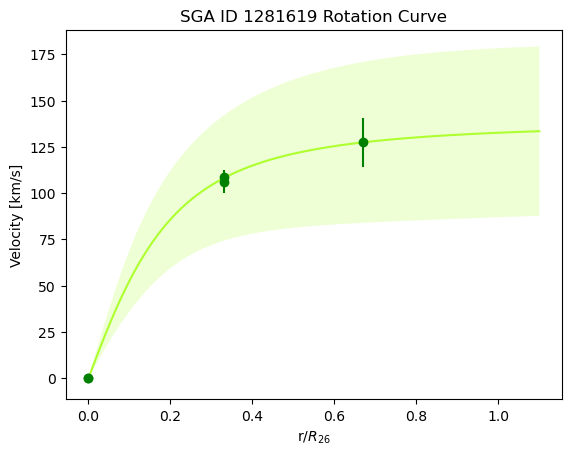

[46670.10149549   386.44453825  4473.34168752]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


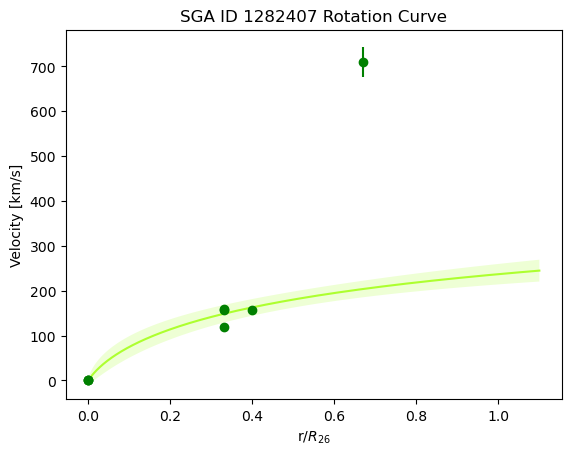

[8.49736101e+01 2.00825001e-01 2.01607741e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


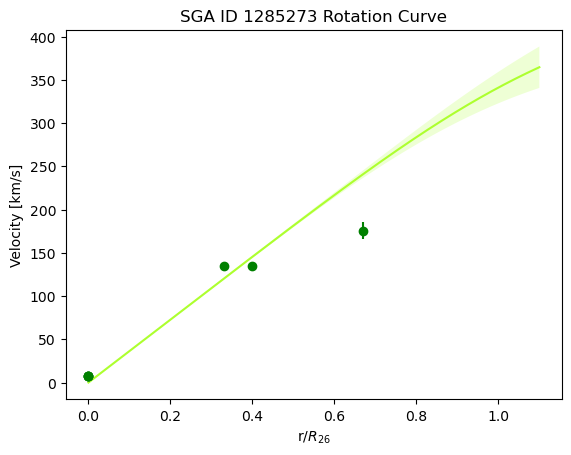

[80.01770898  0.21855745  0.90527703]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


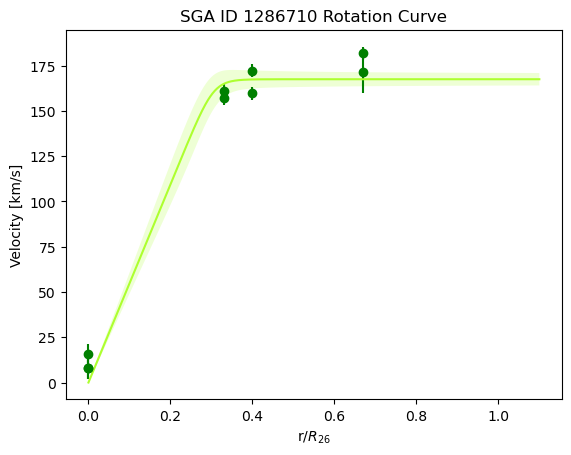

[1.26994723 0.02113593 5.66918916]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


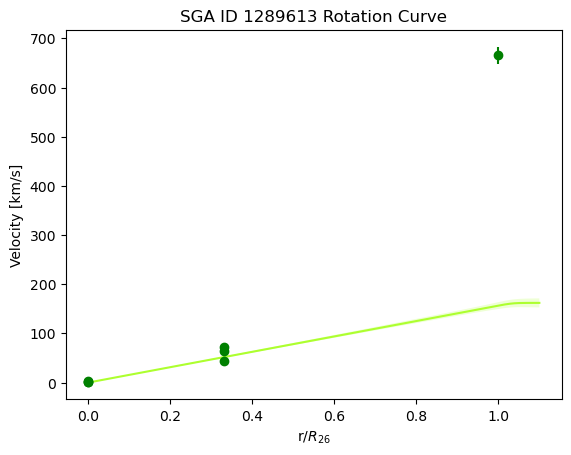

[8.88442120e+00 5.59152104e-02 1.19142573e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

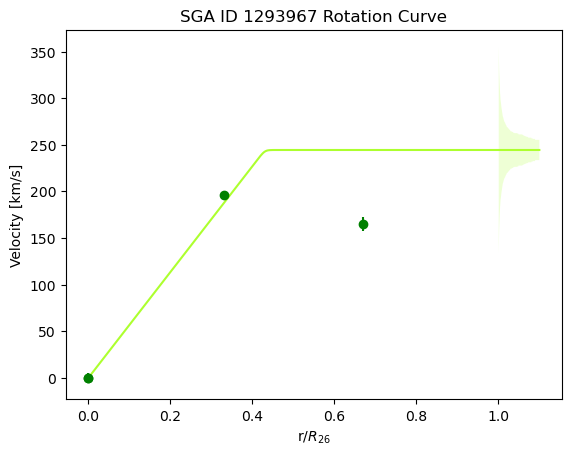

[7.68299864e+00 1.76173435e-02 2.15796182e+06]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


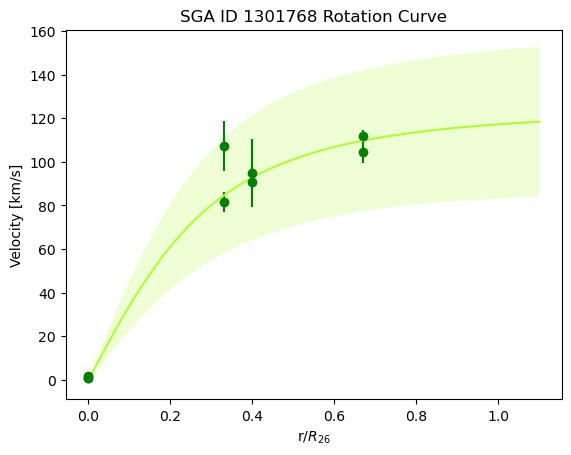

[71.94260845  0.29088445  5.37764812]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


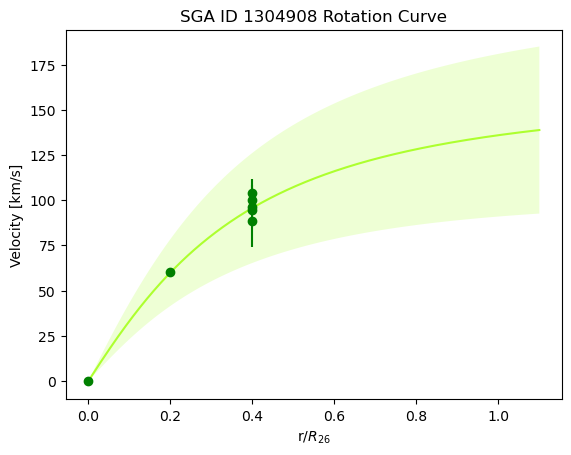

[797.78192986   1.49509175  10.89878584]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


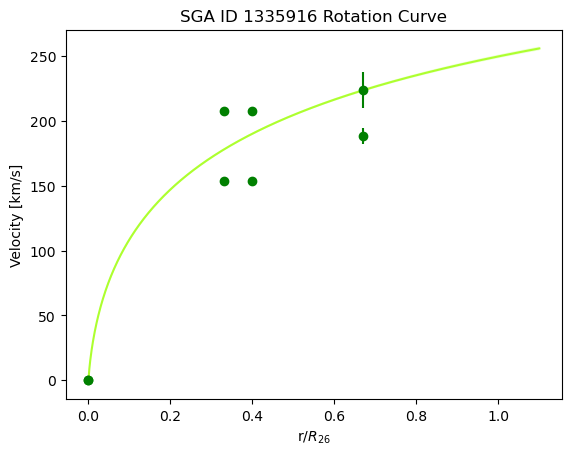

[1.21238472e+01 6.55304614e-03 5.80056852e-03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


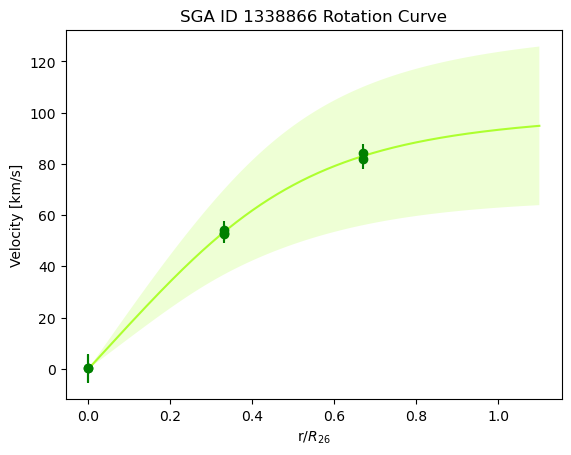

[817.95220841   2.59560561  65.29429364]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


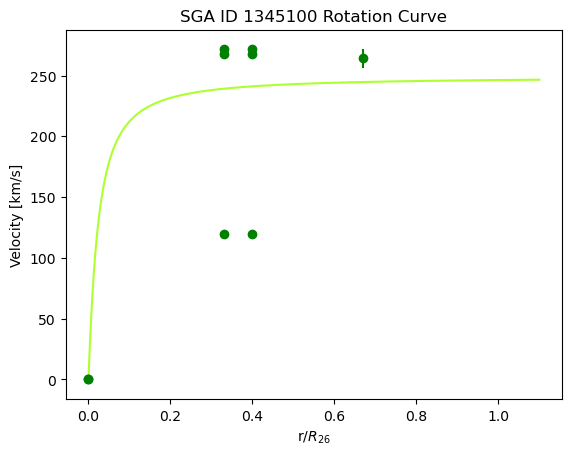

[nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide

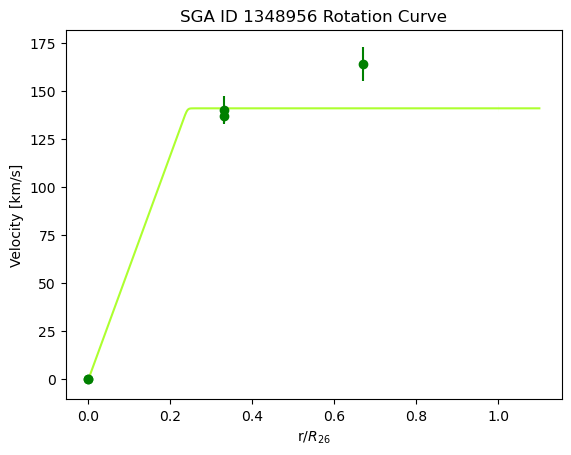

[3.17935916e+00 2.14548349e+03 4.16628444e+06]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


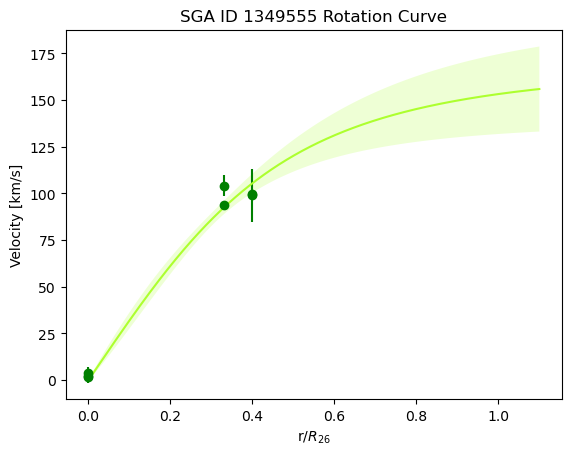

[30.96485432  0.15237083  0.46050259]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


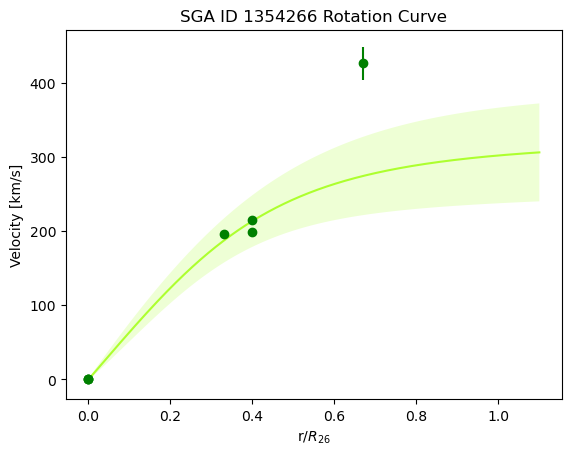

[48.04931677  0.15222592  0.52171702]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

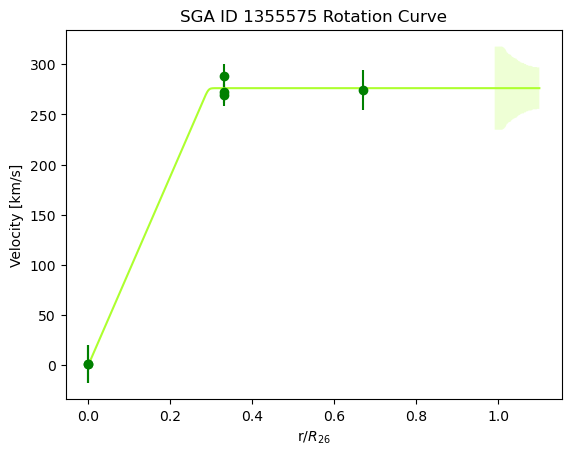

[6.27880761e+00 2.51478831e+01 6.71659839e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


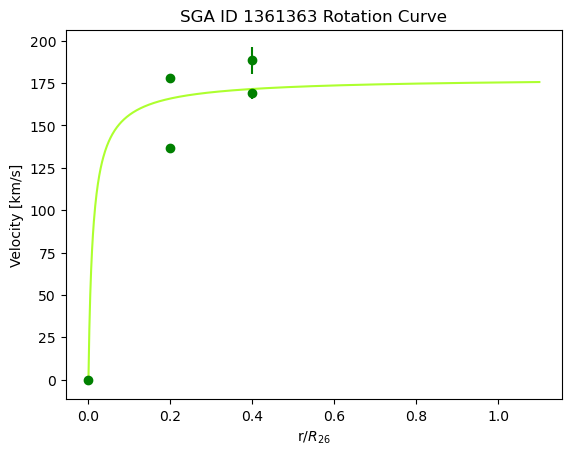

[nan nan nan]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


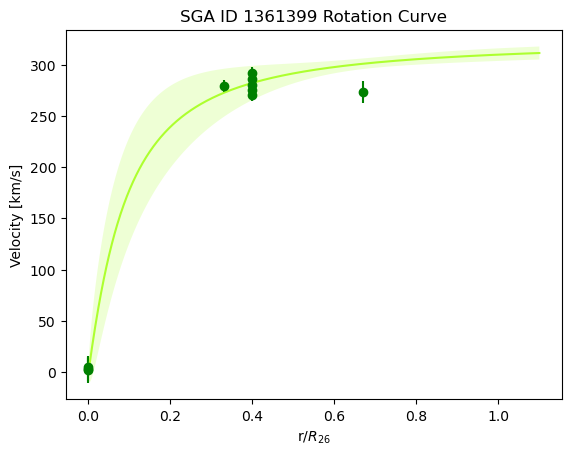

[4.75394097 0.04848244 0.13490166]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in true_divide
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


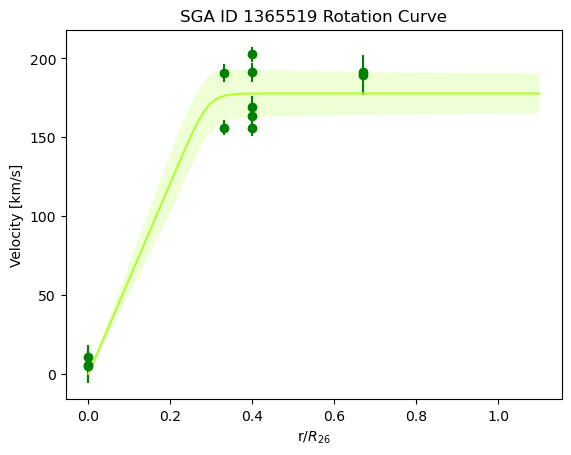

[1.71518815 0.03617162 8.57252104]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


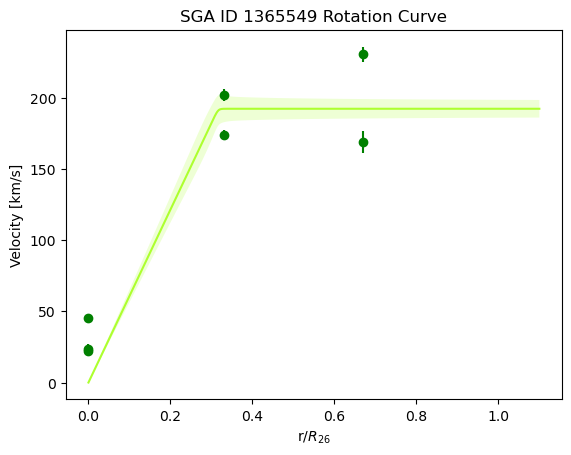

[2.37388359e+00 2.01061728e-02 1.15672150e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


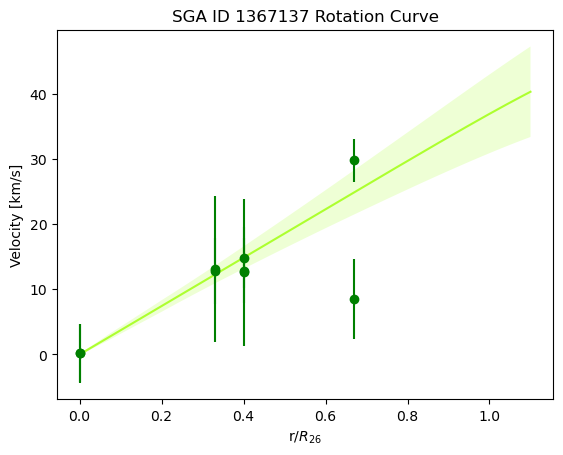

[691.48872725  18.6010945  143.33126177]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


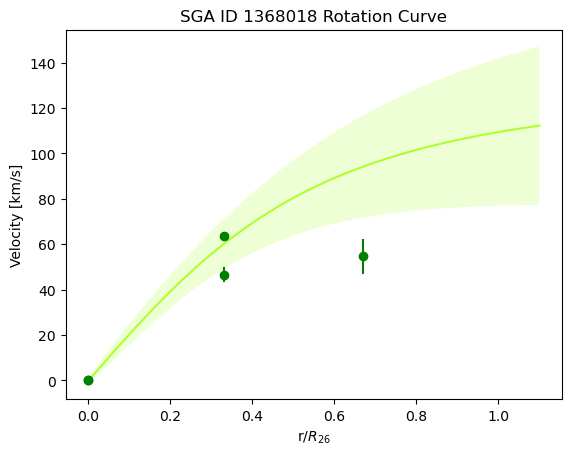

[45.94150026  0.42280674  1.01996956]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

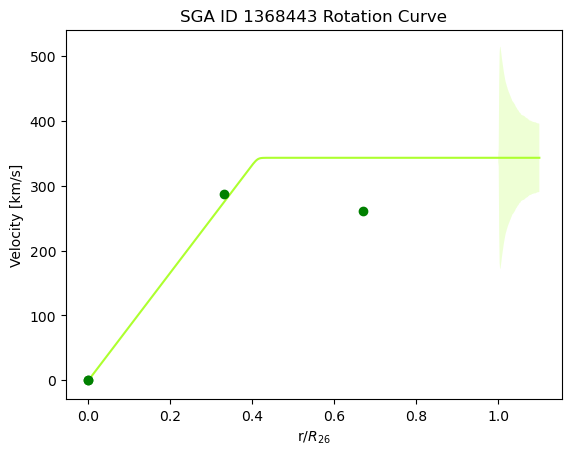

[6.87347201e+00 1.15386565e-02 2.39851341e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

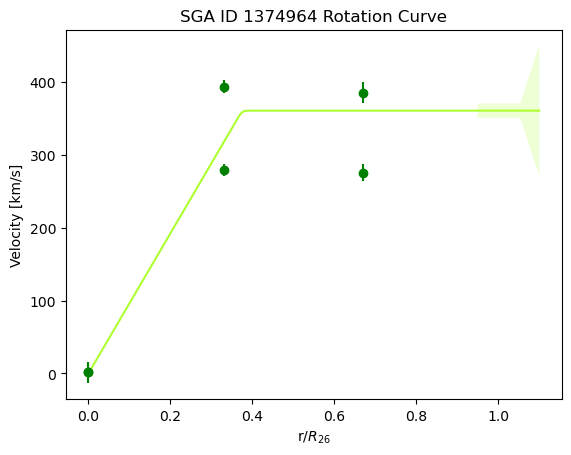

[9.14228894e+00 1.24087210e-02 4.01078301e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],


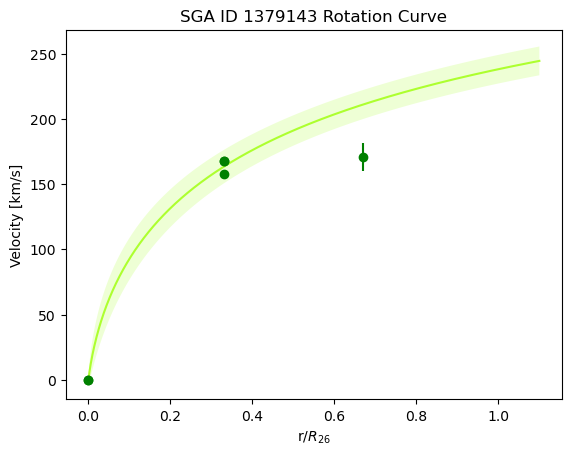

[2.56644443e+01 4.32857062e-02 1.98899663e-02]


/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: d

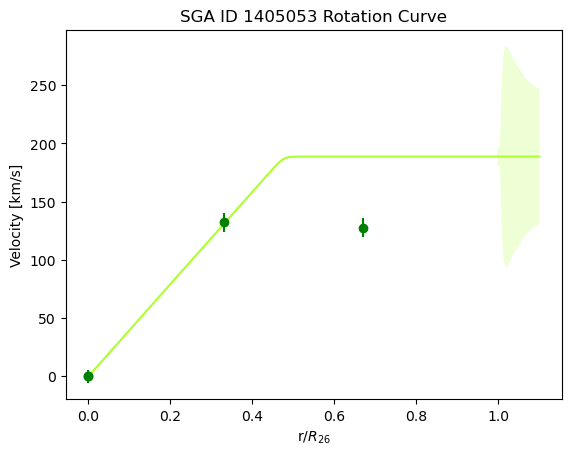

[7.85380557e+00 3.50783333e-02 5.51209960e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


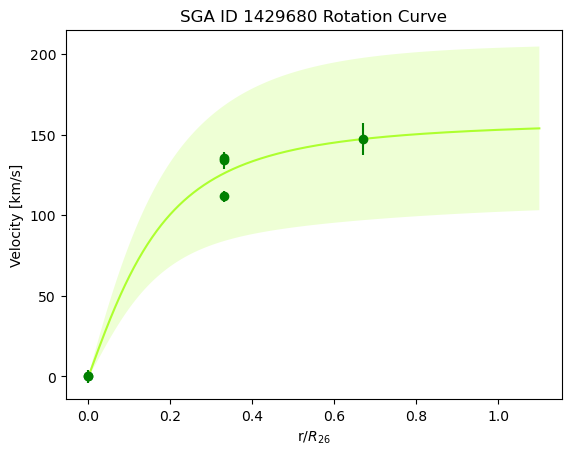

[8097.45650836   62.41689881  710.33077241]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_449240/3897457022.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0],
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_449240/1769431299.py:18: RuntimeWarning: 

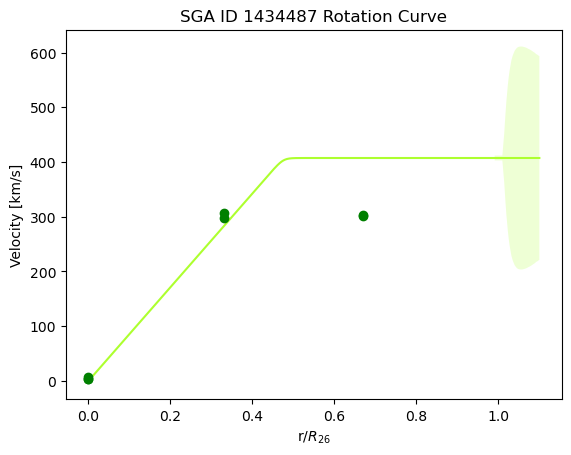

[4.59319895e+00 7.98296592e-03 1.99700931e+04]


In [18]:
#loop through all plottables
for sga_id in sga_ids:
    sga_idx = SGA_dict[sga_id]
    axis_ratio = SGA['BA'][sga_idx]
    
    #calculate inclination and assign to table
    inc = inclination_angle(axis_ratio)
    tf_mastertable['INCLINATION'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = inc
    
    #velocty cut <= 1000 and define parameters
    v = np.abs(tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VELOCITY'])
    verr = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VERR']
    radius = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['SKY_FIBER_DIST_R26']
    
    #calculate rotational velocity and error adjusted for inclination
    vrotate = v / (np.sin(inc))
    vrot = vrotate[np.abs(vrotate) <= 1000]
    vrotate_err = verr / (np.sin(inc))
    vrot_err = vrotate_err[np.abs(vrotate) <= 1000]
    r = radius[np.abs(vrotate) <= 1000]
    
    #initial guesses and bounds
    alpha_guess = 2
    alpha_low = 0.001
    alpha_high = 100
    v_max_guess = 500
    v_max_low = 10
    v_max_high = 5100
    r_turn_guess = 0.5
    r_turn_low = 0.01
    r_turn_high = 30
    
    #put guesses and bounds into array / tuples to pass into functions
    guess = [v_max_guess, r_turn_guess, alpha_guess]
    bounds = [(v_max_low, v_max_high), (r_turn_low, r_turn_high), (alpha_low, alpha_high)]
    
    #define result
    result = minimize(chi_2, guess, method = 'Powell', args=(vrot, vrot_err, r), bounds=bounds)
    
    #plot only if result succeeds
    if result.success:
        #calculating errors
        hessian = ndt.Hessian(chi_2)
        hess = hessian(result.x, vrot, vrot_err, r)
        np.save('/pscratch/sd/j/jjpim/hessians/' + str(sga_id) + '_hessian.npy', hess)
        try:
            hess_inv = 2*np.linalg.inv(hess)
            fit_params_err = np.sqrt(np.diag(np.abs(hess_inv)))
        except np.linalg.LinAlgError:
            fit_params_err = np.nan*np.ones(len(result.x))

        #adding results into table
        tf_mastertable['VMAX'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[0]
        tf_mastertable['RTURN'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[1]
        tf_mastertable['ALPHA'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[2]
        #chi_normal = result.fun/(len(v)-3)
        tf_mastertable['ROTCURVE_CHI2'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.fun
        
        #adding errors to mastertable
        tf_mastertable['VMAX_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[0]
        tf_mastertable['RTURN_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[1]
        tf_mastertable['ALPHA_ERR'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[2]
        
        #create and index linear space
        rs = np.linspace(0, 1.1, 1000)
        vs = v_rot(rs, result.x[0], result.x[1], result.x[2])
            

        if not np.isnan(fit_params_err).all():
            N_samples = 10000
            try:
                random_sample = np.random.multivariate_normal(mean=[result.x[0],
                                                            result.x[1],
                                                            result.x[2]],
                                                            cov=hess_inv,
                                                            size=N_samples)
            except:
                print(str(sga_id) + ' plot sample failed')
            
            #cuts out bad samples in gaussian
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]
        
        
            y_sample = np.zeros((len(rs), len(good_randoms[:,0])))
            for i in range(len(rs)):
                for j in range(len(good_randoms[:,0])):
            # Calculate values of curve at this location
                    y_sample[i][j] = v_rot(rs[i], good_randoms[:,0][j],
                                             good_randoms[:,1][j],
                                             good_randoms[:,2][j])
        
            #standard dev along axis of parameter variances
            stdevs = np.nanstd(y_sample, axis=1)   
        
            plt.fill_between(rs, vs - stdevs, vs + stdevs, facecolor='greenyellow', alpha=0.2)
        
        plt.errorbar(r, vrot, yerr=vrot_err, linestyle='none', marker='o', color='g')
        plt.plot(rs, vs, color='greenyellow')
        plt.xlabel(r"r/$R_{26}$")
        plt.ylabel("Velocity [km/s]")
        plt.title("SGA ID "+str(sga_id)+ " Rotation Curve")
        img_name = v_dir + '{}.jpg'.format(sga_id)
        plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
        plt.show()
        plt.close()
        
        print(fit_params_err)

In [19]:
tf_mastertable[tf_mastertable['SGA_ID']==sga_id]

<Table length=11>
     TARGETID        TARGET_RA     ...     ALPHA_ERR         INCLINATION    
      int64           float64      ...      float64            float64      
----------------- ---------------- ... ------------------ ------------------
 1070879538675714 217.717762313817 ...                nan                nan
 1084073678209026 217.717762313817 ...                nan                nan
 1070879538675717 217.723042771075 ... 19970.093144198698 1.1871011612456124
 1070879538675718 217.724392551459 ...                nan                nan
 1070879538675715 217.719072566947 ... 19970.093144198698 1.1871011612456124
 1084073678209027 217.719072566947 ... 19970.093144198698 1.1871011612456124
 1070879538675716   217.7204224802 ... 19970.093144198698 1.1871011612456124
39632951348036239 217.721732646916 ... 19970.093144198698 1.1871011612456124
 1070879538675719 217.725702589223 ...                nan                nan
39632951348036239 217.721732646916 ... 19970.093144198698 1.1871011612456124
39632951348036239 217.721732646916 ... 19970.093144198698 1.1871011612456124

In [75]:
print(len(v))

4


In [20]:
#writing new data into new table
tf_mastertable.write(data_dir + 'tf_mastertable.fits', format='fits', overwrite=True)